# Pre-requisites

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import shutil
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid


# Test Analysis

## Data

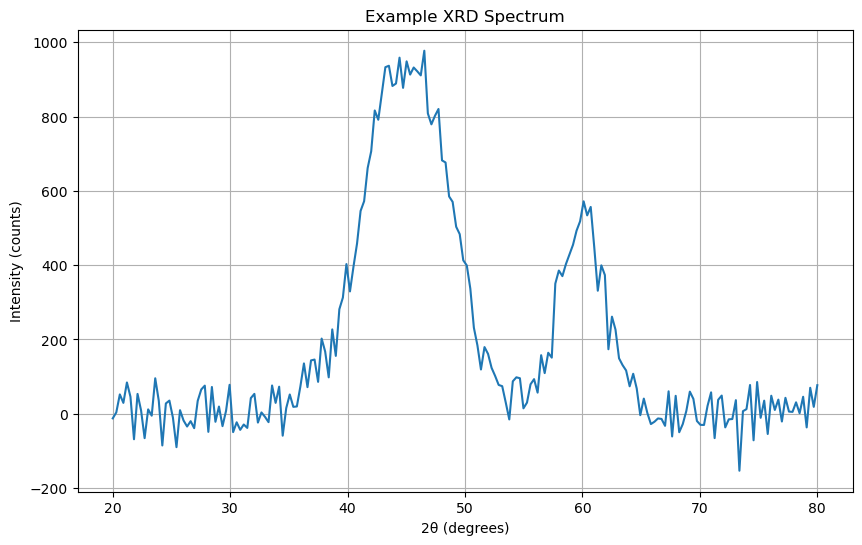

Detected Peaks:
      TwoTheta   Intensity
59   37.788945  202.295981
62   38.693467  226.932327
64   39.296482  281.266023
65   39.597990  312.685855
66   39.899497  402.840132
67   40.201005  329.231778
68   40.502513  396.274792
69   40.804020  458.259581
70   41.105528  545.937539
71   41.407035  572.114870
72   41.708543  661.501070
73   42.010050  706.632341
74   42.311558  816.398423
75   42.613065  791.402007
76   42.914573  861.888436
77   43.216080  932.884396
78   43.517588  936.811427
79   43.819095  882.359477
80   44.120603  888.953363
81   44.422111  958.566496
82   44.723618  877.294929
83   45.025126  948.665363
84   45.326633  913.026192
85   45.628141  932.038987
86   45.929648  921.906842
87   46.231156  910.879976
88   46.532663  977.253485
89   46.834171  808.517759
90   47.135678  779.073738
91   47.437186  801.847819
92   47.738693  820.364356
93   48.040201  682.032184
94   48.341709  676.347246
95   48.643216  584.978343
96   48.944724  570.287203
97   49.2462

In [4]:
# Generate some example XRD spectra data
# This is just an example, replace with your actual data
two_theta = np.linspace(20, 80, 200)  # 2-theta values
intensity = 1000 * np.exp(-((two_theta - 45) / 5) ** 2) + \
            500 * np.exp(-((two_theta - 60) / 3) ** 2) + \
            np.random.normal(0, 50, size=two_theta.size)  # Intensity values with some noise

# Create a Pandas DataFrame to store the data
xrd_data = pd.DataFrame({'TwoTheta': two_theta, 'Intensity': intensity})

# Plot the XRD spectra
plt.figure(figsize=(10, 6))
plt.plot(xrd_data['TwoTheta'], xrd_data['Intensity'])
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (counts)')
plt.title('Example XRD Spectrum')
plt.grid(True)
plt.show()

# Basic analysis (peak detection - simple example)
# You would typically use a proper peak finding algorithm here
peak_threshold = 200  # Adjust this threshold as needed
peaks = xrd_data[xrd_data['Intensity'] > peak_threshold]

print("Detected Peaks:")
print(peaks)

## Intensity-Based Method (Segal Method)

In [10]:
# --- Step 2: Intensity-Based Method (Segal Method) ---
# Find the maximum peak (crystalline peak)
cryst_peak_idx = np.argmax(intensity)
I_cryst = intensity[cryst_peak_idx]
theta_cryst = two_theta[cryst_peak_idx]

# Estimate amorphous intensity as the local minimum near the crystalline peak
I_amorph = np.min(intensity[cryst_peak_idx-10:cryst_peak_idx+10])  # Adjust search window

# Compute crystallinity index
Xc_intensity = ((I_cryst - I_amorph) / I_cryst) * 100
print(f"Crystallinity (Intensity Method): {Xc_intensity:.2f}%")

Crystallinity (Intensity Method): 41.74%


## Area-Based Method (Peak Deconvolution)

### Iteration 1

In [ ]:
# --- Step 3: Area-Based Method (Peak Deconvolution) ---
# Smooth the spectrum to estimate amorphous background
smoothed_intensity = savgol_filter(intensity, window_length=51, polyorder=2)

# Detect crystalline peaks
peaks, _ = find_peaks(intensity, height=smoothed_intensity+5, prominence=10, width=2)

# Integrate crystalline peaks
Ac = trapezoid(intensity[peaks], two_theta[peaks])

# Integrate total area and subtract crystalline contribution for amorphous area
total_area = trapezoid(intensity, two_theta)
Aa = total_area - Ac

# Compute crystallinity index
Xc_area = (Ac / (Ac + Aa)) * 100
print(f"Crystallinity (Area Method): {Xc_area:.2f}%")

Crystallinity (Area Method): 189.00%


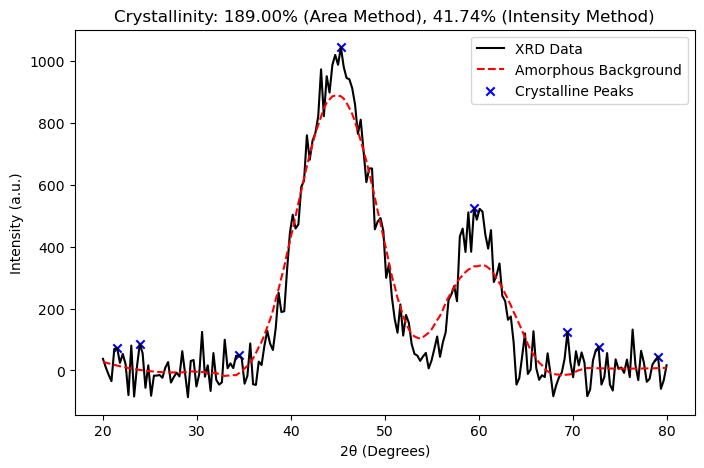

In [16]:
# --- Step 4: Plot Results ---
plt.figure(figsize=(8,5))
plt.plot(two_theta, intensity, label="XRD Data", color="black")
plt.plot(two_theta, smoothed_intensity, label="Amorphous Background", linestyle="dashed", color="red")
plt.scatter(two_theta[peaks], intensity[peaks], color="blue", marker="x", label="Crystalline Peaks")
plt.xlabel("2θ (Degrees)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.title(f"Crystallinity: {Xc_area:.2f}% (Area Method), {Xc_intensity:.2f}% (Intensity Method)")
plt.show()

### Iteration 2: Baseline Subtraction

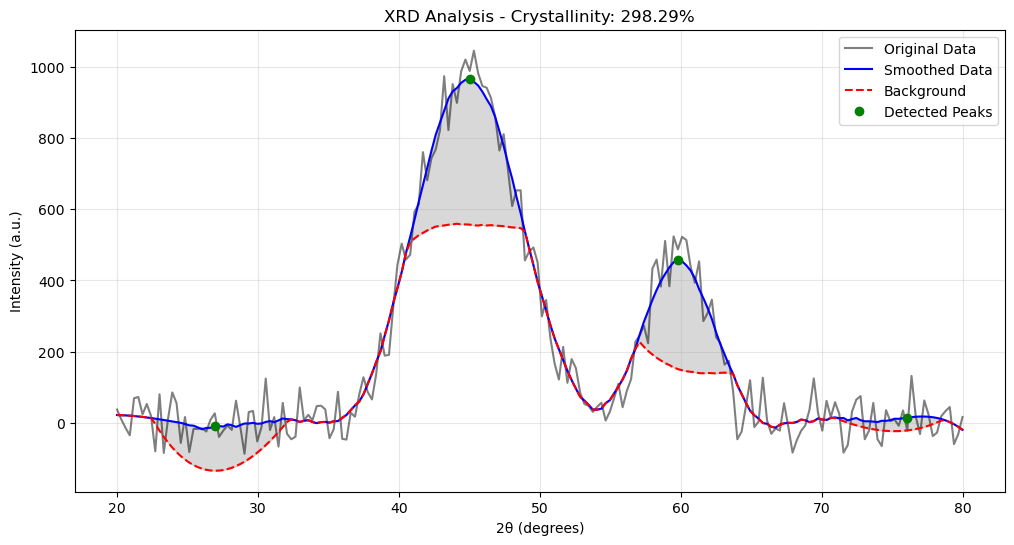

Crystallinity (Area Method): 298.29%


In [19]:
# --- Step 3: Area-Based Method with Improved Background Separation ---
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.integrate import trapezoid

# 1. First smooth the data to reduce noise
smoothed_intensity = savgol_filter(intensity, window_length=31, polyorder=3)

# 2. Estimate background using a wider window
background = savgol_filter(intensity, window_length=101, polyorder=3)
background = np.minimum(background, smoothed_intensity)  # Ensure background doesn't exceed signal

# 3. Subtract background to get peak-only signal
peaks_signal = smoothed_intensity - background

# 4. Find peaks in the background-subtracted signal
peaks, properties = find_peaks(peaks_signal,
                             height=10,          # Minimum peak height after background subtraction
                             distance=20,        # Minimum separation between peaks
                             prominence=5,       # Minimum peak prominence
                             width=2)           # Minimum peak width

# 5. Calculate areas
# Crystalline area (area of peaks above background)
Ac = trapezoid(peaks_signal[peaks], two_theta[peaks])

# Total area above background
total_area = trapezoid(peaks_signal, two_theta)

# Amorphous area
Aa = total_area - Ac

# 6. Compute crystallinity index
Xc_area = (Ac / total_area) * 100

# 7. Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(two_theta, intensity, 'k-', label='Original Data', alpha=0.5)
plt.plot(two_theta, smoothed_intensity, 'b-', label='Smoothed Data')
plt.plot(two_theta, background, 'r--', label='Background')
plt.plot(two_theta[peaks], smoothed_intensity[peaks], 'go', label='Detected Peaks')
plt.fill_between(two_theta, background, smoothed_intensity, alpha=0.3, color='gray')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title(f'XRD Analysis - Crystallinity: {Xc_area:.2f}%')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Crystallinity (Area Method): {Xc_area:.2f}%")

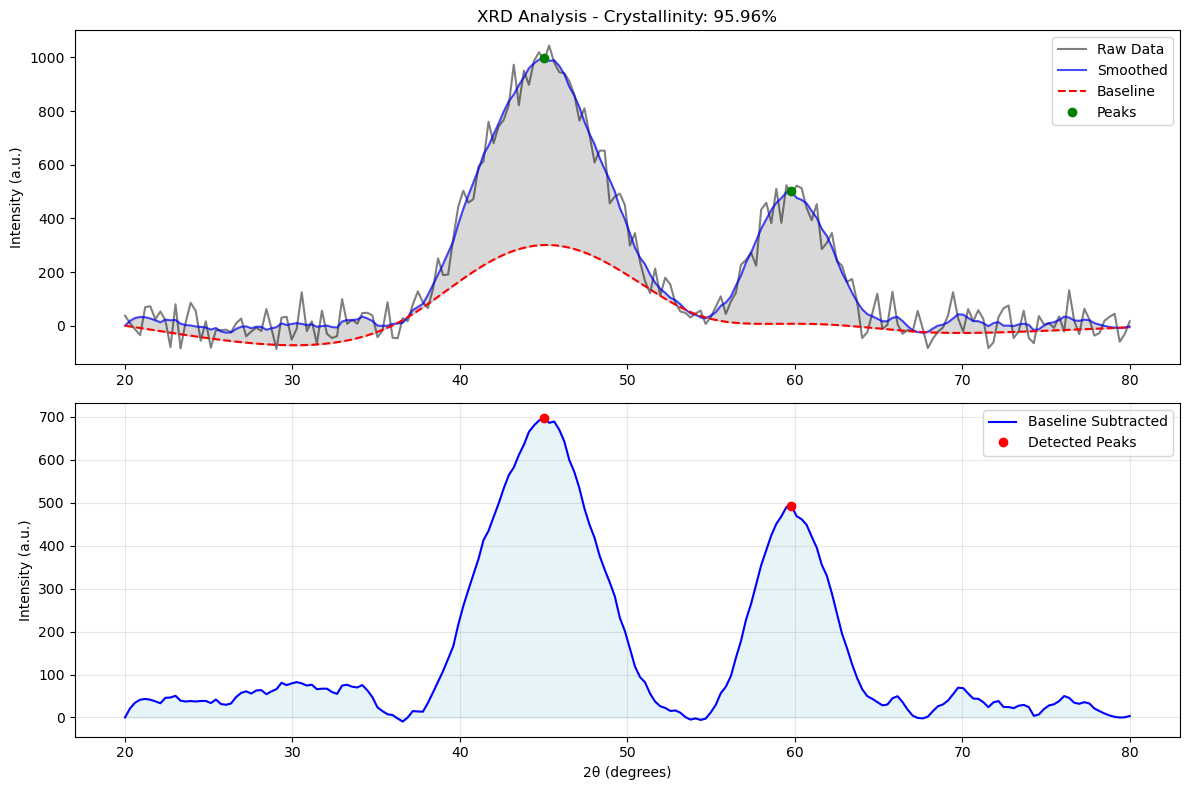

Crystallinity: 95.96%
Number of peaks detected: 2


In [ ]:
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.integrate import trapezoid
from scipy.optimize import minimize
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt


def detect_baseline_peaks(two_theta, intensity, visualise=True):
    """
    Automatic baseline detection and peak finding
    """
    # 1. Initial smoothing
    smoothed = savgol_filter(intensity, window_length=15, polyorder=3)
    
    # 2. Adaptive baseline detection
    def baseline_als(y, lam=100, p=0.001, niter=10):
        L = len(y)
        D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
        w = np.ones(L)
        for i in range(niter):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z
    
    # Calculate baseline
    baseline = baseline_als(smoothed, lam=100, p=0.001)
    
    # 3. Peak detection on baseline-subtracted data
    peaks_signal = smoothed - baseline
    peaks, properties = find_peaks(peaks_signal,
                                 height=np.std(peaks_signal)*2,
                                 distance=10,
                                 prominence=np.std(peaks_signal),
                                 width=2)
    
    # 4. Calculate areas
    crystalline_area = trapezoid(peaks_signal[peaks], two_theta[peaks])
    total_area = trapezoid(peaks_signal, two_theta)
    amorphous_area = total_area - crystalline_area
    
    # 5. Calculate crystallinity
    crystallinity = (crystalline_area / total_area) * 100
    
    if visualise:
        plt.figure(figsize=(12, 8))
        
        # Main plot
        plt.subplot(2, 1, 1)
        plt.plot(two_theta, intensity, 'k-', label='Raw Data', alpha=0.5)
        plt.plot(two_theta, smoothed, 'b-', label='Smoothed', alpha=0.7)
        plt.plot(two_theta, baseline, 'r--', label='Baseline')
        plt.plot(two_theta[peaks], smoothed[peaks], 'go', label='Peaks')
        plt.fill_between(two_theta, baseline, smoothed, alpha=0.3, color='gray')
        plt.legend()
        plt.title(f'XRD Analysis - Crystallinity: {crystallinity:.2f}%')
        plt.ylabel('Intensity (a.u.)')
        
        # Baseline-subtracted plot
        plt.subplot(2, 1, 2)
        plt.plot(two_theta, peaks_signal, 'b-', label='Baseline Subtracted')
        plt.plot(two_theta[peaks], peaks_signal[peaks], 'ro', label='Detected Peaks')
        plt.fill_between(two_theta, np.zeros_like(two_theta), peaks_signal, 
                        alpha=0.3, color='lightblue')
        plt.xlabel('2θ (degrees)')
        plt.ylabel('Intensity (a.u.)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'baseline': baseline,
        'peaks': peaks,
        'crystallinity': crystallinity,
        'peak_properties': properties,
        'peaks_signal': peaks_signal
    }

# Run the analysis
results = detect_baseline_peaks(two_theta, intensity)
print(f"Crystallinity: {results['crystallinity']:.2f}%")
print(f"Number of peaks detected: {len(results['peaks'])}")

In [6]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

def gaussian(x, amplitude, center, width):
    """Single Gaussian peak function"""
    return amplitude * np.exp(-(x - center)**2 / (2 * width**2))

def fit_xrd_spectrum(two_theta, intensity, peak_prominence=10, peak_width=2):
    """
    Analyze XRD spectrum to determine crystallinity
    
    Parameters:
    -----------
    two_theta : array-like
        2θ angles
    intensity : array-like
        Intensity values
    peak_prominence : float
        Minimum peak prominence for detection
    peak_width : float
        Minimum peak width for detection
    """
    
    # 1. Smooth the data to reduce noise
    smoothed = savgol_filter(intensity, window_length=15, polyorder=3)
    
    # 2. Find crystalline peaks
    peaks, properties = find_peaks(smoothed, 
                                 prominence=peak_prominence,
                                 width=peak_width)
    
    # 3. Initial fit for crystalline peaks
    def multi_gaussian_crystalline(x, *params):
        y = np.zeros_like(x)
        for i in range(0, len(params), 3):
            y += gaussian(x, params[i], params[i+1], params[i+2])
        return y
    
    # Initial parameter guess for crystalline peaks
    p0_crystalline = []
    for peak in peaks:
        p0_crystalline.extend([
            smoothed[peak],           # amplitude
            two_theta[peak],         # center
            0.2                      # width (sharp peaks)
        ])
    
    # Fit crystalline peaks
    popt_crystalline, _ = curve_fit(multi_gaussian_crystalline, two_theta, 
                                   smoothed, p0=p0_crystalline)
    
    # 4. Fit broad amorphous background
    # Subtract crystalline peaks from total intensity
    crystalline_fit = multi_gaussian_crystalline(two_theta, *popt_crystalline)
    amorphous_intensity = smoothed - crystalline_fit
    
    # Fit broad Gaussians for amorphous background
    def multi_gaussian_amorphous(x, *params):
        y = np.zeros_like(x)
        for i in range(0, len(params), 3):
            y += gaussian(x, params[i], params[i+1], params[i+2])
        return y
    
    # Initial guess for amorphous background (3 broad peaks)
    p0_amorphous = [
        np.mean(amorphous_intensity), np.mean(two_theta), 10.0,
        np.mean(amorphous_intensity), np.min(two_theta), 10.0,
        np.mean(amorphous_intensity), np.max(two_theta), 10.0
    ]
    
    # Fit amorphous background
    popt_amorphous, _ = curve_fit(multi_gaussian_amorphous, two_theta,
                                 amorphous_intensity, p0=p0_amorphous)
    
    # 5. Calculate areas and crystallinity
    amorphous_fit = multi_gaussian_amorphous(two_theta, *popt_amorphous)
    
    area_crystalline = trapezoid(crystalline_fit, two_theta)
    area_amorphous = trapezoid(amorphous_fit, two_theta)
    crystallinity = area_crystalline / (area_crystalline + area_amorphous) * 100
    
    return {
        'peaks': peaks,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'crystallinity': crystallinity
    }

# Plot results
def plot_xrd_analysis(two_theta, intensity, results):
    plt.figure(figsize=(12, 6))
    plt.plot(two_theta, intensity, 'k-', label='Raw Data', alpha=0.5)
    plt.plot(two_theta, results['crystalline_fit'], 'b-', 
             label='Crystalline Peaks', alpha=0.7)
    plt.plot(two_theta, results['amorphous_fit'], 'r--', 
             label='Amorphous Background')
    plt.plot(two_theta[results['peaks']], intensity[results['peaks']], 
             'go', label='Peak Positions')
    
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Intensity (a.u.)')
    plt.legend()
    plt.title(f'XRD Analysis - Crystallinity: {results["crystallinity"]:.1f}%')
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage with your data:
results = fit_xrd_spectrum(two_theta, intensity)
plot_xrd_analysis(two_theta, intensity, results)
print(f"Crystallinity: {results['crystallinity']:.1f}%")

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5600.

In [13]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

# 1. Smooth the data to reduce noise
smoothed = savgol_filter(intensity, window_length=15, polyorder=3)

# 2. Find crystalline peaks
peaks, properties = find_peaks(smoothed, 
                             height=200,
                             prominence=10,
                             width=2)

# 3. Fit baseline to non-peak regions
# Exclude peak regions for baseline fitting
non_peak_indices = np.ones(len(two_theta), dtype=bool)
for i, peak in enumerate(peaks):
    width = properties['width'][i]  # Full width at half maximum
    width_in_indices = int(width) # Convert width to indices
    start = max(0, int(peak - width_in_indices))
    end = min(len(two_theta), int(peak + width_in_indices))
    non_peak_indices[start:end] = False

# Fit a polynomial baseline
baseline_degree = 3  # Adjust polynomial degree as needed
coeffs = np.polyfit(two_theta[non_peak_indices], 
                     smoothed[non_peak_indices], baseline_degree)
baseline = np.polyval(coeffs, two_theta)

# 4. Subtract baseline from raw spectrum
intensity_corrected = smoothed - baseline
intensity_corrected[intensity_corrected < 0] = 0  # Ensure no negative intensities

# 5. Integrate to compute crystallinity
total_area_corrected = trapezoid(intensity_corrected, two_theta)

# Integrate crystalline peaks area
peak_areas = []
for peak in peaks:
    start = max(0, peak - 5)  # Adjust range as needed
    end = min(len(two_theta), peak + 5)  # Adjust range as needed
    peak_area = trapezoid(intensity_corrected[start:end], two_theta[start:end])
    peak_areas.append(peak_area)

crystalline_area = np.sum(peak_areas)

# Calculate crystallinity
crystallinity = crystalline_area / total_area_corrected * 100

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(two_theta, intensity, 'k-', label='Raw Data', alpha=0.5)
plt.plot(two_theta, baseline, 'r--', label='Baseline')
plt.plot(two_theta, intensity_corrected, 'b-', 
         label='Baseline Corrected', alpha=0.7)
plt.plot(two_theta[peaks], intensity[peaks], 
         'go', label='Peak Positions')

plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title(f'XRD Analysis - Crystallinity: {crystallinity:.1f}%')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Crystallinity: {crystallinity:.1f}%")


KeyError: 'width'

### Iteration 3: Peak Fitting

In [ ]:
# --- Step 2: Smooth the Spectrum (Estimate Amorphous Background) ---
smoothed_intensity = savgol_filter(intensity, window_length=15, polyorder=3)

# --- Step 3: Identify Crystalline Peaks ---
peaks, _ = find_peaks(intensity, height=smoothed_intensity+20, prominence=10, width=2)
crystalline_theta = two_theta[peaks]
crystalline_intensity = intensity[peaks]

# --- Step 4: Define Gaussian Function ---
def gaussian(x, A, x0, sigma):
    """
    Computes a Gaussian function.

    Parameters:
        x : array-like
            The x-values (e.g., 2θ values in XRD).
        A : float
            The amplitude (peak height).
        x0 : float
            The center of the peak.
        sigma : float
            The standard deviation (controls peak width).

    Returns:
        Gaussian function values at x.
    """
    return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

# --- Step 5: Fit Multiple Gaussian Peaks ---
def multi_gaussian(x, *params):
    """
    Computes multiple Gaussian peaks by summing them.

    Parameters:
        x : array-like
            The x-values (e.g., 2θ values in XRD).
        params : list of floats
            Parameters in the form (a1, x01, sigma1, a2, x02, sigma2, ..., an, x0n, sigman)
            for n Gaussian peaks.

    Returns:
        Sum of all Gaussian function values at x.
    """
    num_peaks = len(params) // 3    # Each peak has 3 parameters (a, x0, sigma)
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        A, mu, sigma = params[3*i:3*i+3]
        y_fit += gaussian(x, A, mu, sigma)
    return y_fit

# Initial guess for Gaussian parameters: [A1, x01, sigma1, A2, x02, sigma2, ...]
init_guess = []
num_crystalline_peaks = 9   # specific to PEEK
num_amorphous_peaks = 5 # specific to PEEK

# Estimate parameters for crystalline peaks
for i in range(num_crystalline_peaks):
    if i < len(crystalline_theta):
        init_guess += [crystalline_intensity[i], crystalline_theta[i], 0.5]  # A, x0, sigma

# Estimate parameters for amorphous background
amorphous_regions = np.linspace(two_theta.min(), two_theta.max(), num_amorphous_peaks)
for i in range(num_amorphous_peaks):
    init_guess += [np.mean(intensity), amorphous_regions[i], 5]  # Broader sigma for amorphous

# Curve fitting
popt, _ = curve_fit(multi_gaussian, two_theta, intensity, p0=init_guess)

# --- Step 6: Compute Crystalline and Amorphous Areas ---
crystalline_fit = multi_gaussian(two_theta, *popt[:3*num_crystalline_peaks])
amorphous_fit = multi_gaussian(two_theta, *popt[3*num_crystalline_peaks:])

Ac = np.trapz(crystalline_fit, two_theta)  # Area under crystalline peaks
Aa = np.trapz(amorphous_fit, two_theta)    # Area under amorphous background

Xc = (Ac / (Ac + Aa)) * 100  # Crystallinity Index

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 8000.

Crystallinity (Area Method): 77.44%


C:\Users\sieun\AppData\Local\Temp\ipykernel_22112\1180507173.py:38: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(multi_gaussian, two_theta, intensity, p0=init_guess)


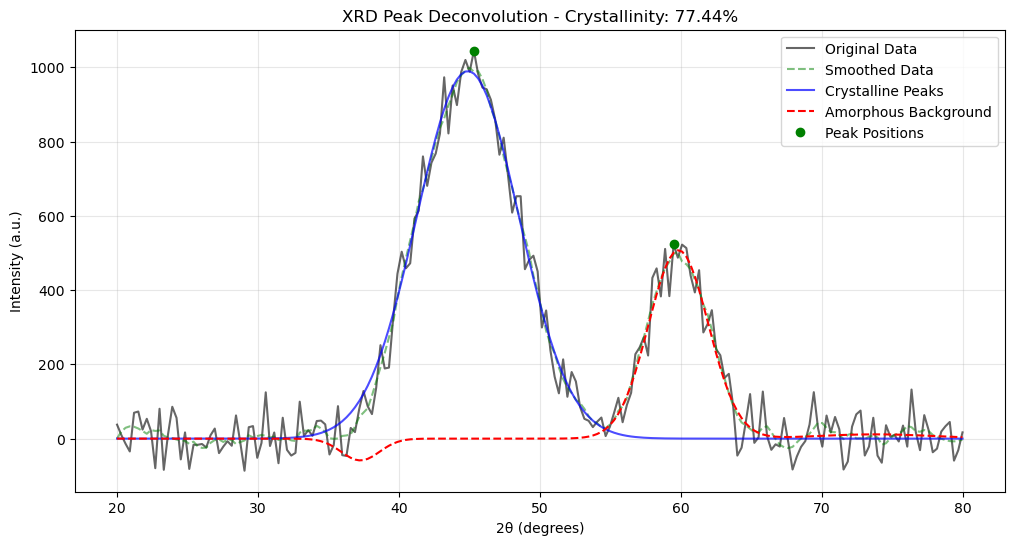

In [24]:
# --- Step 2: Smooth the Spectrum (Estimate Amorphous Background) ---
smoothed_intensity = savgol_filter(intensity, window_length=15, polyorder=3)

# --- Step 3: Identify Crystalline Peaks ---
crystalline_peaks, _ = find_peaks(intensity, height=200, prominence=10, width=2)
crystalline_theta = two_theta[peaks]
crystalline_intensity = intensity[peaks]

# --- Step 4: Define Gaussian Function ---
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# --- Step 5: Fit Multiple Gaussian Peaks ---
def multi_gaussian(x, *params):
    num_peaks = len(params) // 3
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        A, mu, sigma = params[3*i:3*i+3]
        y_fit += gaussian(x, A, mu, sigma)
    return y_fit

# Initial guess for Gaussian parameters: [A1, mu1, sigma1, A2, mu2, sigma2, ...]
init_guess = []
num_crystalline_peaks = len(crystalline_peaks)  # Dynamic number of Gaussian peaks
num_amorphous_peaks = max(3, min(7, int(num_crystalline_peaks / 2)))  # Rule of thumb

# Estimate parameters for crystalline peaks
for i in range(num_crystalline_peaks):
    if i < len(crystalline_theta):
        init_guess += [crystalline_intensity[i], crystalline_theta[i], 0.5]  # A, mu, sigma

# Estimate parameters for amorphous background
amorphous_regions = np.linspace(two_theta.min(), two_theta.max(), num_amorphous_peaks)
for i in range(num_amorphous_peaks):
    init_guess += [np.mean(intensity), amorphous_regions[i], 5]  # Broader sigma for amorphous

# Curve fitting
popt, _ = curve_fit(multi_gaussian, two_theta, intensity, p0=init_guess)

# --- Step 6: Compute Crystalline and Amorphous Areas ---
crystalline_fit = multi_gaussian(two_theta, *popt[:3*num_crystalline_peaks])
amorphous_fit = multi_gaussian(two_theta, *popt[3*num_crystalline_peaks:])

Ac = np.trapz(crystalline_fit, two_theta)  # Area under crystalline peaks
Aa = np.trapz(amorphous_fit, two_theta)    # Area under amorphous background

Xc = (Ac / (Ac + Aa)) * 100  # Crystallinity Index

print(f"Crystallinity (Area Method): {Xc:.2f}%")

# 7. Visualize results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(two_theta, intensity, 'k-', label='Original Data', alpha=0.6)
plt.plot(two_theta, smoothed_intensity, 'g--', label='Smoothed Data', alpha=0.5)
plt.plot(two_theta, crystalline_fit, 'b-', label='Crystalline Peaks', alpha=0.7)
plt.plot(two_theta, amorphous_fit, 'r--', label='Amorphous Background')
plt.plot(two_theta[crystalline_peaks], intensity[crystalline_peaks], 'go', label='Peak Positions')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title(f'XRD Peak Deconvolution - Crystallinity: {Xc:.2f}%')
plt.grid(True, alpha=0.3)
plt.show()


Crystallinity: -0.57%
R-squared: 0.9765
RMSE: 43.8227


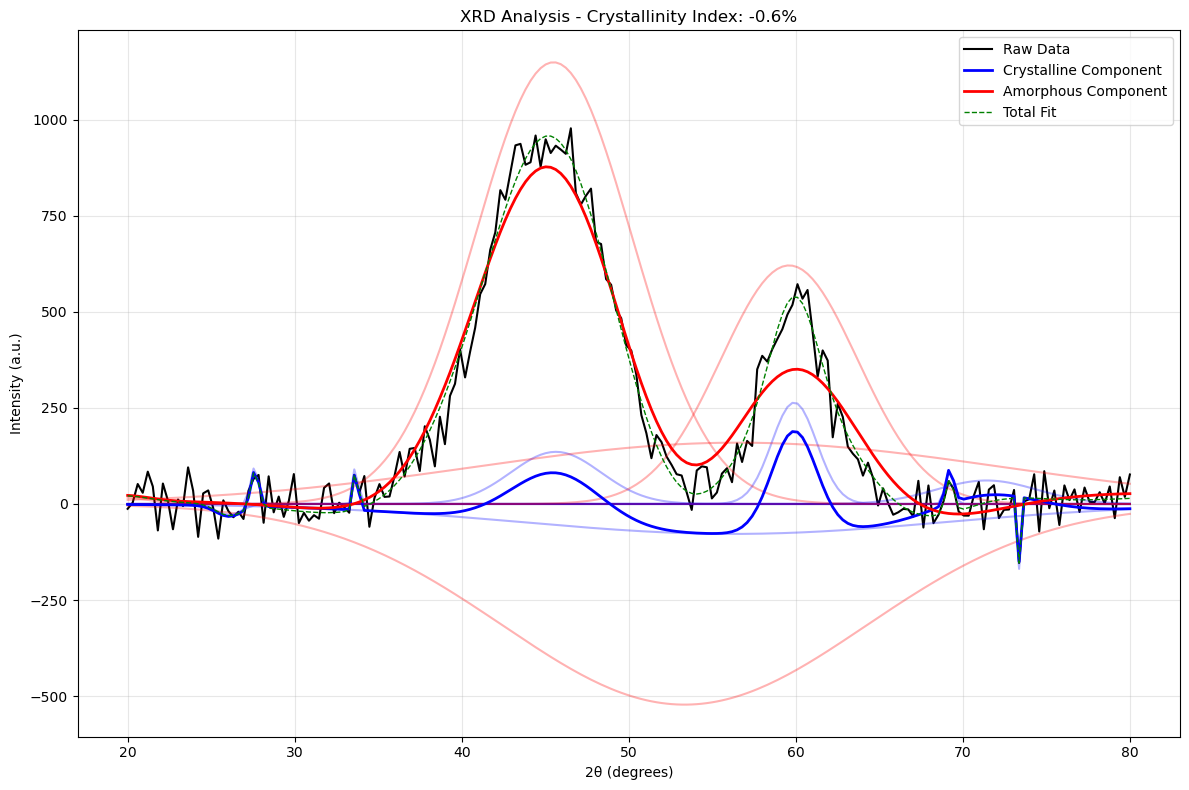

In [12]:
# --- Step 2: Smooth the Spectrum (Estimate Amorphous Background) ---
smoothed_intensity = savgol_filter(intensity, window_length=15, polyorder=3)

# --- Step 3: Identify Crystalline Peaks ---
peaks, _ = find_peaks(intensity, height=smoothed_intensity+20, prominence=10, width=2)
crystalline_theta = two_theta[peaks]
crystalline_intensity = intensity[peaks]

# --- Step 4: Define Gaussian Function ---
def gaussian(x, A, x0, sigma):
    """
    Computes a Gaussian function.

    Parameters:
        x : array-like
            The x-values (e.g., 2θ values in XRD).
        A : float
            The amplitude (peak height).
        x0 : float
            The center of the peak.
        sigma : float
            The standard deviation (controls peak width).

    Returns:
        Gaussian function values at x.
    """
    return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

# --- Step 5: Fit Multiple Gaussian Peaks ---
def multi_gaussian(x, *params):
    """
    Computes multiple Gaussian peaks by summing them.

    Parameters:
        x : array-like
            The x-values (e.g., 2θ values in XRD).
        params : list of floats
            Parameters in the form (a1, x01, sigma1, a2, x02, sigma2, ..., an, x0n, sigman)
            for n Gaussian peaks.

    Returns:
        Sum of all Gaussian function values at x.
    """
    num_peaks = len(params) // 3    # Each peak has 3 parameters (a, x0, sigma)
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        A, mu, sigma = params[3*i:3*i+3]
        y_fit += gaussian(x, A, mu, sigma)
    return y_fit

# First fit the amorphous background independently
def amorphous_background(x, *params):
    num_peaks = len(params) // 3
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        A, mu, sigma = params[3*i:3*i+3]
        y_fit += gaussian(x, A, mu, sigma)
    return y_fit

# Smooth heavily to estimate background
background_smoothed = savgol_filter(intensity, window_length=51, polyorder=3)

# Fit amorphous background first
amorphous_params_guess = []
num_amorphous_peaks = 5 # specific to PEEK
amorphous_regions = np.linspace(two_theta.min(), two_theta.max(), num_amorphous_peaks)
for i in range(num_amorphous_peaks):
    amorphous_params_guess += [np.mean(intensity), amorphous_regions[i], 5]

amorphous_popt, _ = curve_fit(amorphous_background, two_theta, background_smoothed, 
                            p0=amorphous_params_guess)

# Subtract amorphous background to get crystalline component
amorphous_baseline = amorphous_background(two_theta, *amorphous_popt)
crystalline_component = intensity - amorphous_baseline

# Then fit crystalline peaks to the residual
crystalline_params_guess = []
num_crystalline_peaks = 9   # specific to PEEK
for i in range(num_crystalline_peaks):
    if i < len(crystalline_theta):
        crystalline_params_guess += [crystalline_intensity[i], crystalline_theta[i], 0.5]

crystalline_popt, _ = curve_fit(multi_gaussian, two_theta, crystalline_component, 
                              p0=crystalline_params_guess)

# Combine results
popt = np.concatenate([crystalline_popt, amorphous_popt])

# --- Step 6: Compute Crystalline and Amorphous Areas ---
crystalline_fit = multi_gaussian(two_theta, *popt[:3*num_crystalline_peaks])
amorphous_fit = multi_gaussian(two_theta, *popt[3*num_crystalline_peaks:])

Ac = np.trapz(crystalline_fit, two_theta)  # Area under crystalline peaks
Aa = np.trapz(amorphous_fit, two_theta)    # Area under amorphous background

Xc = (Ac / (Ac + Aa)) * 100  # Crystallinity Index
print(f"Crystallinity: {Xc:.2f}%")

# Calculate R-squared and RMSE to evaluate fit quality
y_fit = multi_gaussian(two_theta, *popt)
residuals = intensity - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intensity - np.mean(intensity))**2)
r_squared = 1 - (ss_res / ss_tot)
rmse = np.sqrt(np.mean(residuals**2))

print(f"R-squared: {r_squared:.4f}")
print(f"RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 8))

# Plot raw data
plt.plot(two_theta, intensity, 'k-', label='Raw Data')

# Plot individual crystalline peaks
for i in range(num_crystalline_peaks):
    if i < len(crystalline_theta):
        params = popt[3*i:3*i+3]
        peak_fit = gaussian(two_theta, *params)
        plt.plot(two_theta, peak_fit, 'b-', alpha=0.3)

# Plot individual amorphous peaks
for i in range(num_amorphous_peaks):
    j = num_crystalline_peaks + i
    params = popt[3*j:3*j+3]
    peak_fit = gaussian(two_theta, *params)
    plt.plot(two_theta, peak_fit, 'r-', alpha=0.3)

# Plot combined fits
plt.plot(two_theta, crystalline_fit, 'b-', label='Crystalline Component', linewidth=2)
plt.plot(two_theta, amorphous_fit, 'r-', label='Amorphous Component', linewidth=2)
plt.plot(two_theta, crystalline_fit + amorphous_fit, 'g--', label='Total Fit', linewidth=1)

plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.title(f'XRD Analysis - Crystallinity Index: {Xc:.1f}%')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

Key features:
- **Separate Fitting Process**: Amorphous background is fitted first with broad Gaussians, then crystalline peaks are fitted to the residual. This improves accuracy by preventing the crystalline peaks from influencing the background fit.
- **Parameter Bounds**: Constrains the fitting parameters to physically meaningful values (e.g., preventing negative amplitudes, restricting peak positions, enforcing appropriate widths).
- **Error Handling**: Includes try-except blocks to handle potential fitting failures and provide fallback options.
- **Comprehensive Visualization**: Plots include raw data, fitted components, individual peaks, and peak markers for easy interpretation.
- **Results Summary**: Outputs crystallinity percentage along with the component areas for validation.

Amorphous background fitting successful
Crystalline peak fitting successful
Crystallinity: 23.82%

Results Summary:
           Parameter         Value
0  Crystallinity (%)     23.816159
1   Crystalline Area   3781.370949
2     Amorphous Area  12095.962154
3         Total Area  15877.333103


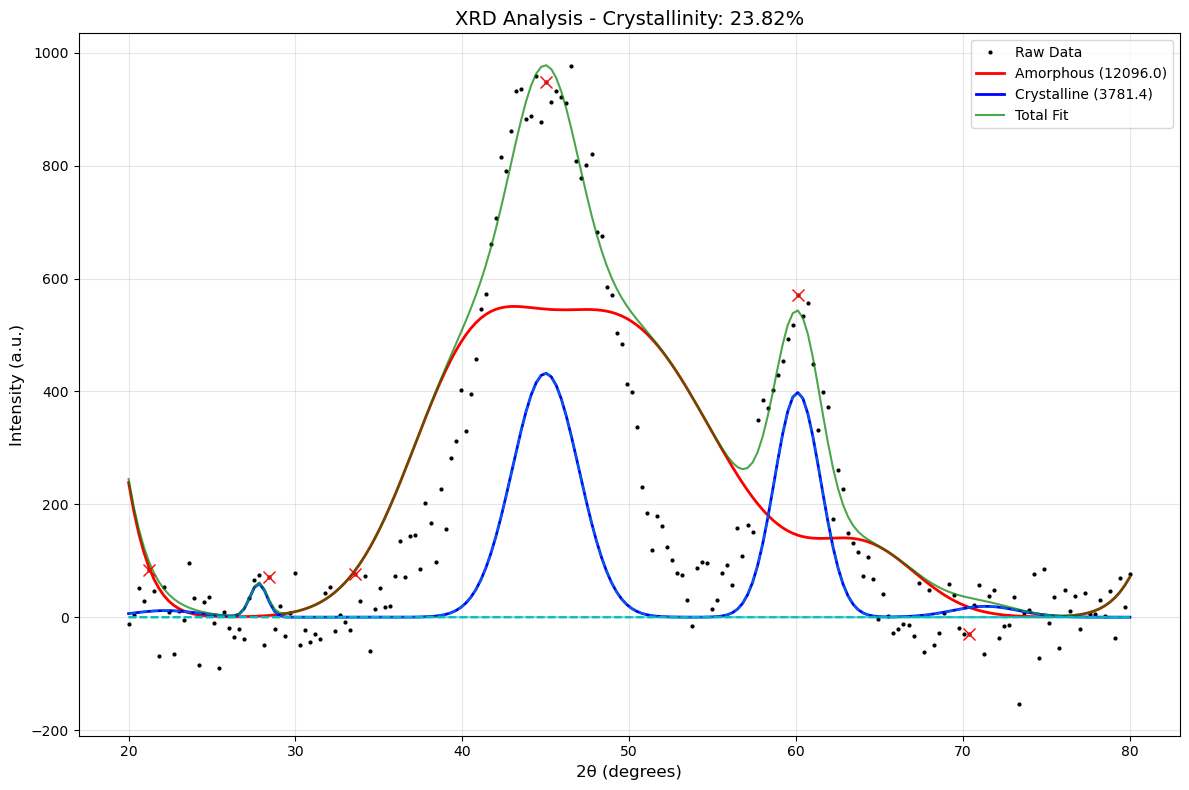

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid

# --- Step 1: Load and Visualize XRD Data ---


# --- Step 2: Data Preprocessing ---
# Smooth the data to reduce noise
smoothed_intensity = savgol_filter(intensity, window_length=15, polyorder=3)

# Normalize data if needed
normalized_intensity = intensity / np.max(intensity)

# --- Step 3: Peak Detection ---
# Find peaks in the smoothed data
peaks, properties = find_peaks(smoothed_intensity, 
                              prominence=0.05,   # Adjust as needed
                              width=2,           # Adjust as needed
                              distance=10)       # Minimum distance between peaks

# Extract peak information
crystalline_theta = two_theta[peaks]
crystalline_intensity = smoothed_intensity[peaks]

# Visualize peak detection
plt.figure(figsize=(12, 6))
plt.plot(two_theta, intensity, label='Original Data', alpha=0.5)
plt.plot(two_theta, smoothed_intensity, label='Smoothed Data', alpha=0.7)
plt.plot(two_theta[peaks], smoothed_intensity[peaks], 'ro', label='Detected Peaks')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.title('XRD Peak Detection')
plt.grid(True, alpha=0.3)


# Main Analysis

## Data

In [5]:
import os

# Get all file names in the data directory
data_dir = "../data/XRD"  # Adjust this path to your data folder
all_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')]
print(f'File names: {all_files}')

File names: ['500907.csv', '500907_2.csv', '501023.csv', '501023_2.csv', '501024.csv', '501024_2.csv', 'HDPE.csv', 'HDPE_2.csv']


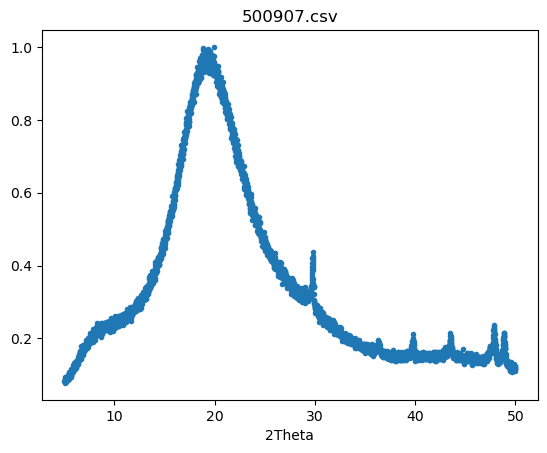

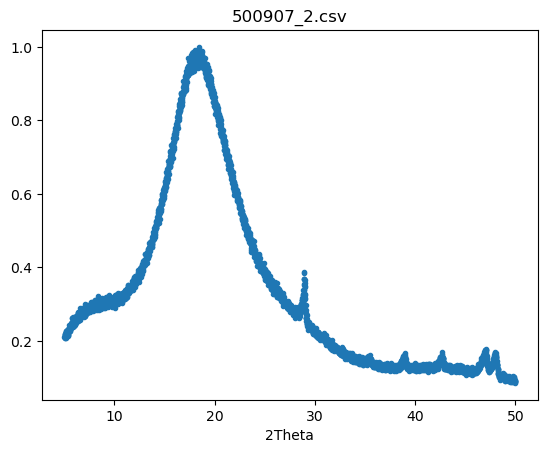

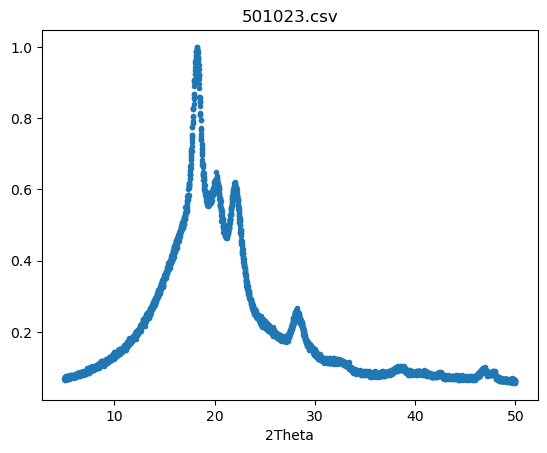

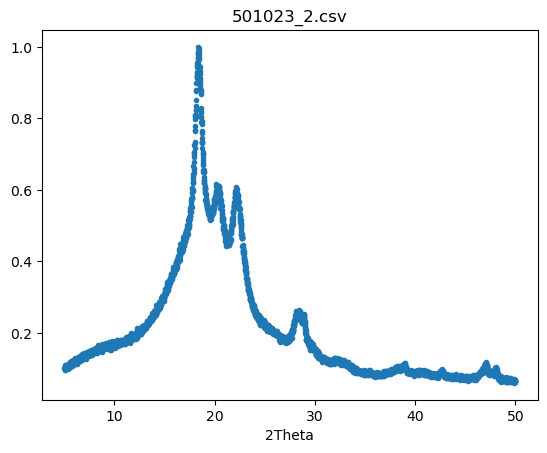

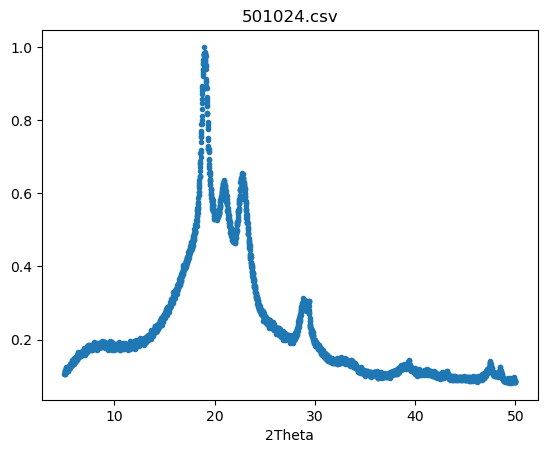

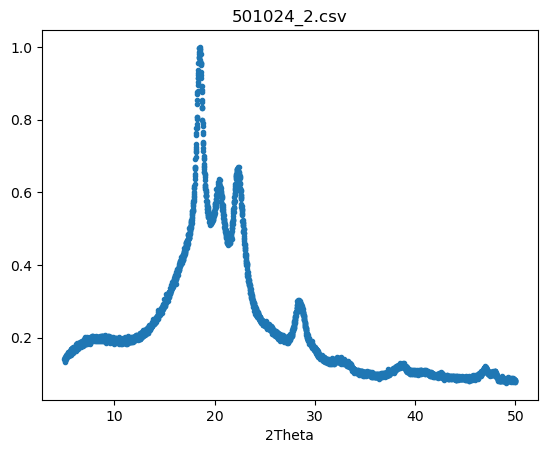

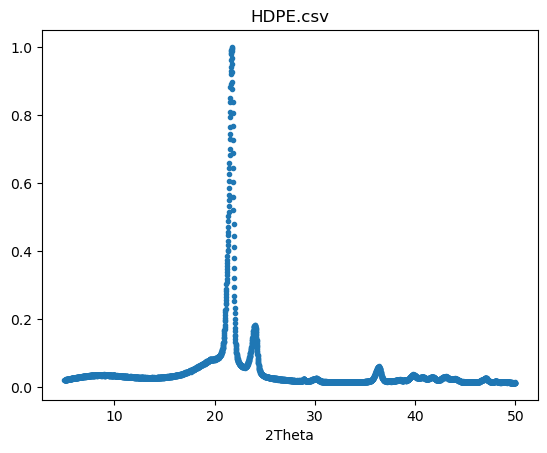

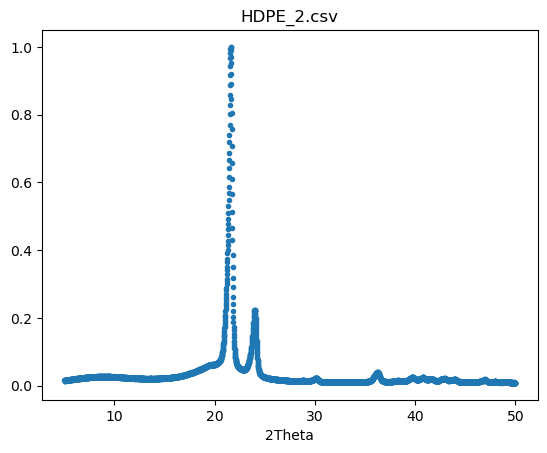

In [6]:
df_dict = {}
for file in all_files:
    df_dict[file] = pd.read_csv(os.path.join(data_dir, file), skiprows=21)
    df_dict[file].rename(columns={'Angle': '2Theta', ' Intensity': 'Intensity'}, inplace=True)
    df_dict[file]['Intensity_norm'] = df_dict[file]['Intensity'] / df_dict[file]['Intensity'].max()
    
    # Downsample data for faster peak detection
    # df_dict[file] = df_dict[file].iloc[::5, :]
    df_dict[file].plot(x='2Theta', y='Intensity_norm', title=f'{file}', legend=False, linestyle='None', marker='.')

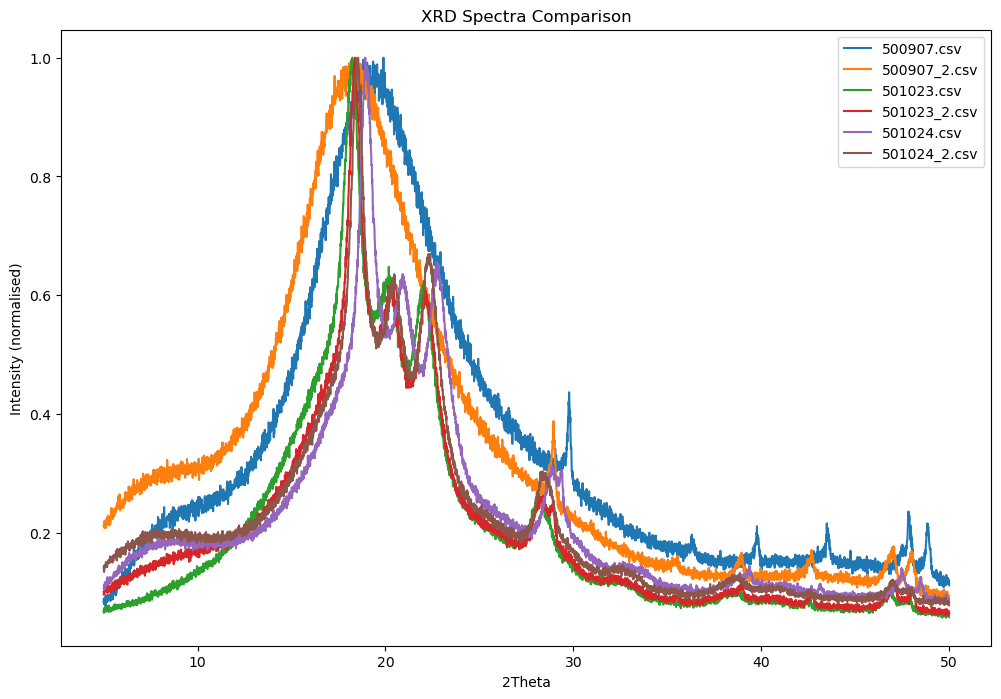

In [42]:
peek_files = [f for f in all_files if 'HDPE' not in f]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
for file in peek_files:
    ax.plot(df_dict[file]['2Theta'], df_dict[file]['Intensity_norm'], label=file)
ax.set_xlabel('2Theta')
ax.set_ylabel('Intensity (normalised)')
ax.set_title('XRD Spectra Comparison')
ax.legend()

## Analysis

### Method 1: Area-Based Crystallinity

#### Iteration 1

Text(0.5, 1.0, 'XRD Peak Detection')

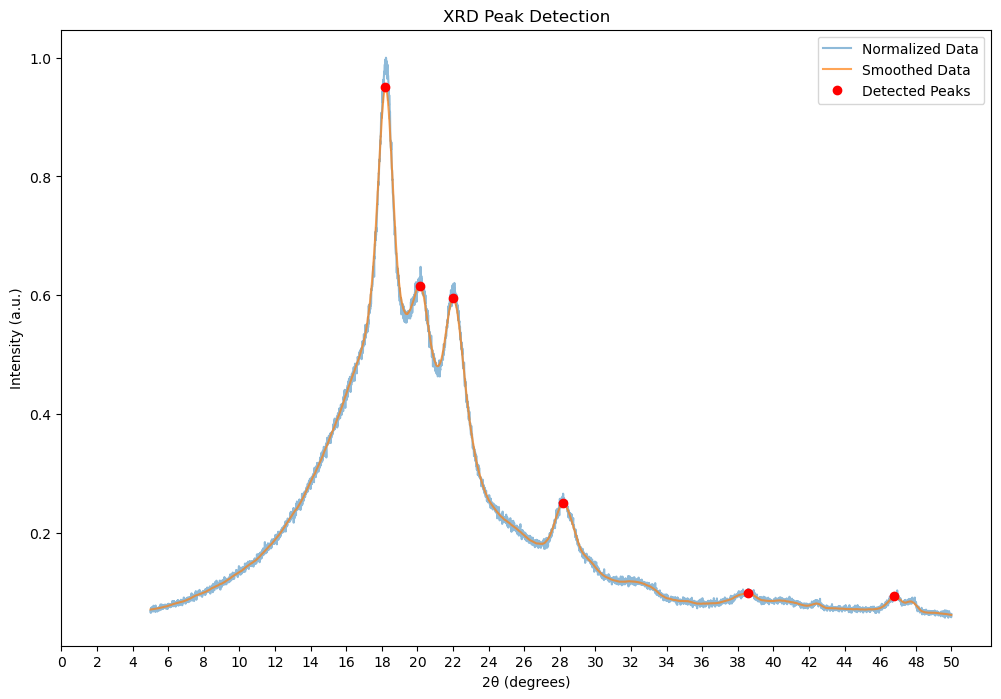

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid

# --- Step 1: Load XRD Data ---
data = df_dict['501023.csv']
intensity = data['Intensity_norm'].values
two_theta = data['2Theta'].values

# --- Step 1: Data Preprocessing ---
# Normalize intensity
normalized_intensity = intensity / np.max(intensity)

# Smooth the normalized data
smoothed_intensity = savgol_filter(normalized_intensity, window_length=50, polyorder=1)

# --- Step 2: Peak Detection ---
# First pass with less strict parameters to find major peaks
major_peaks, _ = find_peaks(smoothed_intensity, 
                            prominence=0.05,
                            width=20,
                            distance=50)

# Second pass with more sensitive settings to detect shoulders and overlaps
all_peaks, _ = find_peaks(smoothed_intensity,
                          prominence=0.005,  # Lower prominence
                          width=10,         # Lower width
                          distance=50)      # Smaller distance

# Use peak properties to get a better estimate of peak widths
_, properties = find_peaks(smoothed_intensity, 
                            prominence=0.01,
                            width=10,
                            distance=20,
                            rel_height=0.5)  # For width at half maximum

# Calculate peak widths in degrees
peak_widths_points = properties["widths"]
peak_distances = np.diff(two_theta)
avg_point_distance = np.mean(peak_distances)
peak_widths_degrees = peak_widths_points * avg_point_distance

# Extract peak information
peak_positions = two_theta[all_peaks]
peak_heights = smoothed_intensity[all_peaks]

# Visualize peak detection
plt.figure(figsize=(12, 8))
plt.plot(two_theta, normalized_intensity, label='Normalized Data', alpha=0.5)
plt.plot(two_theta, smoothed_intensity, label='Smoothed Data', alpha=0.7)
plt.plot(peak_positions, peak_heights, 'ro', label='Detected Peaks')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.xticks(np.arange(0, 51, 2))
plt.legend()
plt.title('XRD Peak Detection')


In [38]:
# --- Step 3: Define Gaussian Functions ---
def gaussian(x, A, x0, sigma):
    """Gaussian function with parameters amplitude, center, and width"""
    return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

def multi_gaussian(x, *params):
    """Fit multiple Gaussian peaks simultaneously"""
    num_peaks = len(params) // 3
    y_fit = np.zeros_like(x)
    for i in range(num_peaks):
        amp = params[3*i]
        center = params[3*i+1]
        width = params[3*i+2]
        y_fit += gaussian(x, amp, center, width)
    return y_fit

# --- Step 4: Set Up Initial Guesses with Potential Overlaps ---
init_guess = []

# Define known PEEK peak positions from literature
known_peek_peaks = [18.7, 20.8, 22.8, 28.9]  # Common peaks for PEEK in 2θ
known_peak_tolerance = 1.0  # Tolerance in degrees

# Add all detected peaks as potential crystalline components
for i in range(len(all_peaks)):
    # Check if this peak might be overlapping with others
    is_overlapping = False
    for j in range(len(all_peaks)):
        if i != j and abs(peak_positions[i] - peak_positions[j]) < 1.0:
            is_overlapping = True
            break
    
    # Determine appropriate width estimate
    if i < len(peak_widths_degrees):
        width_estimate = peak_widths_degrees[i]
        # Adjust width for overlapping peaks
        if is_overlapping:
            width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
    else:
        width_estimate = 0.5  # Default if width couldn't be determined
        
    # Add parameters [amplitude, position, width]
    init_guess.extend([peak_heights[i], peak_positions[i], width_estimate])

# Add known peaks that might have been missed
for known_pos in known_peek_peaks:
    if not any(abs(pos - known_pos) < known_peak_tolerance for pos in peak_positions):
        # Add with moderate height estimate based on nearby intensity
        nearby_idx = np.argmin(np.abs(two_theta - known_pos))
        height_estimate = smoothed_intensity[nearby_idx] * 0.8
        init_guess.extend([height_estimate, known_pos, 0.5])

# Add amorphous background peaks
amorphous_positions = [9, 19, 22, 29, 37]
num_amorphous_peaks = len(amorphous_positions)
mean_intensity = np.mean(smoothed_intensity)

for pos in amorphous_positions:
    init_guess.extend([mean_intensity/2, pos, 5.0]) # amplitude, position, width

# Count total peaks
num_detected_peaks = len(all_peaks)
num_added_known_peaks = sum(1 for pos in known_peek_peaks 
                            if not any(abs(p - pos) < known_peak_tolerance for p in peak_positions))
num_total_peaks = num_detected_peaks + num_added_known_peaks + num_amorphous_peaks

In [39]:
# --- Step 5: Set Up Boundary Constraints ---
bounds_low = []
bounds_high = []

# Bounds for detected peaks
for i in range(len(all_peaks)):
    is_overlapping = False
    for j in range(len(all_peaks)):
        if i != j and abs(peak_positions[i] - peak_positions[j]) < 1.0:
            is_overlapping = True
            break
    
    if is_overlapping:
        # More flexible position bounds for overlapping peaks
        bounds_low.extend([0, peak_positions[i] - 0.8, 0.1])
        bounds_high.extend([np.inf, peak_positions[i] + 0.8, 2.0])
    else:
        # Standard bounds for isolated peaks
        bounds_low.extend([0, peak_positions[i] - 0.5, 0.1])
        bounds_high.extend([np.inf, peak_positions[i] + 0.5, 2.0])

# Bounds for added known peaks
for known_pos in known_peek_peaks:
    if not any(abs(pos - known_pos) < known_peak_tolerance for pos in peak_positions):
        bounds_low.extend([0, known_pos - 0.5, 0.1])
        bounds_high.extend([np.inf, known_pos + 0.5, 2.0])

# Bounds for amorphous peaks
for i in range(num_amorphous_peaks):
    bounds_low.extend([0, amorphous_positions[i] - 5, 3.0])
    bounds_high.extend([np.inf, amorphous_positions[i] + 5, 15.0])



In [41]:
# --- Step 6: Perform Curve Fitting ---
try:
    popt, pcov = curve_fit(multi_gaussian, two_theta, smoothed_intensity, 
                            p0=init_guess, bounds=(bounds_low, bounds_high),
                            maxfev=1000)  # Increase maximum function evaluations
    print("Fitting successful")
except Exception as e:
    print(f"Fitting error: {e}")
    print("Falling back to initial guess parameters")
    popt = np.array(init_guess)

# --- Plot Fitting Results ---
# Calculate the fitted curve
# y_fit = multi_gaussian(two_theta, *popt)

# # Calculate R-squared to evaluate goodness of fit
# residuals = smoothed_intensity - y_fit
# ss_res = np.sum(residuals**2)
# ss_tot = np.sum((smoothed_intensity - np.mean(smoothed_intensity))**2)
# r_squared = 1 - (ss_res / ss_tot)
# rmse = np.sqrt(np.mean(residuals**2))

# # Plot the fit results
# plt.figure(figsize=(12, 8))
# plt.plot(two_theta, normalized_intensity, 'k.', markersize=2, alpha=0.5, label='Raw Data')
# plt.plot(two_theta, smoothed_intensity, 'b-', alpha=0.7, label='Smoothed Data')
# plt.plot(two_theta, y_fit, 'r-', linewidth=2, label='Overall Fit')

# # Plot individual peak components
# for i in range(num_total_peaks):
#     params = popt[i*3:i*3+3]
#     peak_fit = gaussian(two_theta, *params)
#     plt.plot(two_theta, peak_fit, '--', linewidth=1, alpha=0.3)

# plt.plot(peak_positions, peak_heights, 'go', label='Detected Peaks')
# plt.xlabel('2θ (degrees)', fontsize=12)
# plt.ylabel('Intensity (normalized)', fontsize=12)
# plt.title(f'XRD Peak Fitting (R²: {r_squared:.4f}, RMSE: {rmse:.4f})', fontsize=14)
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# print(f"Goodness of fit: R² = {r_squared:.4f}, RMSE = {rmse:.4f}")
# print(f"Number of peaks fitted: {num_total_peaks}")

Fitting error: `x0` is infeasible.
Falling back to initial guess parameters


In [45]:
# --- Step 7: Separate Components Based on Peak Width ---
# width_threshold = 2.0  # Threshold for distinguishing crystalline/amorphous
# height_threshold = 0.05  # Threshold for peak amplitude
hw_ratio_threshold = 0.5  # Threshold for distinguishing crystalline/amorphous

crystalline_params = []
amorphous_params = []

for i in range(0, len(popt), 3):    # Iterate over amplitude, center, width of each peak
    if i+2 >= len(popt):  # Ensure don't go out of bounds
        break
    
    # Extract parameters for this peak
    amp = popt[i]
    center = popt[i+1]
    width = popt[i+2]
    hw_ratio = amp / width  # Height-to-width ratio    
    print('hw_ratio:', hw_ratio)
    
    # Filter out insignificant peaks
    if amp < 0.001:
        continue
    
    # Classify peaks based on width
    if (hw_ratio > hw_ratio_threshold):
        # This is likely a crystalline peak
        crystalline_params.extend([amp, center, width])
    else:
        # This is likely an amorphous peak
        amorphous_params.extend([amp, center, width])

hw_ratio: 0.24149326924688044
hw_ratio: 1.0209391449334344
hw_ratio: 0.7610819818416026
hw_ratio: 0.24340034153681994
hw_ratio: 0.06703966714162173
hw_ratio: 0.06183164069934653
hw_ratio: 0.020841449281437018
hw_ratio: 0.020841449281437018
hw_ratio: 0.020841449281437018
hw_ratio: 0.020841449281437018
hw_ratio: 0.020841449281437018


In [46]:
# --- Step 8: Calculate Individual Components ---
crystalline_fit = multi_gaussian(two_theta, *crystalline_params) if crystalline_params else np.zeros_like(two_theta)
amorphous_fit = multi_gaussian(two_theta, *amorphous_params) if amorphous_params else np.zeros_like(two_theta)
total_fit = crystalline_fit + amorphous_fit

# --- Step 9: Calculate Crystallinity Index ---
area_crystalline = trapezoid(crystalline_fit, two_theta)
area_amorphous = trapezoid(amorphous_fit, two_theta)
area_total = area_crystalline + area_amorphous

crystallinity = (area_crystalline / area_total) * 100 if area_total > 0 else 0.0

# Print results
print(f"Crystallinity: {crystallinity:.2f}%")
print(f"Number of crystalline peaks: {len(crystalline_params)//3}")
print(f"Number of amorphous peaks: {len(amorphous_params)//3}")


Crystallinity: 11.00%
Number of crystalline peaks: 2
Number of amorphous peaks: 9


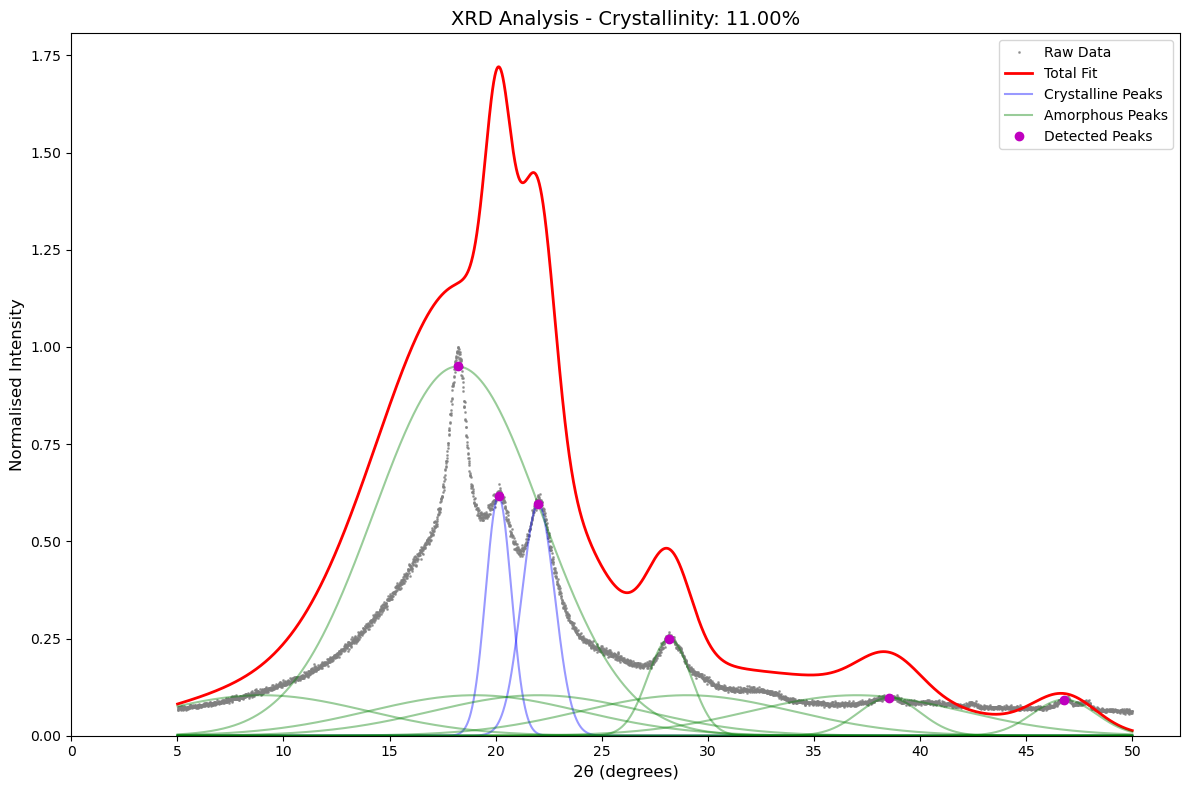

In [47]:
# --- Step 10: Visualization ---
plt.figure(figsize=(12, 8))

# Plot raw data and overall fit
plt.plot(two_theta, normalized_intensity, color='grey', linestyle='None', marker='.', markersize=2, alpha=0.7, label='Raw Data')
plt.plot(two_theta, total_fit, color='red', linestyle='-', label='Total Fit', linewidth=2)

# Plot individual crystalline peaks
for i in range(0, len(crystalline_params), 3):
    amp = crystalline_params[i]
    center = crystalline_params[i+1]
    width = crystalline_params[i+2]
    peak = gaussian(two_theta, amp, center, width)
    plt.plot(two_theta, peak, color='blue', linestyle='-', alpha=0.4, label=f'Crystalline Peaks' if i==0 else "")

# Plot individual amorphous peaks
for i in range(0, len(amorphous_params), 3):
    amp = amorphous_params[i]
    center = amorphous_params[i+1]
    width = amorphous_params[i+2]
    peak = gaussian(two_theta, amp, center, width)
    plt.plot(two_theta, peak, color='green', linestyle='-', alpha=0.4, label=f'Amorphous Peaks' if i==0 else "")

# Mark original detected peaks
plt.plot(two_theta[all_peaks], smoothed_intensity[all_peaks], 'mo', markersize=6, label='Detected Peaks')

plt.xlabel('2θ (degrees)', fontsize=12)
plt.ylabel('Normalised Intensity', fontsize=12)
plt.ylim(bottom=0)
plt.xticks(np.arange(0, 51, 5))
plt.title(f'XRD Analysis - Crystallinity: {crystallinity:.2f}%', fontsize=14)

# Create a cleaner legend with fewer entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)

# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Iteration 2

In [ ]:
def _perform_fitting(two_theta, baseline_corrected_intensity, known_crys_peaks, known_amorp_peaks,
                    min_prominence, height_width_threshold, with_crystalline=True):
    """
    Internal helper function to perform the fitting process.
    This encapsulates the peak detection, fitting and classification logic.
    """
    # --- Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=min_prominence,  
                             width=10,         
                             distance=50)      
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # --- Set Up Initial Guesses ---
    init_guess = []
    
    # Set tolerance for peak matching
    known_peak_tolerance = 1.0  # Tolerance in degrees
    
    # Add known crystalline peaks if in crystalline fitting mode
    if with_crystalline and known_crys_peaks:
        for known_pos in known_crys_peaks:
            # Check if a detected peak is near this position
            nearby_peak_idx = None
            for i, pos in enumerate(peak_positions):
                if abs(pos - known_pos) < known_peak_tolerance:
                    nearby_peak_idx = i
                    break
                    
            if nearby_peak_idx is not None:
                # Use the detected peak's height and estimate width
                height = peak_heights[nearby_peak_idx]
                width = peak_widths_degrees[nearby_peak_idx] if nearby_peak_idx < len(peak_widths_degrees) else 0.5
                init_guess.extend([height, known_pos, width])
            else:
                # No nearby detected peak, estimate parameters based on data at this position
                nearby_idx = np.argmin(np.abs(two_theta - known_pos))
                height_estimate = baseline_corrected_intensity[nearby_idx] * 0.8
                init_guess.extend([height_estimate, known_pos, 0.5])
    
    # Add detected peaks not near known crystalline peaks if in crystalline mode
    if with_crystalline:
        for i, pos in enumerate(peak_positions):
            # Skip if this peak is already accounted for (near a known peak)
            if known_crys_peaks and any(abs(pos - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks):
                continue
                
            # Check if this peak might be overlapping with others
            is_overlapping = False
            for j, other_pos in enumerate(peak_positions):
                if i != j and abs(pos - other_pos) < 1.0:
                    is_overlapping = True
                    break
            
            # Determine appropriate width estimate
            if i < len(peak_widths_degrees):
                width_estimate = peak_widths_degrees[i]
                # Adjust width for overlapping peaks
                if is_overlapping:
                    width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
            else:
                width_estimate = 0.5  # Default if width couldn't be determined
            
            # Add parameters [amplitude, position, width]
            init_guess.extend([peak_heights[i], pos, width_estimate])
    
    # Add amorphous background peaks
    if not known_amorp_peaks:
        # Default amorphous peaks if not specified
        known_amorp_peaks = [20, 30]
        
    num_amorphous_peaks = len(known_amorp_peaks)
    mean_intensity = np.mean(baseline_corrected_intensity)
    
    for pos in known_amorp_peaks:
        init_guess.extend([mean_intensity/2, pos, 5.0]) # amplitude, position, width
    
    # If no components were added at all, add a minimal set
    if len(init_guess) == 0:
        # Add a broad amorphous component
        init_guess.extend([0.5, 25, 10.0])  # amplitude, position, width
        num_amorphous_peaks = 1
    
    # --- Set up boundary constraints ---
    bounds_low = []
    bounds_high = []
    
    # For each parameter triplet in the initial guess
    param_index = 0
    while param_index < len(init_guess):
        amp = init_guess[param_index]
        center = init_guess[param_index + 1]
        width = init_guess[param_index + 2]
        
        # Check if this is likely a crystalline peak based on its width
        is_crystalline = with_crystalline and width < 2.0
        
        if is_crystalline:
            # Crystalline peak bounds
            bounds_low.extend([0, center - 0.5, 0.1])
            bounds_high.extend([np.inf, center + 0.5, 2.0])
        else:
            # Amorphous peak bounds
            bounds_low.extend([0, center - 5, 3.0])
            bounds_high.extend([np.inf, center + 5, 15.0])
            
        param_index += 3
    
    # --- Perform Gaussian Fitting ---
    try:
        popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                              p0=init_guess, bounds=(bounds_low, bounds_high),
                              maxfev=20000)  # Increase maximum function evaluations
    except Exception as e:
        print(f"Fitting error: {str(e)}")
        print("Falling back to initial guess parameters")
        popt = np.array(init_guess)
    
    # --- Separate Components Based on Height-to-Width Ratio ---
    crystalline_params = []
    amorphous_params = []
    
    # Process fitted parameters
    for i in range(0, len(popt), 3):
        if i+2 >= len(popt):  # Safety check
            break
            
        amp = popt[i]
        center = popt[i+1]
        width = popt[i+2]
        hw_ratio = amp / width if width > 0 else 0  # Height-to-width ratio
        
        # Skip peaks with near-zero amplitude
        if amp < 0.001:
            continue
        
        # Check if this matches a known crystalline peak position
        is_known_crys_pos = False
        if known_crys_peaks:
            is_known_crys_pos = any(abs(center - known_pos) < known_peak_tolerance 
                                  for known_pos in known_crys_peaks)
        
        # Classify peak - consider both ratio and position
        if with_crystalline and (is_known_crys_pos or hw_ratio > height_width_threshold) and width < 2.0:
            # This is likely a crystalline peak
            crystalline_params.extend([amp, center, width])
        else:
            # This is likely an amorphous peak
            amorphous_params.extend([amp, center, width])
    
    # --- Calculate Individual Components ---
    crystalline_fit = multi_gaussian(two_theta, *crystalline_params) if crystalline_params else np.zeros_like(two_theta)
    amorphous_fit = multi_gaussian(two_theta, *amorphous_params) if amorphous_params else np.zeros_like(two_theta)
    total_fit = crystalline_fit + amorphous_fit
    
    # --- Calculate Crystallinity Index ---
    area_crystalline = np.trapz(crystalline_fit, two_theta)
    area_amorphous = np.trapz(amorphous_fit, two_theta)
    area_total = area_crystalline + area_amorphous
    
    if area_total > 0:
        crystallinity = (area_crystalline / area_total) * 100
    else:
        crystallinity = 0.0
    
    # --- Calculate Goodness of Fit ---
    residuals = baseline_corrected_intensity - total_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((baseline_corrected_intensity - np.mean(baseline_corrected_intensity))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    rmse = np.sqrt(np.mean(residuals**2))
    
    # Return fitting results
    results = {
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'optimized_parameters': popt,
        'crystalline_params': crystalline_params,
        'amorphous_params': amorphous_params,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'total_fit': total_fit,
        'crystallinity': crystallinity,
        'r_squared': r_squared,
        'rmse': rmse,
        'residuals': residuals
    }
    
    return results

In [136]:
def fit_xrd_spectrum(two_theta, intensity, known_crys_peaks=None, known_amorp_peaks=None, 
                     height_width_threshold=0.2, min_prominence=0.008, 
                     min_r_squared=0.85, visualise=True):
    """
    Adaptive XRD analysis function with streamlined visualization:
    1. Combined crystalline+amorphous fit
    2. Try individual crystalline peaks with amorphous background
    3. Fall back to amorphous-only fit
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    intensity : array-like
        Array of corresponding intensity values
    known_crys_peaks : list or None, optional
        List of known crystalline peak positions from literature
    known_amorp_peaks : list or None, optional
        List of known amorphous peak positions
    height_width_threshold : float, default=0.2
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    min_prominence : float, default=0.008
        Minimum prominence for peak detection
    min_r_squared : float, default=0.85
        Minimum R² value for considering a fit successful
    visualise : bool, default=True
        Whether to generate visualization plots
        
    Returns:
    --------
    dict
        Dictionary containing peak information, fitted parameters, and crystallinity
    """
    # Set default values if None is provided
    if known_crys_peaks is None:
        known_crys_peaks = []  
        
    if known_amorp_peaks is None:
        known_amorp_peaks = []
    
    # --- Step 1: Data Preprocessing ---
    # Normalize intensity
    normalized_intensity = intensity / np.max(intensity)
    
    # Smooth the normalized data
    smoothed_intensity = savgol_filter(normalized_intensity, window_length=15, polyorder=3)
    
    # --- Step 2: Baseline Correction ---
    # Method: Find the minimum value of smoothed intensity as baseline level
    baseline_level = np.min(smoothed_intensity)
    
    # Subtract baseline level from smoothed intensity
    baseline_corrected_intensity = smoothed_intensity - baseline_level
    
    # Ensure no negative values
    baseline_corrected_intensity = np.maximum(baseline_corrected_intensity, 0)
    
    # Renormalize after baseline correction
    if np.max(baseline_corrected_intensity) > 0:
        baseline_corrected_intensity = baseline_corrected_intensity / np.max(baseline_corrected_intensity)
    
    # --- Step 3: Assess Signal Quality ---
    # Calculate signal-to-noise ratio
    signal_mean = np.mean(baseline_corrected_intensity)
    noise_estimate = np.std(baseline_corrected_intensity - 
                           savgol_filter(baseline_corrected_intensity, window_length=21, polyorder=3))
    snr = signal_mean / noise_estimate if noise_estimate > 0 else 0
    
    # Adjust peak detection parameters based on signal quality
    adjusted_min_prominence = min_prominence
    if snr < 5:  # Low SNR
        print(f"Low signal-to-noise ratio detected ({snr:.2f}). Adjusting detection parameters.")
        adjusted_min_prominence = min_prominence * 1.5  # Increase prominence threshold for noisy data
    
    # Check if data has any significant peaks at all
    max_peak_height = np.max(baseline_corrected_intensity)
    is_mostly_amorphous = max_peak_height < 0.1  # Very low peak height suggests mostly amorphous
    
    if is_mostly_amorphous:
        print("Sample appears to be predominantly amorphous.")
    
    # --- Step 4: Define Gaussian Functions ---
    def gaussian(x, A, x0, sigma):
        """Gaussian function with parameters amplitude, center, and width"""
        return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
    
    def multi_gaussian(x, *params):
        """Fit multiple Gaussian peaks simultaneously"""
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)
        for i in range(num_peaks):
            amp = params[3*i]
            center = params[3*i+1]
            width = params[3*i+2]
            y_fit += gaussian(x, amp, center, width)
        return y_fit
    
    # --- Step 5: Run Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=adjusted_min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=adjusted_min_prominence,  
                             width=10,         
                             distance=50)      
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=adjusted_min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # --- Step 6: Run Multi-Phase Fitting Strategy ---
    fitting_results = []
    phase_success = {"phase1": False, "phase2": False, "phase3": False}
    
    # PHASE 1: Try fitting with combined crystalline and amorphous components
    if not is_mostly_amorphous or known_crys_peaks:
        try:
            print("Phase 1: Attempting fit with all crystalline + amorphous components...")
            phase1_results = _perform_fitting(two_theta, baseline_corrected_intensity, 
                                           known_crys_peaks, known_amorp_peaks,
                                           adjusted_min_prominence, height_width_threshold)
            
            # Check if fit is acceptable
            if phase1_results['r_squared'] >= min_r_squared:
                print(f"Phase 1: SUCCESSFUL with R² = {phase1_results['r_squared']:.4f}")
                fitting_results.append(("Combined (All Peaks)", phase1_results))
                phase_success["phase1"] = True
            else:
                print(f"Phase 1: FAILED - R² = {phase1_results['r_squared']:.4f} < {min_r_squared:.4f}")
                
        except Exception as e:
            print(f"Phase 1: ERROR - {str(e)}")
    else:
        print("Phase 1: SKIPPED for predominantly amorphous sample")
    
    # PHASE 2: Only if Phase 1 didn't produce a good fit, try individual crystalline peaks
    if known_crys_peaks and not phase_success["phase1"]:
        print(f"Phase 2: Testing each known crystalline peak individually...")
        
        # Track if any individual peak fits were successful
        any_single_peak_success = False
        best_single_peak_fit = None
        best_single_peak_name = None
        best_single_peak_r2 = 0
        
        for idx, peak_pos in enumerate(known_crys_peaks):
            try:
                peak_name = f"Peak at {peak_pos}°"
                print(f"  Testing {peak_name}...")
                
                # Try fitting with just this one crystalline peak + amorphous
                single_peak_results = _perform_fitting(two_theta, baseline_corrected_intensity, 
                                                    [peak_pos], known_amorp_peaks,
                                                    adjusted_min_prominence, height_width_threshold)
                
                # Consider the fit successful if crystallinity > 0 AND R² is acceptable
                if single_peak_results['crystallinity'] > 0:
                    # Track best individual peak fit
                    if single_peak_results['r_squared'] > best_single_peak_r2:
                        best_single_peak_r2 = single_peak_results['r_squared']
                        best_single_peak_fit = single_peak_results
                        best_single_peak_name = f"Single Peak {peak_pos}°"
                    
                    if single_peak_results['r_squared'] >= min_r_squared:
                        print(f"  {peak_name}: SUCCESSFUL - R² = {single_peak_results['r_squared']:.4f}, "
                              f"Crystallinity = {single_peak_results['crystallinity']:.2f}%")
                        
                        fitting_results.append((f"Single Peak {peak_pos}°", single_peak_results))
                        any_single_peak_success = True
                    else:
                        print(f"  {peak_name}: DETECTED but R² = {single_peak_results['r_squared']:.4f} < {min_r_squared:.4f}")
                else:
                    print(f"  {peak_name}: FAILED - Not detected as crystalline")
                    
            except Exception as e:
                print(f"  {peak_name}: ERROR - {str(e)}")
        
        # Add best single peak fit even if it didn't meet R² threshold
        if best_single_peak_fit is not None and not any_single_peak_success:
            fitting_results.append((best_single_peak_name, best_single_peak_fit))
            print(f"  Added best single peak fit ({best_single_peak_name}) with R² = {best_single_peak_r2:.4f}")
        
        # Update phase success based on any successful single peak fit
        phase_success["phase2"] = any_single_peak_success
        if any_single_peak_success:
            print(f"Phase 2: SUCCESSFUL - At least one crystalline peak was successfully fitted")
        else:
            print(f"Phase 2: FAILED - No individual crystalline peaks met R² threshold")
    else:
        if phase_success["phase1"]:
            print("Phase 2: SKIPPED - Phase 1 was successful")
        else:
            print("Phase 2: SKIPPED - No known crystalline peaks provided")
    
    # PHASE 3: If no successful fits from previous phases, try amorphous-only model
    if not phase_success["phase1"] and not phase_success["phase2"]:
        try:
            print("Phase 3: Attempting amorphous-only fit...")
            # Use default amorphous positions if none provided
            default_amorp_pos = [20, 30] if not known_amorp_peaks else known_amorp_peaks
            
            phase3_results = _perform_fitting(two_theta, baseline_corrected_intensity, 
                                           [], default_amorp_pos,
                                           adjusted_min_prominence, height_width_threshold,
                                           with_crystalline=False)
            
            # Check if amorphous fit is acceptable
            if phase3_results['r_squared'] >= min_r_squared:
                print(f"Phase 3: SUCCESSFUL - R² = {phase3_results['r_squared']:.4f}")
                fitting_results.append(("Amorphous Only", phase3_results))
                phase_success["phase3"] = True
            else:
                print(f"Phase 3: FAILED - R² = {phase3_results['r_squared']:.4f} < {min_r_squared:.4f}")
                # Still add to results even if below threshold (it's our last resort)
                fitting_results.append(("Amorphous Only", phase3_results))
            
        except Exception as e:
            print(f"Phase 3: ERROR - {str(e)}")
    else:
        print("Phase 3: SKIPPED - Previous phase was successful")
    
    # Select best fit result based on R²
    if not fitting_results:
        raise RuntimeError("All fitting attempts failed.")
        
    # Sort by R-squared (descending)
    fitting_results.sort(key=lambda x: x[1]['r_squared'], reverse=True)
    best_fit_name, best_fit = fitting_results[0]
    
    print(f"Selected {best_fit_name} model with R² = {best_fit['r_squared']:.4f}")
    
    # --- Step 7: Visualization (Streamlined) ---
    if visualise:
        # Create a 2-panel figure: Peak Detection + Best Fit
        plt.figure(figsize=(12, 9))
        
        # Panel 1: Peak Detection Results
        plt.subplot(2, 1, 1)
        plt.plot(two_theta, baseline_corrected_intensity, 'b-', label='Baseline Corrected')
        plt.plot(two_theta[major_peaks], baseline_corrected_intensity[major_peaks], 'ro', 
                label='Major Peaks', markersize=8)
        plt.plot(two_theta[all_peaks], baseline_corrected_intensity[all_peaks], 'go', 
                label='All Detected Peaks', markersize=6)
        
        # Mark known crystalline peaks
        if known_crys_peaks:
            for pos in known_crys_peaks:
                plt.axvline(x=pos, color='blue', linestyle='--', alpha=0.5, 
                           label='Known Crystalline' if pos==known_crys_peaks[0] else "")
        
        # Mark known amorphous peaks if provided
        if known_amorp_peaks:
            for pos in known_amorp_peaks:
                plt.axvline(x=pos, color='purple', linestyle=':', alpha=0.5,
                           label='Known Amorphous' if pos==known_amorp_peaks[0] else "")
                
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.title(f'XRD Peak Detection Results (SNR: {snr:.2f})', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Panel 2: Best Fit Model
        plt.subplot(2, 1, 2)
        
        # Plot raw data and overall fit
        plt.plot(two_theta, baseline_corrected_intensity, 'k-', alpha=0.7, 
                 label='Baseline Corrected Data')
        plt.plot(two_theta, best_fit['total_fit'], 'r-', 
                 label='Total Fit', linewidth=2)
        
        # Plot components
        if best_fit['crystalline_fit'].any():
            plt.plot(two_theta, best_fit['crystalline_fit'], 'b-', 
                     label='Crystalline Component', linewidth=1.5)
        
        plt.plot(two_theta, best_fit['amorphous_fit'], 'g-', 
                 label='Amorphous Component', linewidth=1.5)

        # Plot individual peaks
        crystalline_params = best_fit['crystalline_params']
        amorphous_params = best_fit['amorphous_params']
        
        for j in range(0, len(crystalline_params), 3):
            amp = crystalline_params[j]
            center = crystalline_params[j+1]
            width = crystalline_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'b--', alpha=0.4)

        for j in range(0, len(amorphous_params), 3):
            amp = amorphous_params[j]
            center = amorphous_params[j+1]
            width = amorphous_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'g--', alpha=0.4)

        # Add best fit phase success information
        phase_info = ""
        if phase_success["phase1"]:
            phase_info = "Phase 1: Combined Fit"
        elif phase_success["phase2"]:
            phase_info = "Phase 2: Individual Peak(s)"
        elif phase_success["phase3"]:
            phase_info = "Phase 3: Amorphous-Only"
        else:
            phase_info = "No phase met R² threshold"
            
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.ylim(bottom=0)
        plt.xlim(left=min(two_theta), right=max(two_theta))
        
        # Display model metrics
        cryst = best_fit['crystallinity']
        r2 = best_fit['r_squared']
        plt.title(f'Best Fit: {best_fit_name} - {phase_info}\n'
                  f'Crystallinity: {cryst:.2f}% - R²: {r2:.4f}', 
                  fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # --- Step 8: Return Best Fit Results ---
    # Add additional information to the best fit results
    best_fit.update({
        'normalized_intensity': normalized_intensity,
        'smoothed_intensity': smoothed_intensity,
        'baseline_level': baseline_level,
        'baseline_corrected_intensity': baseline_corrected_intensity,
        'signal_to_noise': snr,
        'is_mostly_amorphous': is_mostly_amorphous,
        'phase_success': phase_success,
        'fitting_attempts': [name for name, _ in fitting_results],
        'all_models': {name: {'r_squared': res['r_squared'], 'crystallinity': res['crystallinity']} 
                      for name, res in fitting_results},
        'selected_model': best_fit_name,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'all_peaks': all_peaks,
        'major_peaks': major_peaks,
        'gaussian_function': gaussian,
        'multi_gaussian_function': multi_gaussian
    })
    
    return best_fit

Processing file: 500907.csv
Phase 1: Attempting fit with all crystalline + amorphous components...
Phase 1: SUCCESSFUL with R² = 0.9987
Phase 2: SKIPPED - Phase 1 was successful
Phase 3: SKIPPED - Previous phase was successful
Selected Combined (All Peaks) model with R² = 0.9987


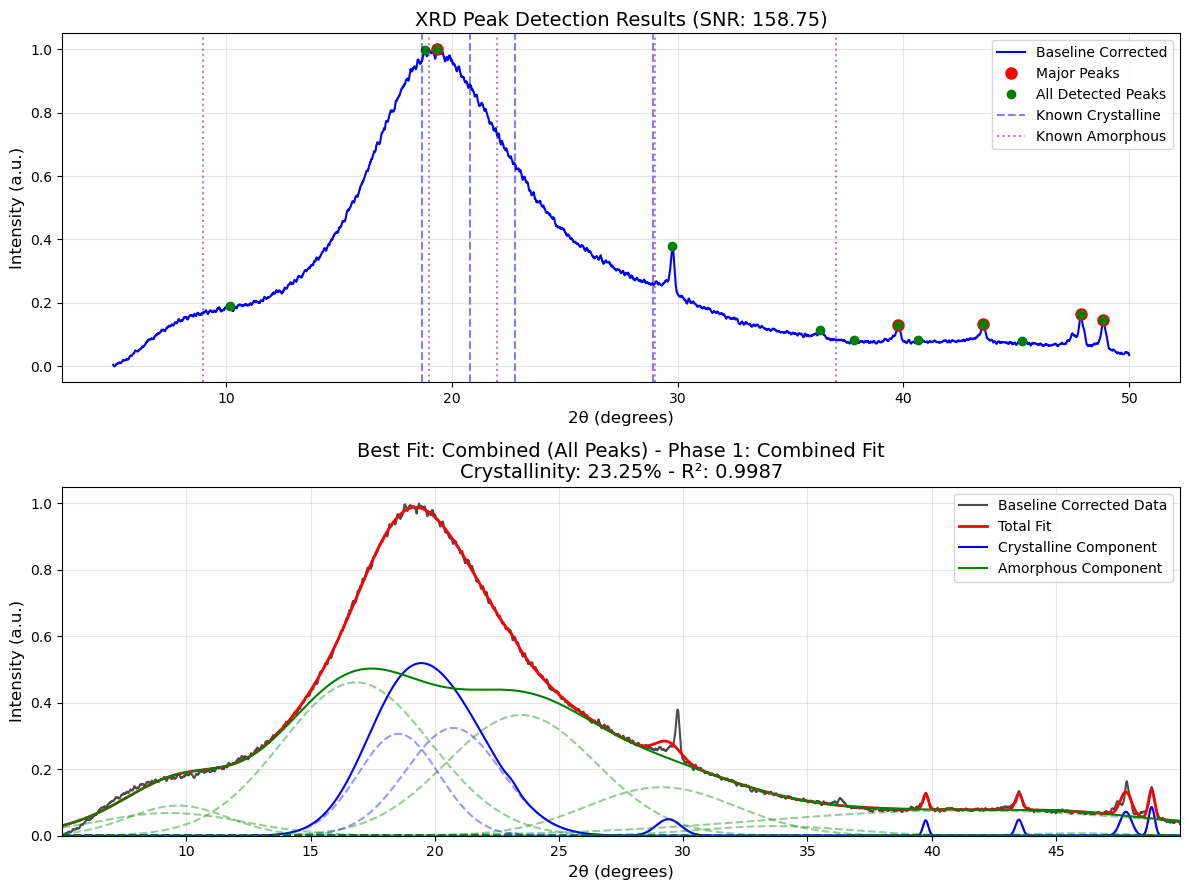

Processing file: 500907_2.csv
Phase 1: Attempting fit with all crystalline + amorphous components...
Phase 1: SUCCESSFUL with R² = 0.9998
Phase 2: SKIPPED - Phase 1 was successful
Phase 3: SKIPPED - Previous phase was successful
Selected Combined (All Peaks) model with R² = 0.9998


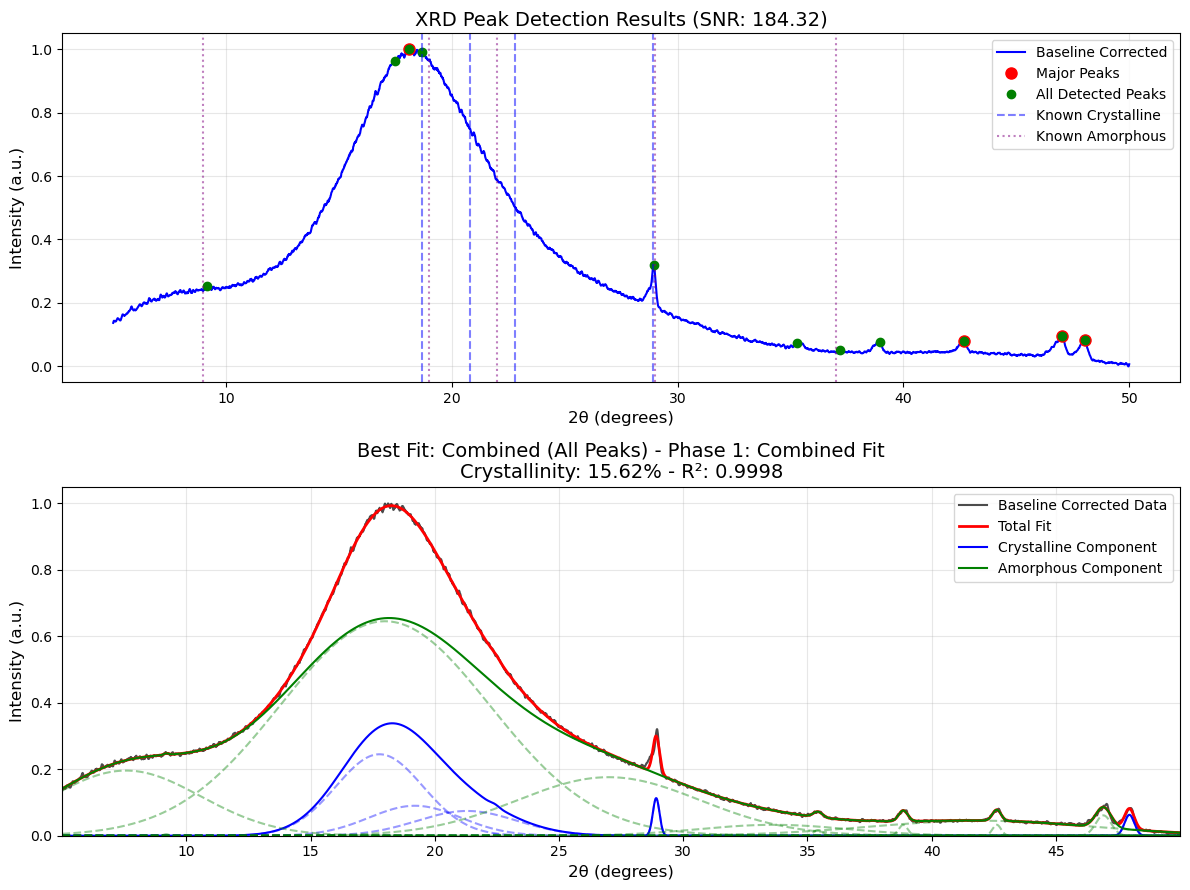

Processing file: 501023.csv
Phase 1: Attempting fit with all crystalline + amorphous components...
Phase 1: FAILED - R² = 0.9562 < 0.9800
Phase 2: Testing each known crystalline peak individually...
  Testing Peak at 18.7°...
  Peak at 18.7°: DETECTED but R² = 0.9567 < 0.9800
  Testing Peak at 20.8°...
  Peak at 20.8°: DETECTED but R² = 0.9567 < 0.9800
  Testing Peak at 22.8°...
  Peak at 22.8°: DETECTED but R² = 0.9563 < 0.9800
  Testing Peak at 28.9°...
  Peak at 28.9°: DETECTED but R² = 0.9566 < 0.9800
  Added best single peak fit (Single Peak 18.7°) with R² = 0.9567
Phase 2: FAILED - No individual crystalline peaks met R² threshold
Phase 3: Attempting amorphous-only fit...
Phase 3: FAILED - R² = 0.9418 < 0.9800
Selected Single Peak 18.7° model with R² = 0.9567


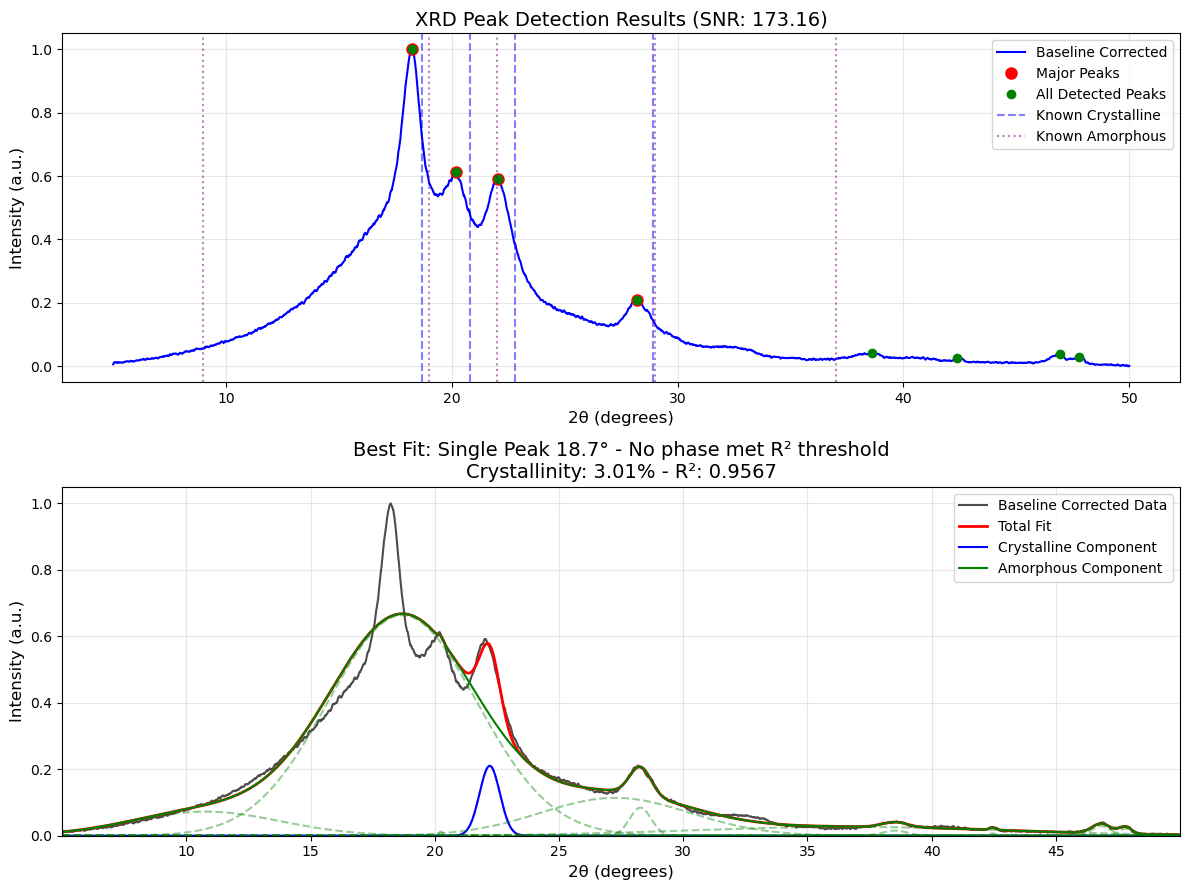

Processing file: 501023_2.csv
Phase 1: Attempting fit with all crystalline + amorphous components...
Phase 1: SUCCESSFUL with R² = 0.9992
Phase 2: SKIPPED - Phase 1 was successful
Phase 3: SKIPPED - Previous phase was successful
Selected Combined (All Peaks) model with R² = 0.9992


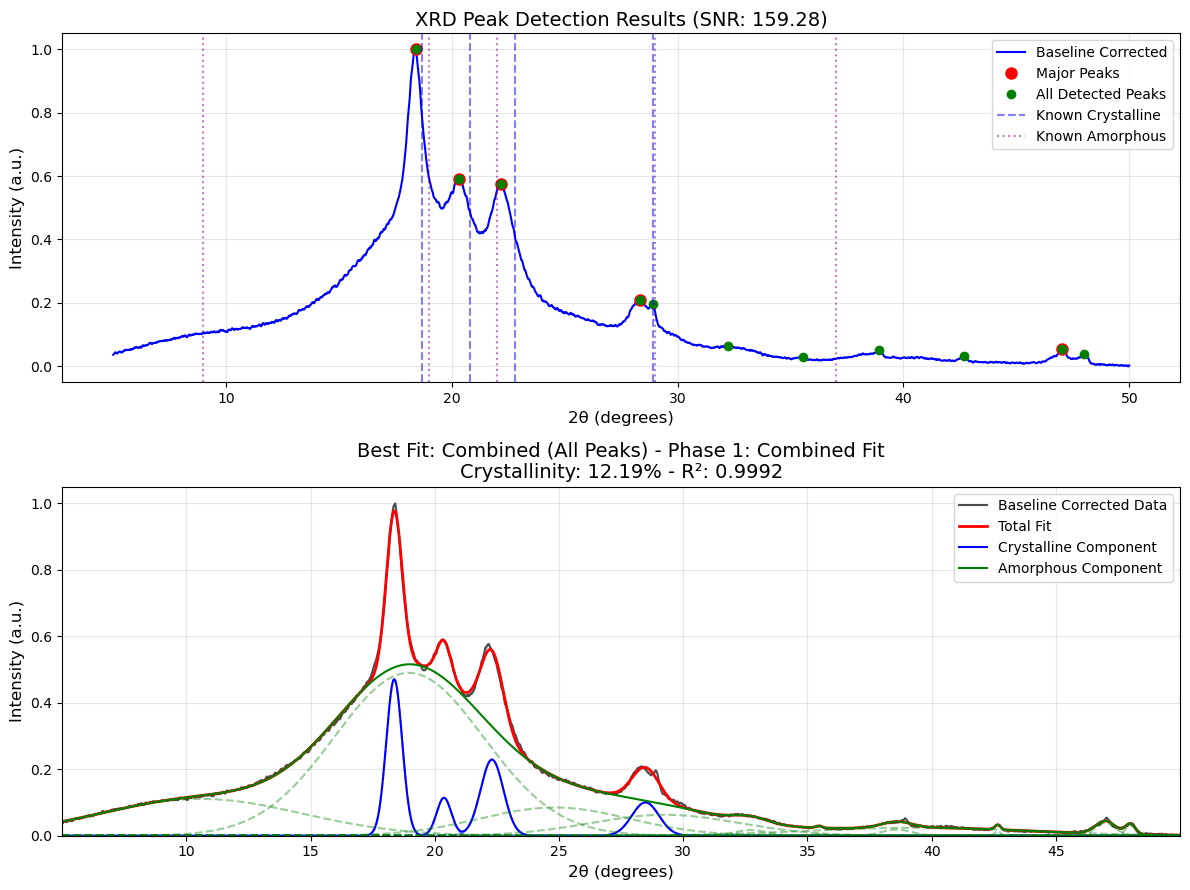

Processing file: 501024.csv
Phase 1: Attempting fit with all crystalline + amorphous components...
Phase 1: SUCCESSFUL with R² = 0.9989
Phase 2: SKIPPED - Phase 1 was successful
Phase 3: SKIPPED - Previous phase was successful
Selected Combined (All Peaks) model with R² = 0.9989


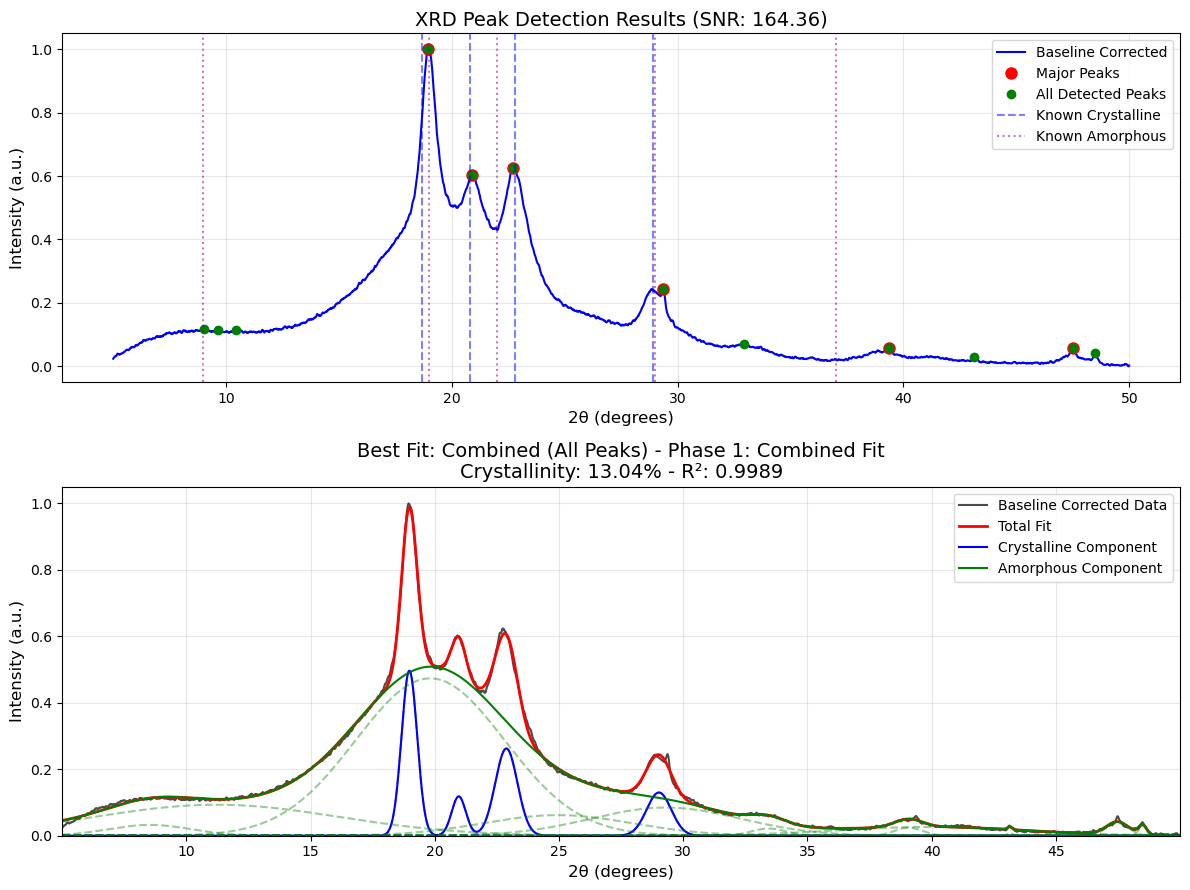

Processing file: 501024_2.csv
Phase 1: Attempting fit with all crystalline + amorphous components...
Phase 1: SUCCESSFUL with R² = 0.9991
Phase 2: SKIPPED - Phase 1 was successful
Phase 3: SKIPPED - Previous phase was successful
Selected Combined (All Peaks) model with R² = 0.9991


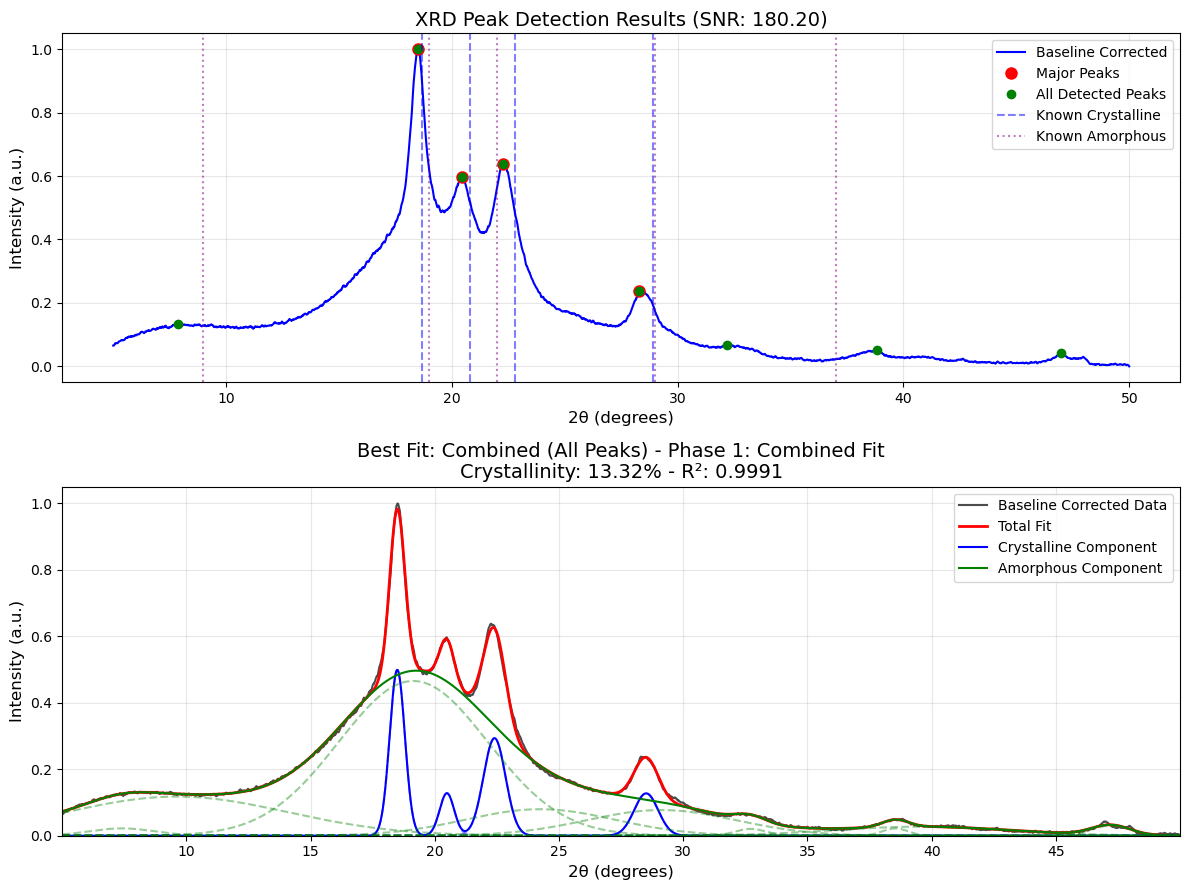

Processing file: HDPE.csv
Phase 1: Attempting fit with all crystalline + amorphous components...
Phase 1: SUCCESSFUL with R² = 0.9806
Phase 2: SKIPPED - Phase 1 was successful
Phase 3: SKIPPED - Previous phase was successful
Selected Combined (All Peaks) model with R² = 0.9806


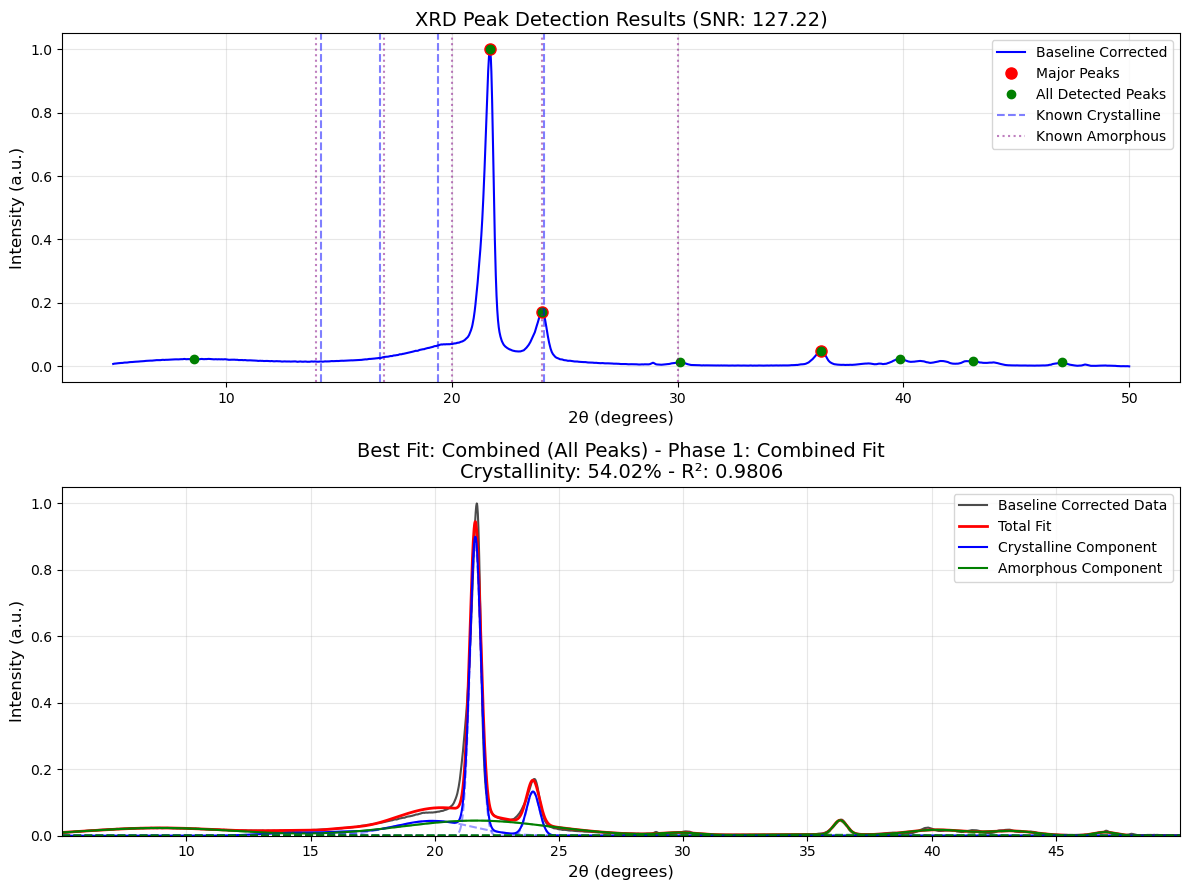

Processing file: HDPE_2.csv
Phase 1: Attempting fit with all crystalline + amorphous components...
Phase 1: FAILED - R² = 0.9740 < 0.9800
Phase 2: Testing each known crystalline peak individually...
  Testing Peak at 14.2°...
  Peak at 14.2°: DETECTED but R² = 0.9732 < 0.9800
  Testing Peak at 16.8°...
  Peak at 16.8°: DETECTED but R² = 0.9732 < 0.9800
  Testing Peak at 19.4°...
  Peak at 19.4°: DETECTED but R² = 0.9739 < 0.9800
  Testing Peak at 24.1°...
  Peak at 24.1°: DETECTED but R² = 0.9732 < 0.9800
  Added best single peak fit (Single Peak 19.4°) with R² = 0.9739
Phase 2: FAILED - No individual crystalline peaks met R² threshold
Phase 3: Attempting amorphous-only fit...
Phase 3: FAILED - R² = 0.2892 < 0.9800
Selected Single Peak 19.4° model with R² = 0.9739


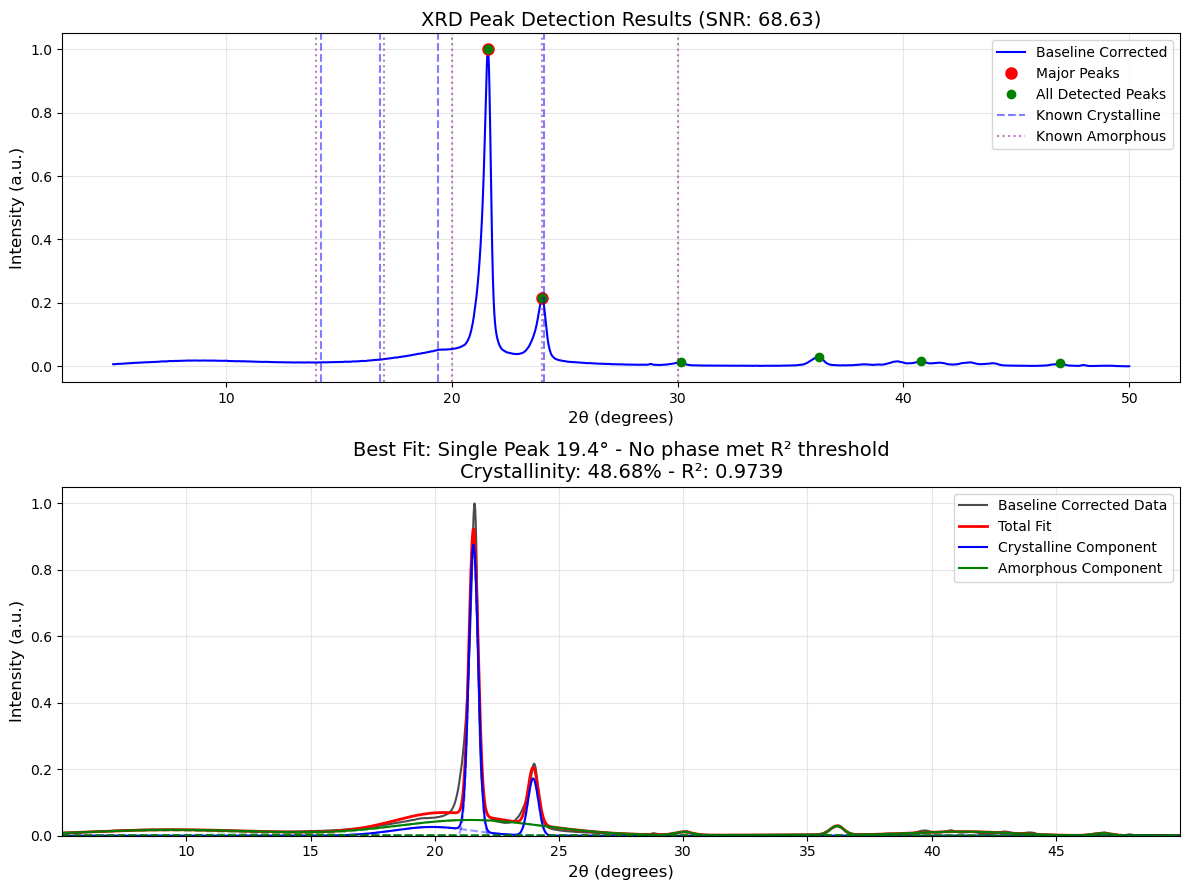

In [ ]:
known_crys_peaks_dict = {
    'PEEK': [18.7, 20.8, 22.8, 28.9],
    'HDPE': [21.5, 23.9, 36.2]  #  (110), (200), (020)
}

known_amorp_peaks_dict = {
    'PEEK': [9, 19, 22, 29, 37],
    'HDPE': [14, 17, 20, 24, 30]
}

cryst_dict = {}
for file in all_files:
    print(f"Processing file: {file}")
    if 'HDPE' in file:
        polymer = 'HDPE'
    else:
        polymer = 'PEEK'
    data = df_dict[file]
    intensity = data['Intensity_norm'].values
    two_theta = data['2Theta'].values
    
    results = fit_xrd_spectrum(two_theta, intensity, 
                               known_crys_peaks=known_crys_peaks_dict.get(polymer, None),
                               known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
                               height_width_threshold=0.2, min_r_squared=0.98, 
                               visualise=True)
    
    cryst_dict[file] = results['crystallinity']

#### Iteration 3

Strategy Analysis:
1. Start with Amorphous-Only Fit (Phase 1)
    - ✅ Efficiency: Establishes a baseline fit with minimal parameters
    - ✅ Advantage: Quickly identifies purely amorphous samples
    - ✅ Logic: If this succeeds with high R², sample may be entirely amorphous

2. Individual Crystalline Peak Testing (Phase 2)
    - ✅ Targeted approach: Tests each known crystalline peak independently
    - ✅ Advantage: Identifies which specific crystalline peaks are actually present
    - ✅ Efficiency: Avoids fitting peaks that don't exist in the sample

3. Combined Final Fit (Phase 3)
    - ✅ Smart parameter reduction: Only includes crystalline peaks detected in Phase 2
    - ✅ Better accuracy: Avoids overfitting with non-existent peaks
    - ✅ Completeness: Provides a final unified model with all components


Suggested Refinements:
1. Adaptive R² Thresholds
    - Use a slightly lower threshold for the amorphous fit compared to the final fit
    - This prevents rejecting the amorphous model too quickly for low crystallinity samples

2. Signal-to-Noise Ratio Consideration
    - Incorporate the SNR into your decision making
    - For very noisy data, be more conservative about adding crystalline peaks
3. Use Bayesian Information Criterion (BIC)
    - Consider using BIC to compare models with different numbers of parameters
    - Helps balance fit quality against model complexity

In [21]:
def _perform_fitting(two_theta, baseline_corrected_intensity, known_crys_peaks, known_amorp_peaks,
                    min_prominence, height_width_threshold, with_crystalline=True):
    """
    Internal helper function to perform the XRD spectrum fitting process.
    This encapsulates the peak detection, fitting and classification logic.
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    baseline_corrected_intensity : array-like
        Baseline-corrected and normalized intensity values
    known_crys_peaks : list
        List of known crystalline peak positions from literature
    known_amorp_peaks : list
        List of known amorphous peak positions
    min_prominence : float
        Minimum prominence for peak detection
    height_width_threshold : float
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    with_crystalline : bool, default=True
        Whether to include crystalline components in the fit
        
    Returns:
    --------
    dict
        Dictionary containing fitting results, parameters and metrics
    """
    # --- Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=min_prominence,  
                             width=10,
                             distance=50)
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # --- Set Up Initial Guesses ---
    init_guess = []
    
    # Set tolerance for peak matching
    known_peak_tolerance = 1.0  # Tolerance in degrees
    
    # Add known crystalline peaks if in crystalline fitting mode
    if with_crystalline and known_crys_peaks:
        for known_pos in known_crys_peaks:
            # Check if a detected peak is near this position
            nearby_peak_idx = None
            for i, pos in enumerate(peak_positions):
                if abs(pos - known_pos) < known_peak_tolerance:
                    nearby_peak_idx = i
                    break
                    
            if nearby_peak_idx is not None:
                # Use the detected peak's height and estimate width
                height = peak_heights[nearby_peak_idx]
                width = peak_widths_degrees[nearby_peak_idx] if nearby_peak_idx < len(peak_widths_degrees) else 0.5
                init_guess.extend([height, known_pos, width])
            else:
                # No nearby detected peak, estimate parameters based on data at this position
                nearby_idx = np.argmin(np.abs(two_theta - known_pos))
                height_estimate = baseline_corrected_intensity[nearby_idx] * 0.8
                init_guess.extend([height_estimate, known_pos, 0.5])
    
    # Add detected peaks not near known crystalline peaks if in crystalline mode
    if with_crystalline:
        for i, pos in enumerate(peak_positions):
            # Skip if this peak is already accounted for (near a known peak)
            if known_crys_peaks and any(abs(pos - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks):
                continue
                
            # Check if this peak might be overlapping with others
            is_overlapping = False
            for j, other_pos in enumerate(peak_positions):
                if i != j and abs(pos - other_pos) < 1.0:
                    is_overlapping = True
                    break
            
            # Determine appropriate width estimate
            if i < len(peak_widths_degrees):
                width_estimate = peak_widths_degrees[i]
                # Adjust width for overlapping peaks
                if is_overlapping:
                    width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
            else:
                width_estimate = 0.5  # Default if width couldn't be determined
            
            # Add parameters [amplitude, position, width]
            init_guess.extend([peak_heights[i], pos, width_estimate])
    
    # Add amorphous background peaks
    if not known_amorp_peaks:
        # Default amorphous peaks if not specified
        known_amorp_peaks = [20, 30]
        
    num_amorphous_peaks = len(known_amorp_peaks)
    mean_intensity = np.mean(baseline_corrected_intensity)
    
    for pos in known_amorp_peaks:
        init_guess.extend([mean_intensity/2, pos, 5.0])  # amplitude, position, width
    
    # If no components were added at all, add a minimal set
    if len(init_guess) == 0:
        # Add a broad amorphous component
        init_guess.extend([0.5, 25, 10.0])  # amplitude, position, width
        num_amorphous_peaks = 1
    
    # --- Set up boundary constraints ---
    bounds_low = []
    bounds_high = []
    
    # For each parameter triplet in the initial guess
    param_index = 0
    while param_index < len(init_guess):
        amp = init_guess[param_index]
        center = init_guess[param_index + 1]
        width = init_guess[param_index + 2]
        
        # Check if this is likely a crystalline peak based on its width or if it's a known crystalline position
        is_crystalline = False
        if with_crystalline:
            if width < 2.0:  # Width-based classification
                is_crystalline = True
            elif known_crys_peaks:  # Position-based classification
                is_crystalline = any(abs(center - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks)
        
        if is_crystalline:
            # Crystalline peak bounds
            bounds_low.extend([0, center - 0.5, 0.1])
            bounds_high.extend([np.inf, center + 0.5, 2.0])
        else:
            # Amorphous peak bounds
            bounds_low.extend([0, center - 5, 3.0])
            bounds_high.extend([np.inf, center + 5, 15.0])
            
        param_index += 3
    
    # --- Perform Gaussian Fitting ---
    try:
        # Define Gaussian function for fitting
        def gaussian(x, A, x0, sigma):
            """Gaussian function with parameters amplitude, center, and width"""
            return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
        
        def multi_gaussian(x, *params):
            """Fit multiple Gaussian peaks simultaneously"""
            num_peaks = len(params) // 3
            y_fit = np.zeros_like(x)
            for i in range(num_peaks):
                amp = params[3*i]
                center = params[3*i+1]
                width = params[3*i+2]
                y_fit += gaussian(x, amp, center, width)
            return y_fit
        
        # Perform the fit
        popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                              p0=init_guess, bounds=(bounds_low, bounds_high),
                              maxfev=20000)  # Increase maximum function evaluations
    except Exception as e:
        print(f"Fitting error: {str(e)}")
        print("Falling back to initial guess parameters")
        popt = np.array(init_guess)
    
    # --- Separate Components Based on Height-to-Width Ratio ---
    crystalline_params = []
    amorphous_params = []
    
    # Process fitted parameters
    for i in range(0, len(popt), 3):
        if i+2 >= len(popt):  # Safety check
            break
            
        amp = popt[i]
        center = popt[i+1]
        width = popt[i+2]
        hw_ratio = amp / width if width > 0 else 0  # Height-to-width ratio
        
        # Skip peaks with near-zero amplitude
        if amp < 0.001:
            continue
        
        # Check if this matches a known crystalline peak position
        is_known_crys_pos = False
        if known_crys_peaks and with_crystalline:
            is_known_crys_pos = any(abs(center - known_pos) < known_peak_tolerance 
                                  for known_pos in known_crys_peaks)
        
        # Classify peak - consider both ratio and position
        if with_crystalline and (is_known_crys_pos or hw_ratio > height_width_threshold) and width < 2.0:
            # This is likely a crystalline peak
            crystalline_params.extend([amp, center, width])
        else:
            # This is likely an amorphous peak
            amorphous_params.extend([amp, center, width])
    
    # --- Calculate Individual Components ---
    crystalline_fit = np.zeros_like(two_theta)
    if crystalline_params:
        crystalline_fit = multi_gaussian(two_theta, *crystalline_params)
        
    amorphous_fit = np.zeros_like(two_theta)
    if amorphous_params:
        amorphous_fit = multi_gaussian(two_theta, *amorphous_params)
        
    total_fit = crystalline_fit + amorphous_fit
    
    # --- Calculate Crystallinity Index ---
    area_crystalline = np.trapz(crystalline_fit, two_theta)
    area_amorphous = np.trapz(amorphous_fit, two_theta)
    area_total = area_crystalline + area_amorphous
    
    if area_total > 0:
        crystallinity = (area_crystalline / area_total) * 100
    else:
        crystallinity = 0.0
    
    # --- Calculate Goodness of Fit ---
    residuals = baseline_corrected_intensity - total_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((baseline_corrected_intensity - np.mean(baseline_corrected_intensity))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    rmse = np.sqrt(np.mean(residuals**2))
    
    # --- Organize fitted peaks for reporting ---
    crystalline_peak_data = []
    for i in range(0, len(crystalline_params), 3):
        if i+2 >= len(crystalline_params):
            break
        crystalline_peak_data.append({
            'amplitude': crystalline_params[i],
            'position': crystalline_params[i+1], 
            'width': crystalline_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     crystalline_params[i], 
                                     crystalline_params[i+1], 
                                     crystalline_params[i+2]), 
                            two_theta)
        })
    
    amorphous_peak_data = []
    for i in range(0, len(amorphous_params), 3):
        if i+2 >= len(amorphous_params):
            break
        amorphous_peak_data.append({
            'amplitude': amorphous_params[i],
            'position': amorphous_params[i+1], 
            'width': amorphous_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     amorphous_params[i], 
                                     amorphous_params[i+1], 
                                     amorphous_params[i+2]), 
                            two_theta)
        })
    
    # Return fitting results
    results = {
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'optimized_parameters': popt,
        'crystalline_params': crystalline_params,
        'amorphous_params': amorphous_params,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'total_fit': total_fit,
        'crystallinity': crystallinity,
        'r_squared': r_squared,
        'rmse': rmse,
        'residuals': residuals,
        'crystalline_peak_data': crystalline_peak_data,
        'amorphous_peak_data': amorphous_peak_data
    }
    
    return results

In [22]:
def fit_xrd_spectrum(two_theta, intensity, known_crys_peaks=None, known_amorp_peaks=None, 
                     height_width_threshold=0.2, min_prominence=0.008, 
                     min_r_squared=0.85, amorphous_r_squared=0.80, visualise=True):
    """
    Efficient XRD analysis function using a build-up strategy:
    1. Start with amorphous-only fit
    2. Test individual crystalline peaks for significance
    3. Combine successful crystalline peaks for final model
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    intensity : array-like
        Array of corresponding intensity values
    known_crys_peaks : list or None, optional
        List of known crystalline peak positions from literature
    known_amorp_peaks : list or None, optional
        List of known amorphous peak positions
    height_width_threshold : float, default=0.2
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    min_prominence : float, default=0.008
        Minimum prominence for peak detection
    min_r_squared : float, default=0.85
        Minimum R² value for considering a fit successful
    amorphous_r_squared : float, default=0.80
        Lower threshold for amorphous-only fit acceptability
    visualise : bool, default=True
        Whether to generate visualization plots
        
    Returns:
    --------
    dict
        Dictionary containing peak information, fitted parameters, and crystallinity
    """
    # Set default values if None is provided
    if known_crys_peaks is None:
        known_crys_peaks = []  
        
    if known_amorp_peaks is None:
        known_amorp_peaks = [20, 30]  # Default amorphous peak positions
    
    # --- Step 1: Data Preprocessing ---
    # Normalize intensity
    normalized_intensity = intensity / np.max(intensity)
    
    # Smooth the normalized data
    smoothed_intensity = savgol_filter(normalized_intensity, window_length=15, polyorder=3)
    
    # --- Step 2: Baseline Correction ---
    # Method: Find the minimum value of smoothed intensity as baseline level
    baseline_level = np.min(smoothed_intensity)
    
    # Subtract baseline level from smoothed intensity
    baseline_corrected_intensity = smoothed_intensity - baseline_level
    
    # Ensure no negative values
    baseline_corrected_intensity = np.maximum(baseline_corrected_intensity, 0)
    
    # Renormalize after baseline correction
    if np.max(baseline_corrected_intensity) > 0:
        baseline_corrected_intensity = baseline_corrected_intensity / np.max(baseline_corrected_intensity)
    
    # --- Step 3: Assess Signal Quality ---
    # Calculate signal-to-noise ratio
    signal_mean = np.mean(baseline_corrected_intensity)
    noise_estimate = np.std(baseline_corrected_intensity - 
                           savgol_filter(baseline_corrected_intensity, window_length=21, polyorder=3))
    snr = signal_mean / noise_estimate if noise_estimate > 0 else 0
    
    # Adjust peak detection parameters based on signal quality
    adjusted_min_prominence = min_prominence
    if snr < 5:  # Low SNR
        print(f"Low signal-to-noise ratio detected ({snr:.2f}). Adjusting detection parameters.")
        adjusted_min_prominence = min_prominence * 1.5  # Increase prominence threshold for noisy data
    
    # Check if data has any significant peaks at all
    max_peak_height = np.max(baseline_corrected_intensity)
    is_mostly_amorphous = max_peak_height < 0.1  # Very low peak height suggests mostly amorphous
    
    if is_mostly_amorphous:
        print("Sample appears to be predominantly amorphous.")
    
    # --- Step 4: Define Gaussian Functions ---
    def gaussian(x, A, x0, sigma):
        """Gaussian function with parameters amplitude, center, and width"""
        return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
    
    def multi_gaussian(x, *params):
        """Fit multiple Gaussian peaks simultaneously"""
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)
        for i in range(num_peaks):
            amp = params[3*i]
            center = params[3*i+1]
            width = params[3*i+2]
            y_fit += gaussian(x, amp, center, width)
        return y_fit
    
    # --- Step 5: Run Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=adjusted_min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=adjusted_min_prominence,  
                             width=10,         
                             distance=50)      
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=adjusted_min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # --- Step 6: Build-Up Fitting Strategy ---
    phase_success = {"amorphous": False, "individual_peaks": False, "combined": False}
    fitting_results = {}
    
    # PHASE 1: Start with amorphous-only fit
    print("\nPhase 1: Performing amorphous-only fit...")
    amorphous_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                       [], known_amorp_peaks,
                                       adjusted_min_prominence, height_width_threshold,
                                       with_crystalline=False)
    
    # Store amorphous-only results
    fitting_results["amorphous"] = {
        "name": "Amorphous Only",
        "model": amorphous_results
    }
    
    # Check if amorphous fit is excellent (exceeds normal threshold)
    if amorphous_results['r_squared'] >= min_r_squared:
        print(f"Phase 1: EXCELLENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
        phase_success["amorphous"] = True
        best_fit = amorphous_results
        best_fit_name = "Amorphous Only"
    else:
        # Check if amorphous fit is at least acceptable
        amorphous_acceptable = amorphous_results['r_squared'] >= amorphous_r_squared
        if amorphous_acceptable:
            print(f"Phase 1: ACCEPTABLE - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
            phase_success["amorphous"] = True
        else:
            print(f"Phase 1: INSUFFICIENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
    
    # PHASE 2: Test individual crystalline peaks if we have any
    successful_peaks = []
    peak_r2_values = {}
    best_individual_r2 = 0
    best_individual_results = None
    best_individual_peak = None
    
    if known_crys_peaks:
        print("\nPhase 2: Testing each crystalline peak individually...")
        
        for peak_pos in known_crys_peaks:
            try:
                print(f"  Testing peak at {peak_pos}°...")
                single_peak_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                                   [peak_pos], known_amorp_peaks,
                                                   adjusted_min_prominence, height_width_threshold)
                
                # Record R² value for this peak
                peak_r2_values[peak_pos] = single_peak_results['r_squared']
                
                # Check if this peak provides any crystallinity
                has_crystallinity = single_peak_results['crystallinity'] > 0
                
                # Calculate improvement over amorphous-only model
                r2_improvement = single_peak_results['r_squared'] - amorphous_results['r_squared']
                
                # Track best individual peak fit regardless of threshold
                if has_crystallinity and single_peak_results['r_squared'] > best_individual_r2:
                    best_individual_r2 = single_peak_results['r_squared']
                    best_individual_results = single_peak_results
                    best_individual_peak = peak_pos
                
                # Consider peak successful if:
                # 1. It contributes to crystallinity
                # 2. It improves R² by a meaningful amount
                # 3. R² exceeds our threshold
                if has_crystallinity and r2_improvement > 0.01:
                    if single_peak_results['r_squared'] >= min_r_squared:
                        successful_peaks.append(peak_pos)
                        print(f"  Peak at {peak_pos}°: SUCCESSFUL - R² = {single_peak_results['r_squared']:.4f} "
                              f"(+{r2_improvement:.4f}), Crystallinity = {single_peak_results['crystallinity']:.2f}%")
                    else:
                        print(f"  Peak at {peak_pos}°: DETECTED but R² = {single_peak_results['r_squared']:.4f} < {min_r_squared:.4f}")
                elif has_crystallinity:
                    print(f"  Peak at {peak_pos}°: DETECTED but minimal R² improvement: +{r2_improvement:.4f}")
                else:
                    print(f"  Peak at {peak_pos}°: NOT DETECTED as crystalline")
                    
            except Exception as e:
                print(f"  Peak at {peak_pos}°: ERROR - {str(e)}")
        
        # Store best individual peak result if we found one
        if best_individual_results is not None:
            fitting_results["individual_peak"] = {
                "name": f"Single Peak {best_individual_peak}°",
                "model": best_individual_results,
                "peak_position": best_individual_peak
            }
            
            # If no peaks met our threshold but we have a best peak, consider it
            if not successful_peaks and best_individual_r2 > amorphous_results['r_squared'] + 0.01:
                print(f"\n  No peaks met R² threshold, but best peak at {best_individual_peak}° "
                      f"with R² = {best_individual_r2:.4f} shows improvement")
                successful_peaks.append(best_individual_peak)
        
        # Update phase success
        phase_success["individual_peaks"] = len(successful_peaks) > 0
        if phase_success["individual_peaks"]:
            print(f"Phase 2: SUCCESSFUL - {len(successful_peaks)} crystalline peaks identified")
        else:
            print("Phase 2: FAILED - No significant crystalline peaks identified")
    else:
        print("\nPhase 2: SKIPPED - No known crystalline peaks provided")
    
    # PHASE 3: Final combined fit if we found any successful peaks
    if successful_peaks:
        print(f"\nPhase 3: Performing final combined fit with {len(successful_peaks)} crystalline peaks...")
        try:
            combined_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                             successful_peaks, known_amorp_peaks,
                                             adjusted_min_prominence, height_width_threshold)
            
            # Store combined results
            fitting_results["combined"] = {
                "name": f"Combined ({len(successful_peaks)} Peaks)",
                "model": combined_results,
                "used_peaks": successful_peaks
            }
            
            # Check if combined fit is successful
            if combined_results['r_squared'] >= min_r_squared:
                print(f"Phase 3: SUCCESSFUL - Combined fit with R² = {combined_results['r_squared']:.4f}, "
                      f"Crystallinity = {combined_results['crystallinity']:.2f}%")
                phase_success["combined"] = True
                best_fit = combined_results
                best_fit_name = f"Combined ({len(successful_peaks)} Peaks)"
            else:
                print(f"Phase 3: INSUFFICIENT - Combined fit with R² = {combined_results['r_squared']:.4f} < {min_r_squared:.4f}")
        except Exception as e:
            print(f"Phase 3: ERROR - {str(e)}")
    else:
        print("\nPhase 3: SKIPPED - No successful crystalline peaks to combine")
    
    # --- Step 7: Select Best Model ---
    # If we haven't already selected a best fit, find the one with highest R²
    if 'best_fit' not in locals():
        best_r2 = 0
        for phase, results in fitting_results.items():
            if results["model"]["r_squared"] > best_r2:
                best_r2 = results["model"]["r_squared"]
                best_fit = results["model"]
                best_fit_name = results["name"]
    
    print(f"\nSelected {best_fit_name} model with R² = {best_fit['r_squared']:.4f}")
    
    # --- Step 8: Visualization ---
    if visualise:
        # Create a 2-panel figure: Peak Detection + Best Fit
        plt.figure(figsize=(12, 9))
        
        # Panel 1: Peak Detection Results
        plt.subplot(2, 1, 1)
        plt.plot(two_theta, baseline_corrected_intensity, 'b-', label='Baseline Corrected Data')
        plt.plot(two_theta[all_peaks], baseline_corrected_intensity[all_peaks], 'go', 
                label='All Detected Peaks', markersize=6)
        plt.plot(two_theta[major_peaks], baseline_corrected_intensity[major_peaks], 'ro', 
                label='Major Peaks', markersize=8)
        
        # Mark known crystalline peaks
        if known_crys_peaks:
            for pos in known_crys_peaks:
                plt.axvline(x=pos, color='blue', linestyle='--', alpha=0.5, 
                           label='Known Crystalline' if pos==known_crys_peaks[0] else "")
                
                # Highlight successful peaks
                if pos in successful_peaks:
                    plt.axvline(x=pos, color='green', linestyle='-', alpha=0.3,
                               label='Successful Peak' if pos==successful_peaks[0] else "")
        
        # Mark known amorphous peaks
        for pos in known_amorp_peaks:
            plt.axvline(x=pos, color='purple', linestyle=':', alpha=0.5,
                       label='Known Amorphous' if pos==known_amorp_peaks[0] else "")
                
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.title(f'XRD Peak Detection Results (SNR: {snr:.2f})', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Panel 2: Best Fit Model
        plt.subplot(2, 1, 2)
        
        # Plot raw data and overall fit
        plt.plot(two_theta, baseline_corrected_intensity, 'k-', alpha=0.7, 
                 label='Baseline Corrected Data')
        plt.plot(two_theta, best_fit['total_fit'], 'r-', 
                 label='Total Fit', linewidth=2)
        
        # Plot components
        if best_fit['crystalline_fit'].any():
            plt.plot(two_theta, best_fit['crystalline_fit'], 'b-', 
                     label='Crystalline Component', linewidth=1.5)
        
        plt.plot(two_theta, best_fit['amorphous_fit'], 'g-', 
                 label='Amorphous Component', linewidth=1.5)

        # Plot individual peaks
        crystalline_params = best_fit['crystalline_params']
        amorphous_params = best_fit['amorphous_params']
        
        for j in range(0, len(crystalline_params), 3):
            amp = crystalline_params[j]
            center = crystalline_params[j+1]
            width = crystalline_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'b--', alpha=0.4)

        for j in range(0, len(amorphous_params), 3):
            amp = amorphous_params[j]
            center = amorphous_params[j+1]
            width = amorphous_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'g--', alpha=0.4)

        # Add best fit phase information
        phase_info = ""
        if best_fit_name == "Combined (All Peaks)" or "Combined" in best_fit_name:
            phase_info = "Final Combined Model"
        elif best_fit_name == "Amorphous Only":
            phase_info = "Amorphous-Only Model"
        elif "Single Peak" in best_fit_name:
            phase_info = "Single Crystalline Peak Model"
            
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.ylim(bottom=0)
        plt.xlim(left=min(two_theta), right=max(two_theta))
        
        # Display model metrics
        cryst = best_fit['crystallinity']
        r2 = best_fit['r_squared']
        plt.title(f'Best Fit: {best_fit_name} - {phase_info}\n'
                  f'Crystallinity: {cryst:.2f}% - R²: {r2:.4f}', 
                  fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # --- Step 9: Return Results ---
    # Add additional information to the best fit results
    best_fit.update({
        'normalized_intensity': normalized_intensity,
        'smoothed_intensity': smoothed_intensity,
        'baseline_level': baseline_level,
        'baseline_corrected_intensity': baseline_corrected_intensity,
        'signal_to_noise': snr,
        'is_mostly_amorphous': is_mostly_amorphous,
        'phase_success': phase_success,
        'all_models': fitting_results,
        'selected_model': best_fit_name,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'all_peaks': all_peaks,
        'major_peaks': major_peaks,
        'successful_peaks': successful_peaks,
        'peak_r2_values': peak_r2_values,
        'gaussian_function': gaussian,
        'multi_gaussian_function': multi_gaussian
    })
    
    return best_fit

Processing file: 500907.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9968

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² improvement: +-0.7658
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED but minimal R² improvement: +0.0025
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² improvement: +-0.6298
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² improvement: +-0.7012
Phase 2: FAILED - No significant crystalline peaks identified

Phase 3: SKIPPED - No successful crystalline peaks to combine

Selected Single Peak 20.6° model with R² = 0.9993


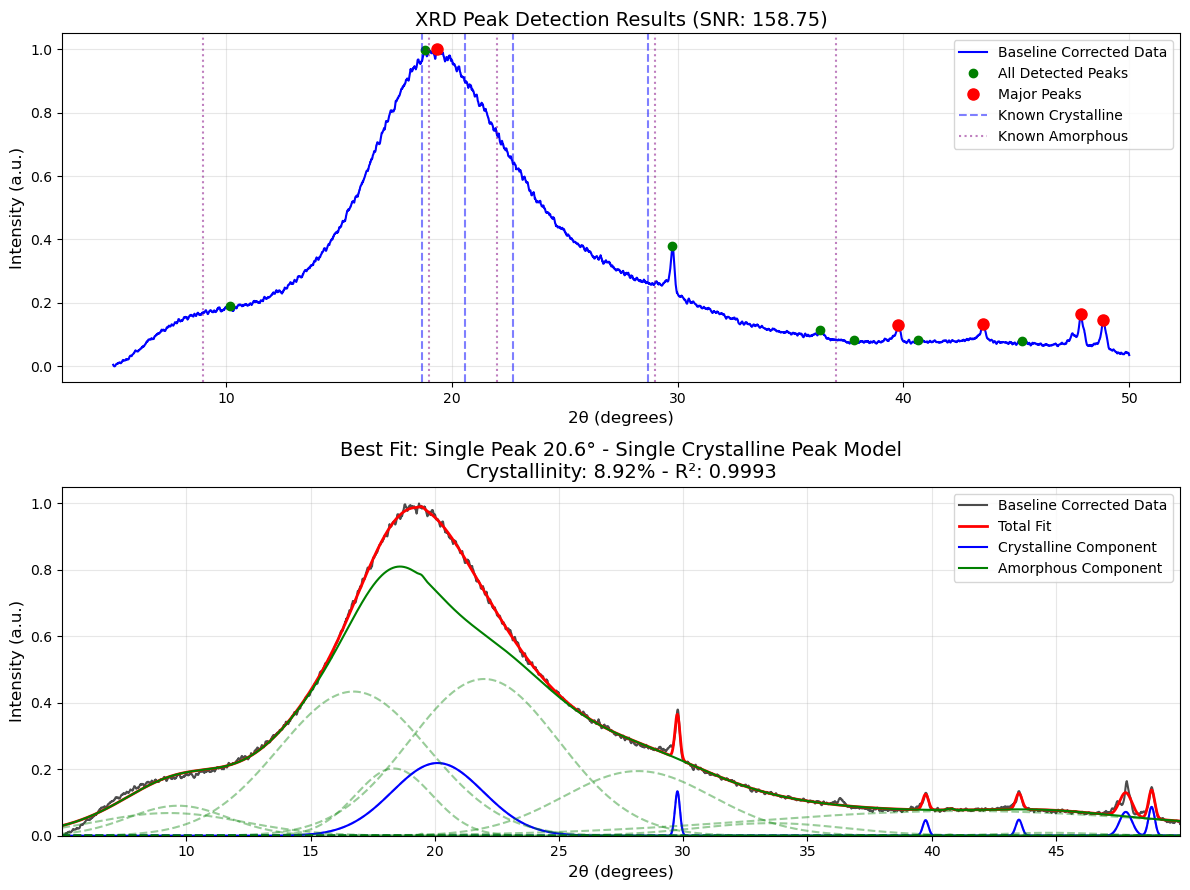

Processing file: 500907_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9977

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² improvement: +-0.5859
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED but minimal R² improvement: +0.0021
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² improvement: +-1.7228
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² improvement: +-1.5240
Phase 2: FAILED - No significant crystalline peaks identified

Phase 3: SKIPPED - No successful crystalline peaks to combine

Selected Single Peak 20.6° model with R² = 0.9998


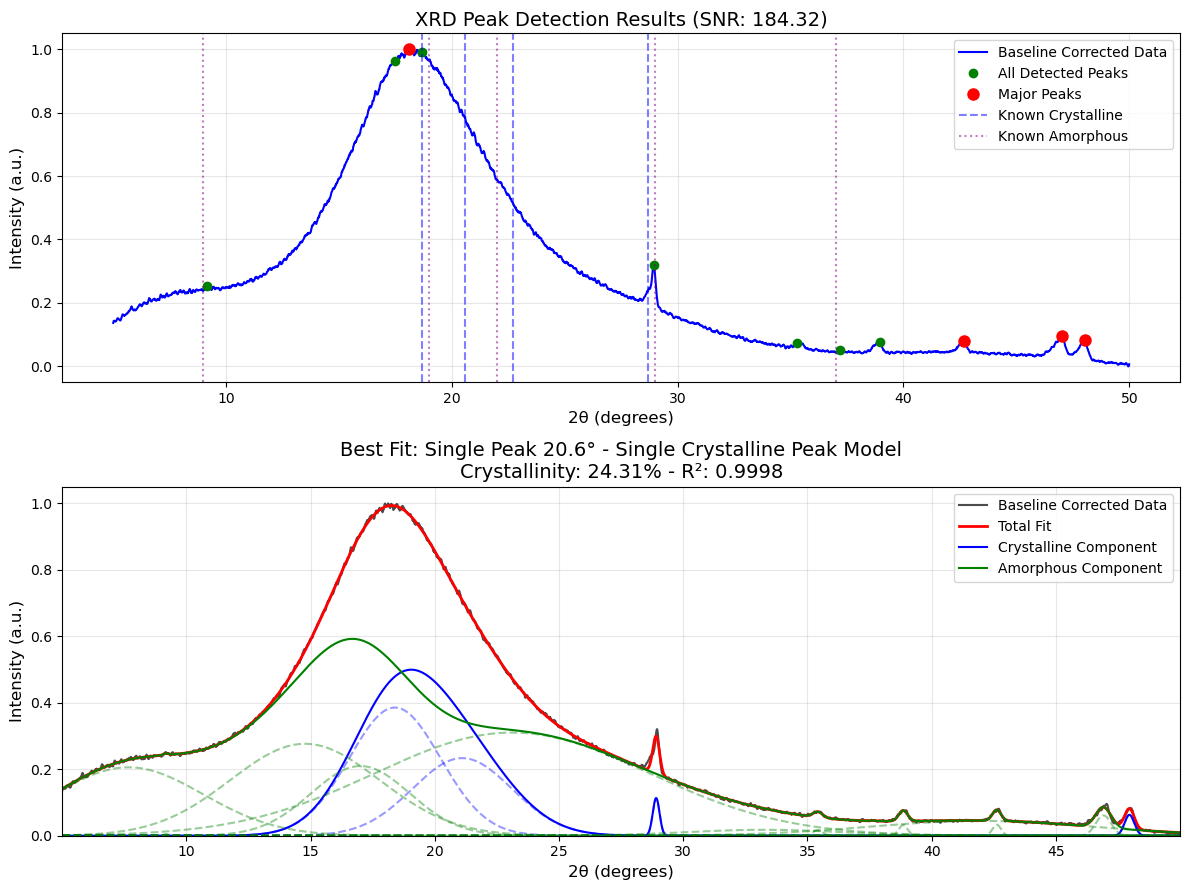

Processing file: 501023.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9418

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² improvement: +-2.7116
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED but R² = 0.9567 < 0.9990
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² improvement: +-2.4878
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² improvement: +-2.5791

  No peaks met R² threshold, but best peak at 20.6° with R² = 0.9567 shows improvement
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: INSUFFICIENT - Combin

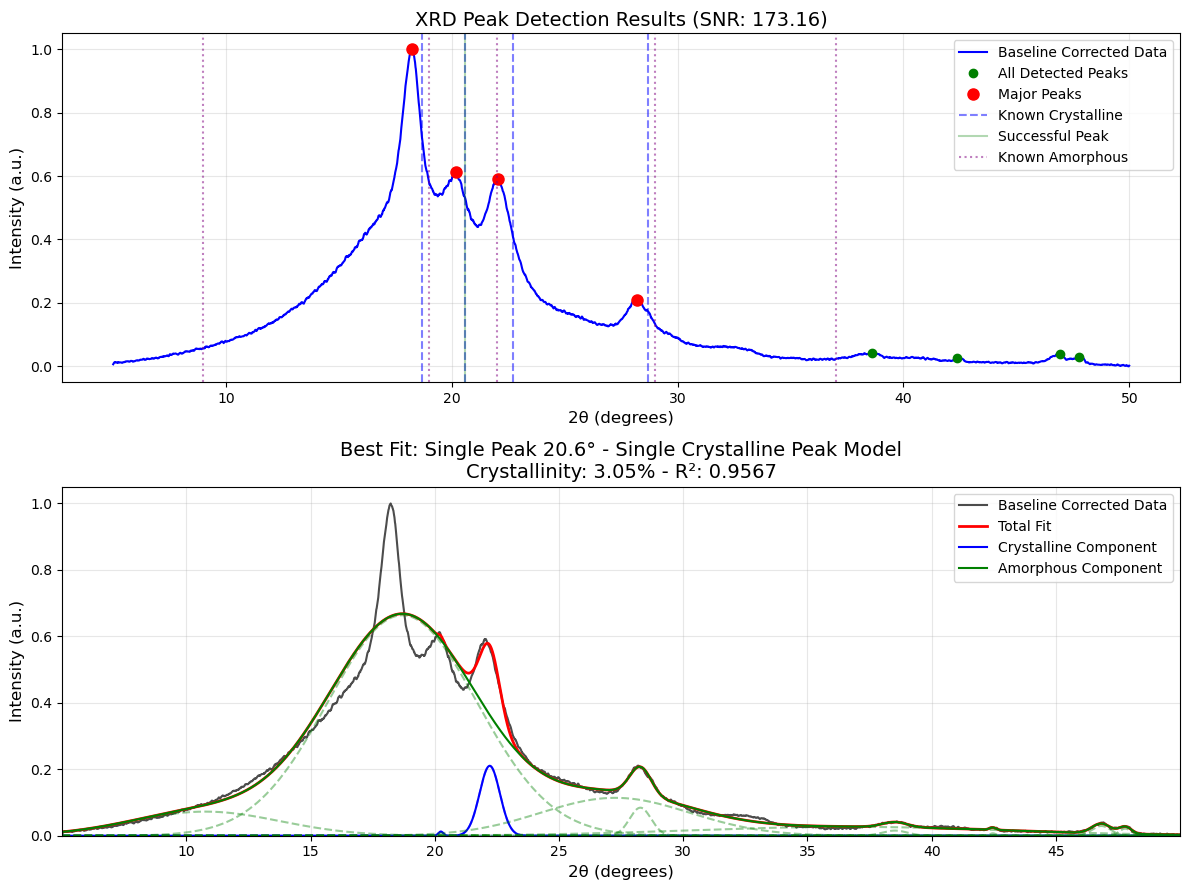

Processing file: 501023_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9288

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² improvement: +-1.3331
  Testing peak at 20.6°...
  Peak at 20.6°: SUCCESSFUL - R² = 0.9992 (+0.0705), Crystallinity = 11.85%
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² improvement: +-1.1312
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² improvement: +-1.1816
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: SUCCESSFUL - Combined fit with R² = 0.9992, Crystallinity = 11.85%

Selected Combi

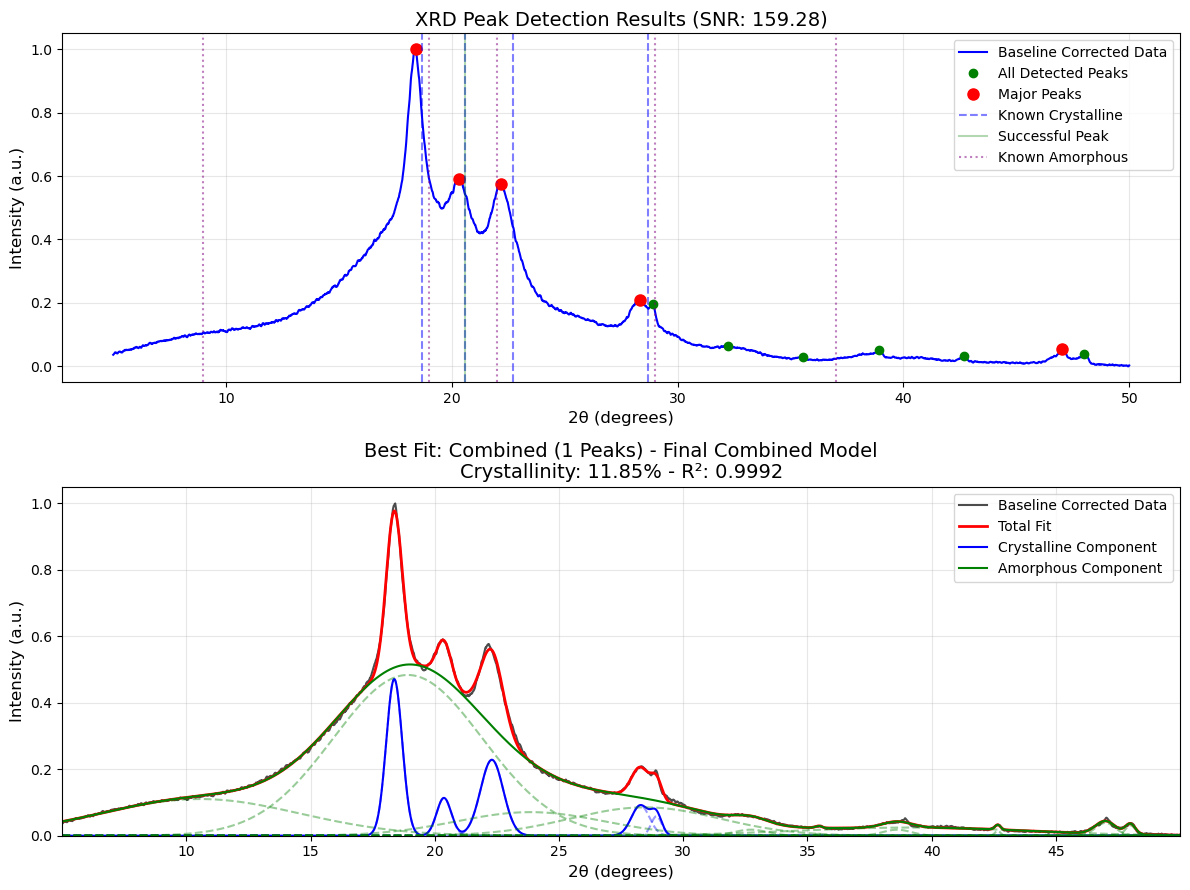

Processing file: 501024.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9159

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² improvement: +-1.0051
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED but R² = 0.9989 < 0.9990
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² improvement: +-1.0856
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² improvement: +-1.0746

  No peaks met R² threshold, but best peak at 20.6° with R² = 0.9989 shows improvement
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: INSUFFICIENT - Combin

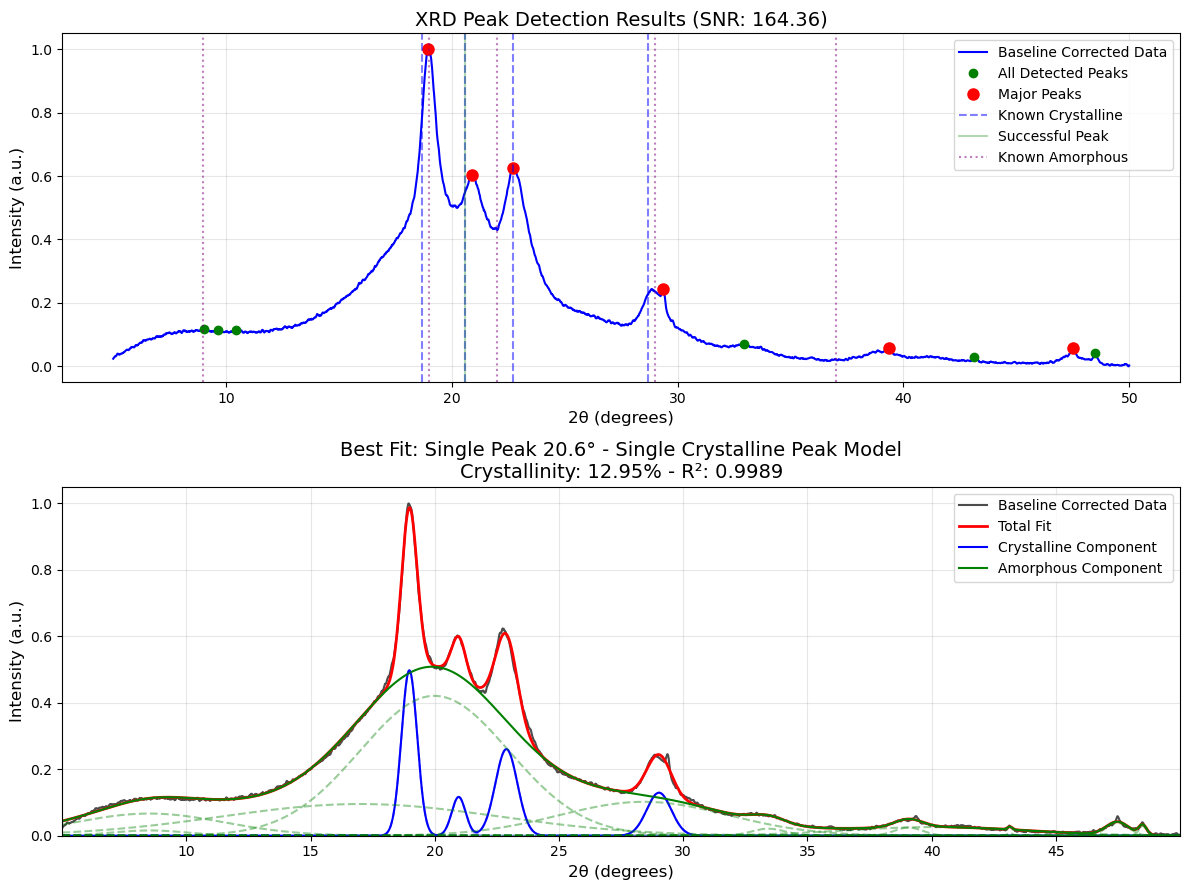

Processing file: 501024_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9107

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² improvement: +-0.9321
  Testing peak at 20.6°...
  Peak at 20.6°: SUCCESSFUL - R² = 0.9991 (+0.0884), Crystallinity = 13.32%
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² improvement: +-0.8029
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² improvement: +-0.8469
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: SUCCESSFUL - Combined fit with R² = 0.9991, Crystallinity = 13.32%

Selected Combi

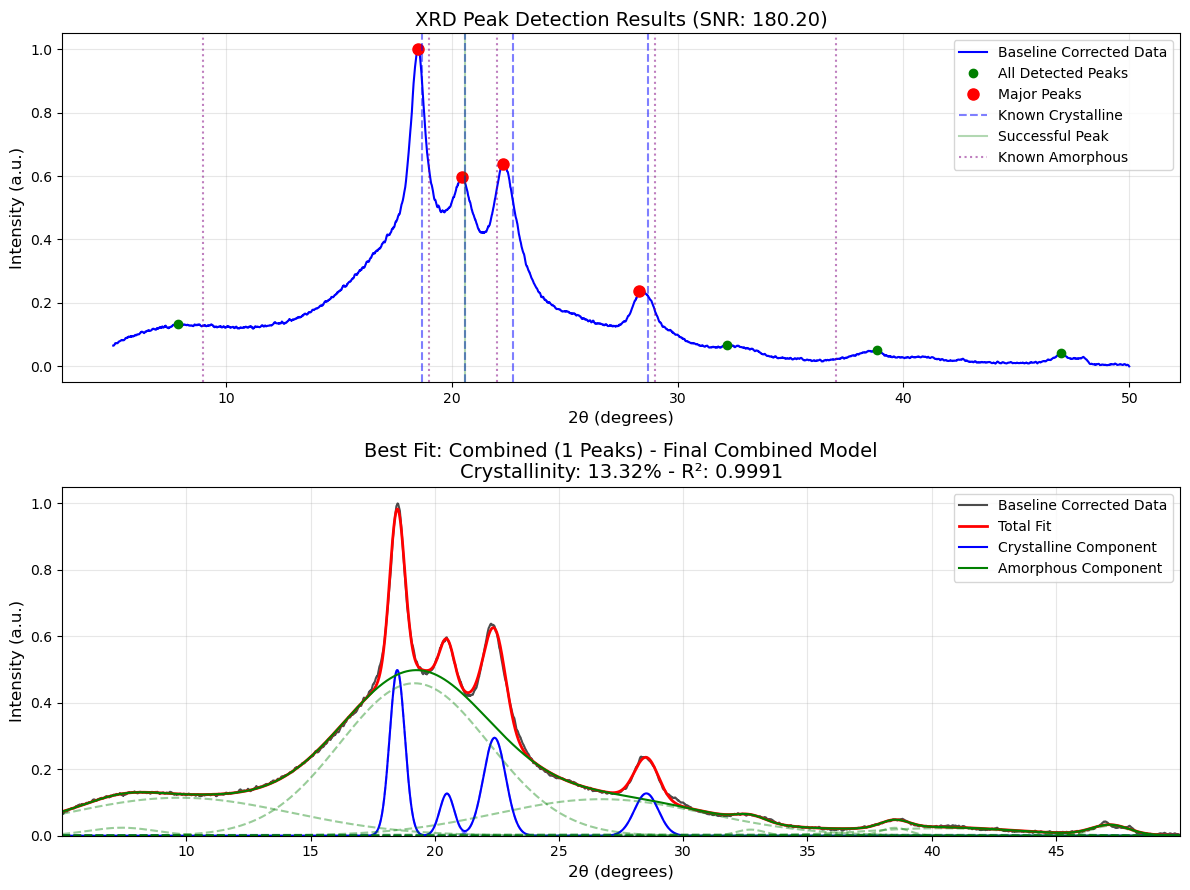

Processing file: HDPE.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.3187

Phase 2: Testing each crystalline peak individually...
  Testing peak at 21.5°...
  Peak at 21.5°: DETECTED but R² = 0.9795 < 0.9990
  Testing peak at 23.9°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 23.9°: DETECTED but minimal R² improvement: +-0.1171
  Testing peak at 30.0°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 30.0°: DETECTED but minimal R² improvement: +-0.1159
  Testing peak at 36.2°...
  Peak at 36.2°: DETECTED but R² = 0.9795 < 0.9990

  No peaks met R² threshold, but best peak at 21.5° with R² = 0.9795 shows improvement
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: INSUFFICIENT - Combined fit with R² = 0.9795 < 0.9990

Selected Single Peak 21.5° model with R² = 0.9795


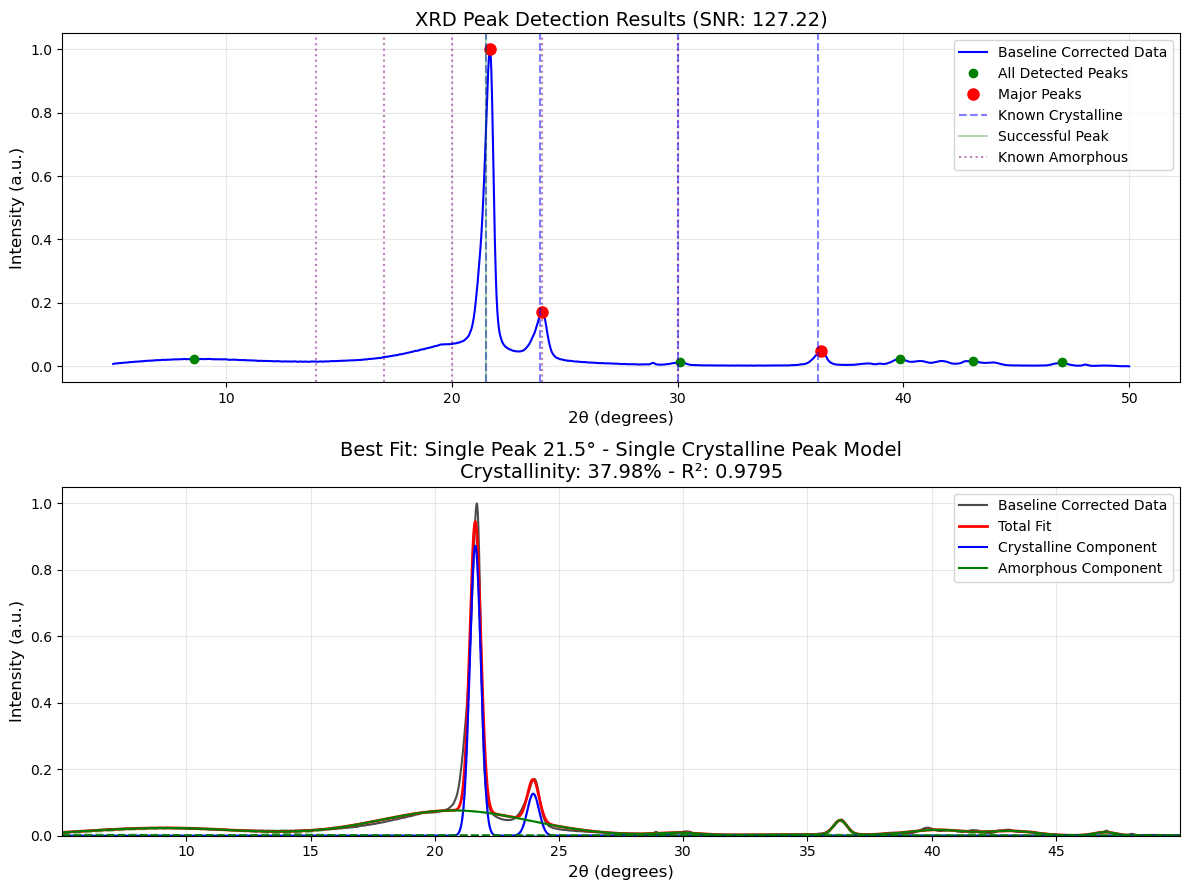

Processing file: HDPE_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.2892

Phase 2: Testing each crystalline peak individually...
  Testing peak at 21.5°...
  Peak at 21.5°: DETECTED but R² = 0.9732 < 0.9990
  Testing peak at 23.9°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 23.9°: DETECTED but minimal R² improvement: +0.0068
  Testing peak at 30.0°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 30.0°: DETECTED but minimal R² improvement: +0.0044
  Testing peak at 36.2°...
  Peak at 36.2°: DETECTED but R² = 0.9732 < 0.9990

  No peaks met R² threshold, but best peak at 36.2° with R² = 0.9732 shows improvement
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: INSUFFICIENT - Combined fit with R² = 0.9732 < 0.9990

Selected Single Peak 36.2° model with R² = 0.9732


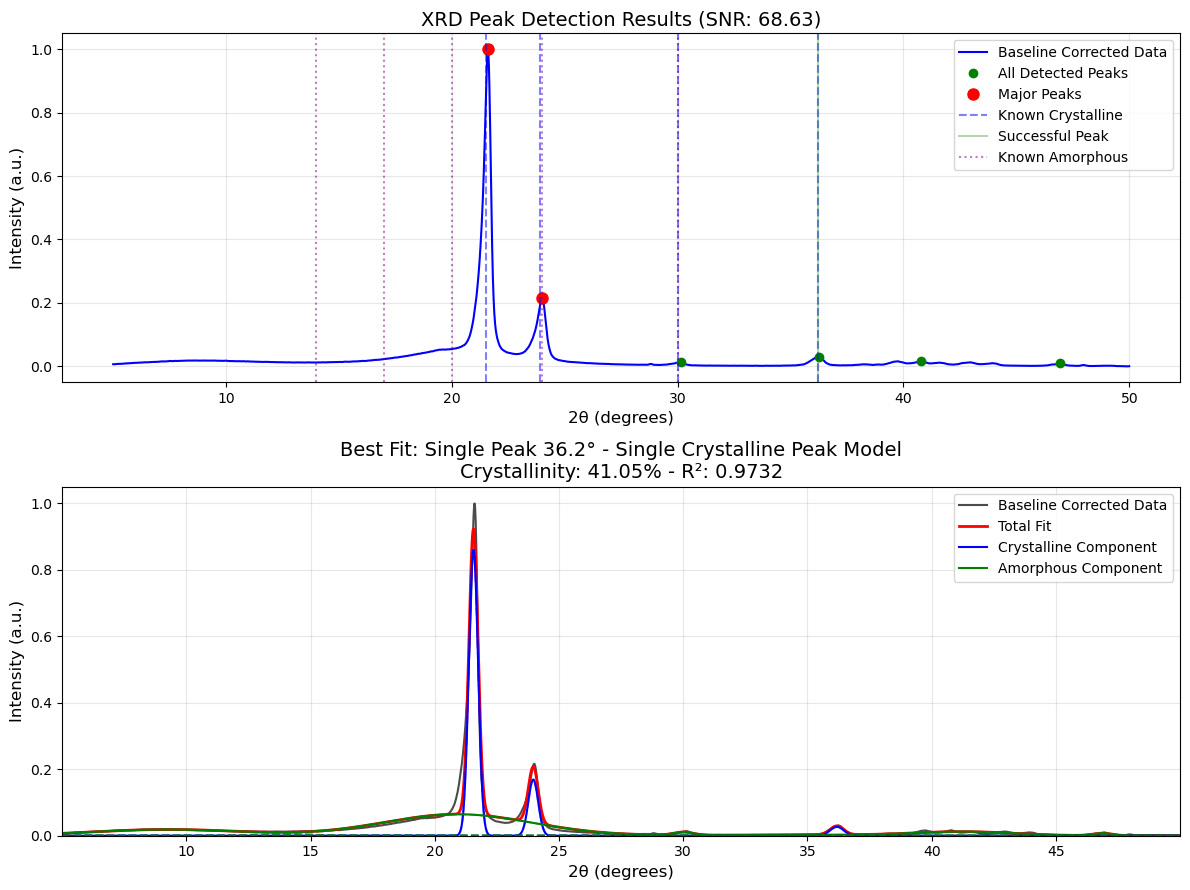

In [23]:
known_crys_peaks_dict = {
    'PEEK': [18.7, 20.6, 22.7, 28.7],   # (110), (111), (200), (211) 
    'HDPE': [21.5, 23.9, 30.0, 36.2,] # (110), (200), (210), (020)
}

known_amorp_peaks_dict = {
    'PEEK': [9, 19, 22, 29, 37],
    'HDPE': [14, 17, 20, 24, 30]
}

cryst_dict = {}
for file in all_files:
    print(f"Processing file: {file}")
    if 'HDPE' in file:
        polymer = 'HDPE'
    else:
        polymer = 'PEEK'
    data = df_dict[file]
    intensity = data['Intensity_norm'].values
    two_theta = data['2Theta'].values
    
    results = fit_xrd_spectrum(two_theta, intensity, 
                               known_crys_peaks=known_crys_peaks_dict.get(polymer, None),
                               known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
                               height_width_threshold=0.2, min_r_squared=0.999, 
                               visualise=True)
    
    cryst_dict[file] = results['crystallinity']

#### Iteration 3.1

Make `known_peak_tolerance` an argument in `_perform_fitting`.

In [ ]:
def _perform_fitting(two_theta, baseline_corrected_intensity, known_crys_peaks, known_amorp_peaks,
                    min_prominence, height_width_threshold, known_peak_tolerance=1.0, with_crystalline=True):
    """
    Internal helper function to perform the XRD spectrum fitting process.
    This encapsulates the peak detection, fitting and classification logic.
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    baseline_corrected_intensity : array-like
        Baseline-corrected and normalized intensity values
    known_crys_peaks : list
        List of known crystalline peak positions from literature
    known_amorp_peaks : list
        List of known amorphous peak positions
    min_prominence : float
        Minimum prominence for peak detection
    height_width_threshold : float
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    known_peak_tolerance : float, default=1.0
        Tolerance for considering a detected peak as a known peak
    with_crystalline : bool, default=True
        Whether to include crystalline components in the fit
        
    Returns:
    --------
    dict
        Dictionary containing fitting results, parameters and metrics
    """
    # --- Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=min_prominence,  
                             width=10,
                             distance=50)
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # --- Set Up Initial Guesses ---
    init_guess = []
    
    # Add known crystalline peaks if in crystalline fitting mode
    if with_crystalline and known_crys_peaks:
        for known_pos in known_crys_peaks:
            # Check if a detected peak is near this position
            nearby_peak_idx = None
            for i, pos in enumerate(peak_positions):
                if abs(pos - known_pos) < known_peak_tolerance:
                    nearby_peak_idx = i
                    break
                    
            if nearby_peak_idx is not None:
                # Use the detected peak's height and estimate width
                height = peak_heights[nearby_peak_idx]
                width = peak_widths_degrees[nearby_peak_idx] if nearby_peak_idx < len(peak_widths_degrees) else 0.5
                init_guess.extend([height, known_pos, width])
            else:
                # No nearby detected peak, estimate parameters based on data at this position
                nearby_idx = np.argmin(np.abs(two_theta - known_pos))
                height_estimate = baseline_corrected_intensity[nearby_idx] * 0.8
                init_guess.extend([height_estimate, known_pos, 0.5])
    
    # Add detected peaks not near known crystalline peaks if in crystalline mode
    if with_crystalline:
        for i, pos in enumerate(peak_positions):
            # Skip if this peak is already accounted for (near a known peak)
            if known_crys_peaks and any(abs(pos - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks):
                continue
                
            # Check if this peak might be overlapping with others
            is_overlapping = False
            for j, other_pos in enumerate(peak_positions):
                if i != j and abs(pos - other_pos) < 1.0:
                    is_overlapping = True
                    break
            
            # Determine appropriate width estimate
            if i < len(peak_widths_degrees):
                width_estimate = peak_widths_degrees[i]
                # Adjust width for overlapping peaks
                if is_overlapping:
                    width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
            else:
                width_estimate = 0.5  # Default if width couldn't be determined
            
            # Add parameters [amplitude, position, width]
            init_guess.extend([peak_heights[i], pos, width_estimate])
    
    # Add amorphous background peaks
    if not known_amorp_peaks:
        # Default amorphous peaks if not specified
        known_amorp_peaks = [20, 30]
        
    num_amorphous_peaks = len(known_amorp_peaks)
    mean_intensity = np.mean(baseline_corrected_intensity)
    
    for pos in known_amorp_peaks:
        init_guess.extend([mean_intensity/2, pos, 5.0])  # amplitude, position, width
    
    # If no components were added at all, add a minimal set
    if len(init_guess) == 0:
        # Add a broad amorphous component
        init_guess.extend([0.5, 25, 10.0])  # amplitude, position, width
        num_amorphous_peaks = 1
    
    # --- Set up boundary constraints ---
    bounds_low = []
    bounds_high = []
    
    # For each parameter triplet in the initial guess
    param_index = 0
    while param_index < len(init_guess):
        amp = init_guess[param_index]
        center = init_guess[param_index + 1]
        width = init_guess[param_index + 2]
        
        # Check if this is likely a crystalline peak based on its width or if it's a known crystalline position
        is_crystalline = False
        if with_crystalline:
            if width < 2.0:  # Width-based classification
                is_crystalline = True
            elif known_crys_peaks:  # Position-based classification
                is_crystalline = any(abs(center - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks)
        
        if is_crystalline:
            # Crystalline peak bounds
            bounds_low.extend([0, center - 0.5, 0.1])
            bounds_high.extend([np.inf, center + 0.5, 2.0])
        else:
            # Amorphous peak bounds
            bounds_low.extend([0, center - 5, 3.0])
            bounds_high.extend([np.inf, center + 5, 15.0])
            
        param_index += 3
    
    # --- Perform Gaussian Fitting ---
    try:
        # Define Gaussian function for fitting
        def gaussian(x, A, x0, sigma):
            """Gaussian function with parameters amplitude, center, and width"""
            return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
        
        def multi_gaussian(x, *params):
            """Fit multiple Gaussian peaks simultaneously"""
            num_peaks = len(params) // 3
            y_fit = np.zeros_like(x)
            for i in range(num_peaks):
                amp = params[3*i]
                center = params[3*i+1]
                width = params[3*i+2]
                y_fit += gaussian(x, amp, center, width)
            return y_fit
        
        # Perform the fit
        popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                              p0=init_guess, bounds=(bounds_low, bounds_high),
                              maxfev=20000)  # Increase maximum function evaluations
    except Exception as e:
        print(f"Fitting error: {str(e)}")
        print("Falling back to initial guess parameters")
        popt = np.array(init_guess)
    
    # --- Separate Components Based on Height-to-Width Ratio ---
    crystalline_params = []
    amorphous_params = []
    
    # Process fitted parameters
    for i in range(0, len(popt), 3):
        if i+2 >= len(popt):  # Safety check
            break
            
        amp = popt[i]
        center = popt[i+1]
        width = popt[i+2]
        hw_ratio = amp / width if width > 0 else 0  # Height-to-width ratio
        
        # Skip peaks with near-zero amplitude
        if amp < 0.001:
            continue
        
        # Check if this matches a known crystalline peak position
        is_known_crys_pos = False
        if known_crys_peaks and with_crystalline:
            is_known_crys_pos = any(abs(center - known_pos) < known_peak_tolerance 
                                  for known_pos in known_crys_peaks)
        
        # Classify peak - consider both ratio and position
        if with_crystalline and (is_known_crys_pos and hw_ratio > height_width_threshold) and width < 2.0:
            # This is likely a crystalline peak
            crystalline_params.extend([amp, center, width])
        else:
            # This is likely an amorphous peak
            amorphous_params.extend([amp, center, width])
    
    # --- Calculate Individual Components ---
    crystalline_fit = np.zeros_like(two_theta)
    if crystalline_params:
        crystalline_fit = multi_gaussian(two_theta, *crystalline_params)
        
    amorphous_fit = np.zeros_like(two_theta)
    if amorphous_params:
        amorphous_fit = multi_gaussian(two_theta, *amorphous_params)
        
    total_fit = crystalline_fit + amorphous_fit
    
    # --- Calculate Crystallinity Index ---
    area_crystalline = np.trapz(crystalline_fit, two_theta)
    area_amorphous = np.trapz(amorphous_fit, two_theta)
    area_total = area_crystalline + area_amorphous
    
    if area_total > 0:
        crystallinity = (area_crystalline / area_total) * 100
    else:
        crystallinity = 0.0
    
    # --- Calculate Goodness of Fit ---
    residuals = baseline_corrected_intensity - total_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((baseline_corrected_intensity - np.mean(baseline_corrected_intensity))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    rmse = np.sqrt(np.mean(residuals**2))
    
    # --- Organize fitted peaks for reporting ---
    crystalline_peak_data = []
    for i in range(0, len(crystalline_params), 3):
        if i+2 >= len(crystalline_params):
            break
        crystalline_peak_data.append({
            'amplitude': crystalline_params[i],
            'position': crystalline_params[i+1], 
            'width': crystalline_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     crystalline_params[i], 
                                     crystalline_params[i+1], 
                                     crystalline_params[i+2]), 
                            two_theta)
        })
    
    amorphous_peak_data = []
    for i in range(0, len(amorphous_params), 3):
        if i+2 >= len(amorphous_params):
            break
        amorphous_peak_data.append({
            'amplitude': amorphous_params[i],
            'position': amorphous_params[i+1], 
            'width': amorphous_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     amorphous_params[i], 
                                     amorphous_params[i+1], 
                                     amorphous_params[i+2]), 
                            two_theta)
        })
    
    # Return fitting results
    results = {
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'optimized_parameters': popt,
        'crystalline_params': crystalline_params,
        'amorphous_params': amorphous_params,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'total_fit': total_fit,
        'crystallinity': crystallinity,
        'r_squared': r_squared,
        'rmse': rmse,
        'residuals': residuals,
        'crystalline_peak_data': crystalline_peak_data,
        'amorphous_peak_data': amorphous_peak_data
    }
    
    return results

In [ ]:
def fit_xrd_spectrum(two_theta, intensity, known_crys_peaks=None, known_amorp_peaks=None, 
                     height_width_threshold=0.3, min_prominence=0.008, 
                     min_r_squared=0.992, amorphous_r_squared=0.80, visualise=True):
    """
    Efficient XRD analysis function using a build-up strategy:
    1. Start with amorphous-only fit
    2. Test individual crystalline peaks for significance
    3. Combine successful crystalline peaks for final model
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    intensity : array-like
        Array of corresponding intensity values
    known_crys_peaks : list or None, optional
        List of known crystalline peak positions from literature
    known_amorp_peaks : list or None, optional
        List of known amorphous peak positions
    height_width_threshold : float, default=0.2
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    min_prominence : float, default=0.008
        Minimum prominence for peak detection
    min_r_squared : float, default=0.85
        Minimum R² value for considering a fit successful
    amorphous_r_squared : float, default=0.80
        Lower threshold for amorphous-only fit acceptability
    visualise : bool, default=True
        Whether to generate visualization plots
        
    Returns:
    --------
    dict
        Dictionary containing peak information, fitted parameters, and crystallinity
    """
    # Set default values if None is provided
    if known_crys_peaks is None:
        known_crys_peaks = []  
        
    if known_amorp_peaks is None:
        known_amorp_peaks = [20, 30]  # Default amorphous peak positions
    
    # --- Step 1: Data Preprocessing ---
    # Normalize intensity
    normalized_intensity = intensity / np.max(intensity)
    
    # Smooth the normalized data
    smoothed_intensity = savgol_filter(normalized_intensity, window_length=15, polyorder=3)
    
    # --- Step 2: Baseline Correction ---
    # Method: Find the minimum value of smoothed intensity as baseline level
    baseline_level = np.min(smoothed_intensity)
    
    # Subtract baseline level from smoothed intensity
    baseline_corrected_intensity = smoothed_intensity - baseline_level
    
    # Ensure no negative values
    baseline_corrected_intensity = np.maximum(baseline_corrected_intensity, 0)
    
    # Renormalize after baseline correction
    if np.max(baseline_corrected_intensity) > 0:
        baseline_corrected_intensity = baseline_corrected_intensity / np.max(baseline_corrected_intensity)
    
    # --- Step 3: Assess Signal Quality ---
    # Calculate signal-to-noise ratio
    signal_mean = np.mean(baseline_corrected_intensity)
    noise_estimate = np.std(baseline_corrected_intensity - 
                           savgol_filter(baseline_corrected_intensity, window_length=21, polyorder=3))
    snr = signal_mean / noise_estimate if noise_estimate > 0 else 0
    
    # Adjust peak detection parameters based on signal quality
    adjusted_min_prominence = min_prominence
    if snr < 5:  # Low SNR
        print(f"Low signal-to-noise ratio detected ({snr:.2f}). Adjusting detection parameters.")
        adjusted_min_prominence = min_prominence * 1.5  # Increase prominence threshold for noisy data
    
    # Check if data has any significant peaks at all
    max_peak_height = np.max(baseline_corrected_intensity)
    is_mostly_amorphous = max_peak_height < 0.1  # Very low peak height suggests mostly amorphous
    
    if is_mostly_amorphous:
        print("Sample appears to be predominantly amorphous.")
    
    # --- Step 4: Define Gaussian Functions ---
    def gaussian(x, A, x0, sigma):
        """Gaussian function with parameters amplitude, center, and width"""
        return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
    
    def multi_gaussian(x, *params):
        """Fit multiple Gaussian peaks simultaneously"""
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)
        for i in range(num_peaks):
            amp = params[3*i]
            center = params[3*i+1]
            width = params[3*i+2]
            y_fit += gaussian(x, amp, center, width)
        return y_fit
    
    # --- Step 5: Run Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=adjusted_min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=adjusted_min_prominence,  
                             width=10,         
                             distance=50)      
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=adjusted_min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # --- Step 6: Build-Up Fitting Strategy ---
    phase_success = {"amorphous": False, "individual_peaks": False, "combined": False}
    fitting_results = {}
    
    # PHASE 1: Start with amorphous-only fit
    print("\nPhase 1: Performing amorphous-only fit...")
    amorphous_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                       [], known_amorp_peaks,
                                       adjusted_min_prominence, height_width_threshold,
                                       with_crystalline=False)
    
    # Store amorphous-only results
    fitting_results["amorphous"] = {
        "name": "Amorphous Only",
        "model": amorphous_results
    }
    
    # Check if amorphous fit is excellent (exceeds normal threshold)
    if amorphous_results['r_squared'] >= min_r_squared:
        print(f"Phase 1: EXCELLENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
        phase_success["amorphous"] = True
        best_fit = amorphous_results
        best_fit_name = "Amorphous Only"
    else:
        # Check if amorphous fit is at least acceptable
        amorphous_acceptable = amorphous_results['r_squared'] >= amorphous_r_squared
        if amorphous_acceptable:
            print(f"Phase 1: ACCEPTABLE - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
            phase_success["amorphous"] = True
        else:
            print(f"Phase 1: INSUFFICIENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
    
    # PHASE 2: Test individual crystalline peaks if we have any
    successful_peaks = []
    peak_r2_values = {}
    best_individual_r2 = 0
    best_individual_results = None
    best_individual_peak = None
    
    if known_crys_peaks:
        print("\nPhase 2: Testing each crystalline peak individually...")
        
        for peak_pos in known_crys_peaks:
            try:
                print(f"  Testing peak at {peak_pos}°...")
                single_peak_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                                   [peak_pos], known_amorp_peaks,
                                                   adjusted_min_prominence, height_width_threshold)
                
                # Record R² value for this peak
                peak_r2_values[peak_pos] = single_peak_results['r_squared']
                
                # Check if this peak provides any crystallinity
                has_crystallinity = single_peak_results['crystallinity'] > 0
                
                # Calculate improvement over amorphous-only model
                r2_improvement = single_peak_results['r_squared'] - amorphous_results['r_squared']
                
                # Track best individual peak fit regardless of threshold
                if has_crystallinity and single_peak_results['r_squared'] > best_individual_r2:
                    best_individual_r2 = single_peak_results['r_squared']
                    best_individual_results = single_peak_results
                    best_individual_peak = peak_pos
                
                # Consider peak successful if:
                # 1. It contributes to crystallinity
                # 2. It improves R² by a meaningful amount
                # 3. R² exceeds our threshold
                if has_crystallinity and r2_improvement > 0.01:
                    if single_peak_results['r_squared'] >= min_r_squared:
                        successful_peaks.append(peak_pos)
                        print(f"  Peak at {peak_pos}°: SUCCESSFUL - R² = {single_peak_results['r_squared']:.4f} "
                              f"(+{r2_improvement:.4f}), Crystallinity = {single_peak_results['crystallinity']:.2f}%")
                    else:
                        print(f"  Peak at {peak_pos}°: DETECTED but R² = {single_peak_results['r_squared']:.4f} < {min_r_squared:.4f}")
                elif has_crystallinity:
                    print(f"  Peak at {peak_pos}°: DETECTED but minimal R² change: {r2_improvement:.4f}")
                else:
                    print(f"  Peak at {peak_pos}°: NOT DETECTED as crystalline")
                    
            except Exception as e:
                print(f"  Peak at {peak_pos}°: ERROR - {str(e)}")
        
        # Store best individual peak result if we found one
        if best_individual_results is not None:
            fitting_results["individual_peak"] = {
                "name": f"Single Peak {best_individual_peak}°",
                "model": best_individual_results,
                "peak_position": best_individual_peak
            }
            
            # If no peaks met our threshold but we have a best peak, consider it
            if not successful_peaks and best_individual_r2 > amorphous_results['r_squared'] + 0.01:
                print(f"\n  No peaks met R² threshold, but best peak at {best_individual_peak}° "
                      f"with R² = {best_individual_r2:.4f} shows improvement")
                successful_peaks.append(best_individual_peak)
        
        # Update phase success
        phase_success["individual_peaks"] = len(successful_peaks) > 0
        if phase_success["individual_peaks"]:
            print(f"Phase 2: SUCCESSFUL - {len(successful_peaks)} crystalline peaks identified")
        else:
            print("Phase 2: FAILED - No significant crystalline peaks identified")
    else:
        print("\nPhase 2: SKIPPED - No known crystalline peaks provided")
    
    # PHASE 3: Final combined fit if we found any successful peaks
    if successful_peaks:
        print(f"\nPhase 3: Performing final combined fit with {len(successful_peaks)} crystalline peaks...")
        try:
            combined_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                             successful_peaks, known_amorp_peaks,
                                             adjusted_min_prominence, height_width_threshold)
            
            # Store combined results
            fitting_results["combined"] = {
                "name": f"Combined ({len(successful_peaks)} Peaks)",
                "model": combined_results,
                "used_peaks": successful_peaks
            }
            
            # Check if combined fit is successful
            if combined_results['r_squared'] >= min_r_squared:
                print(f"Phase 3: SUCCESSFUL - Combined fit with R² = {combined_results['r_squared']:.4f}, "
                      f"Crystallinity = {combined_results['crystallinity']:.2f}%")
                phase_success["combined"] = True
                best_fit = combined_results
                best_fit_name = f"Combined ({len(successful_peaks)} Peaks)"
            else:
                print(f"Phase 3: INSUFFICIENT - Combined fit with R² = {combined_results['r_squared']:.4f} < {min_r_squared:.4f}")
        except Exception as e:
            print(f"Phase 3: ERROR - {str(e)}")
    else:
        print("\nPhase 3: SKIPPED - No successful crystalline peaks to combine")
    
    # --- Step 7: Select Best Model ---
    # If we haven't already selected a best fit, find the one with highest R²
    if 'best_fit' not in locals():
        best_r2 = 0
        for phase, results in fitting_results.items():
            if results["model"]["r_squared"] > best_r2:
                best_r2 = results["model"]["r_squared"]
                best_fit = results["model"]
                best_fit_name = results["name"]
    
    print(f"\nSelected {best_fit_name} model with R² = {best_fit['r_squared']:.4f}")
    
    # --- Step 8: Visualization ---
    if visualise:
        # Create a 2-panel figure: Peak Detection + Best Fit
        plt.figure(figsize=(12, 9))
        
        # Panel 1: Peak Detection Results
        plt.subplot(2, 1, 1)
        plt.plot(two_theta, baseline_corrected_intensity, 'b-', label='Baseline Corrected Data')
        plt.plot(two_theta[all_peaks], baseline_corrected_intensity[all_peaks], 'go', 
                label='All Detected Peaks', markersize=6)
        plt.plot(two_theta[major_peaks], baseline_corrected_intensity[major_peaks], 'ro', 
                label='Major Peaks', markersize=8)
        
        # Mark known crystalline peaks
        if known_crys_peaks:
            for pos in known_crys_peaks:
                plt.axvline(x=pos, color='blue', linestyle='--', alpha=0.5, 
                           label='Known Crystalline' if pos==known_crys_peaks[0] else "")
                
                # Highlight successful peaks
                if pos in successful_peaks:
                    plt.axvline(x=pos, color='green', linestyle='-', alpha=0.3,
                               label='Successful Peak' if pos==successful_peaks[0] else "")
        
        # Mark known amorphous peaks
        for pos in known_amorp_peaks:
            plt.axvline(x=pos, color='purple', linestyle=':', alpha=0.5,
                       label='Known Amorphous' if pos==known_amorp_peaks[0] else "")
                
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.title(f'XRD Peak Detection Results (SNR: {snr:.2f})', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Panel 2: Best Fit Model
        plt.subplot(2, 1, 2)
        
        # Plot raw data and overall fit
        plt.plot(two_theta, baseline_corrected_intensity, 'k-', alpha=0.7, 
                 label='Baseline Corrected Data')
        plt.plot(two_theta, best_fit['total_fit'], 'r-', 
                 label='Total Fit', linewidth=2)
        
        # Plot components
        if best_fit['crystalline_fit'].any():
            plt.plot(two_theta, best_fit['crystalline_fit'], 'b-', 
                     label='Crystalline Component', linewidth=1.5)
        
        plt.plot(two_theta, best_fit['amorphous_fit'], 'g-', 
                 label='Amorphous Component', linewidth=1.5)

        # Plot individual peaks
        crystalline_params = best_fit['crystalline_params']
        amorphous_params = best_fit['amorphous_params']
        
        for j in range(0, len(crystalline_params), 3):
            amp = crystalline_params[j]
            center = crystalline_params[j+1]
            width = crystalline_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'b--', alpha=0.4)

        for j in range(0, len(amorphous_params), 3):
            amp = amorphous_params[j]
            center = amorphous_params[j+1]
            width = amorphous_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'g--', alpha=0.4)

        # Add best fit phase information
        phase_info = ""
        if best_fit_name == "Combined (All Peaks)" or "Combined" in best_fit_name:
            phase_info = "Final Combined Model"
        elif best_fit_name == "Amorphous Only":
            phase_info = "Amorphous-Only Model"
        elif "Single Peak" in best_fit_name:
            phase_info = "Single Crystalline Peak Model"
            
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.ylim(bottom=0)
        plt.xlim(left=min(two_theta), right=max(two_theta))
        
        # Display model metrics
        cryst = best_fit['crystallinity']
        r2 = best_fit['r_squared']
        plt.title(f'Best Fit: {best_fit_name} - {phase_info}\n'
                  f'Crystallinity: {cryst:.2f}% - R²: {r2:.4f}', 
                  fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # --- Step 9: Return Results ---
    # Add additional information to the best fit results
    best_fit.update({
        'normalized_intensity': normalized_intensity,
        'smoothed_intensity': smoothed_intensity,
        'baseline_level': baseline_level,
        'baseline_corrected_intensity': baseline_corrected_intensity,
        'signal_to_noise': snr,
        'is_mostly_amorphous': is_mostly_amorphous,
        'phase_success': phase_success,
        'all_models': fitting_results,
        'selected_model': best_fit_name,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'all_peaks': all_peaks,
        'major_peaks': major_peaks,
        'successful_peaks': successful_peaks,
        'peak_r2_values': peak_r2_values,
        'gaussian_function': gaussian,
        'multi_gaussian_function': multi_gaussian
    })
    
    return best_fit

Processing file: 500907.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9968

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² change: -0.7658
  Testing peak at 20.6°...
  Peak at 20.6°: NOT DETECTED as crystalline
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² change: -0.6298
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² change: -0.7012
Phase 2: FAILED - No significant crystalline peaks identified

Phase 3: SKIPPED - No successful crystalline peaks to combine

Selected Amorphous Only model with R² = 0.9968


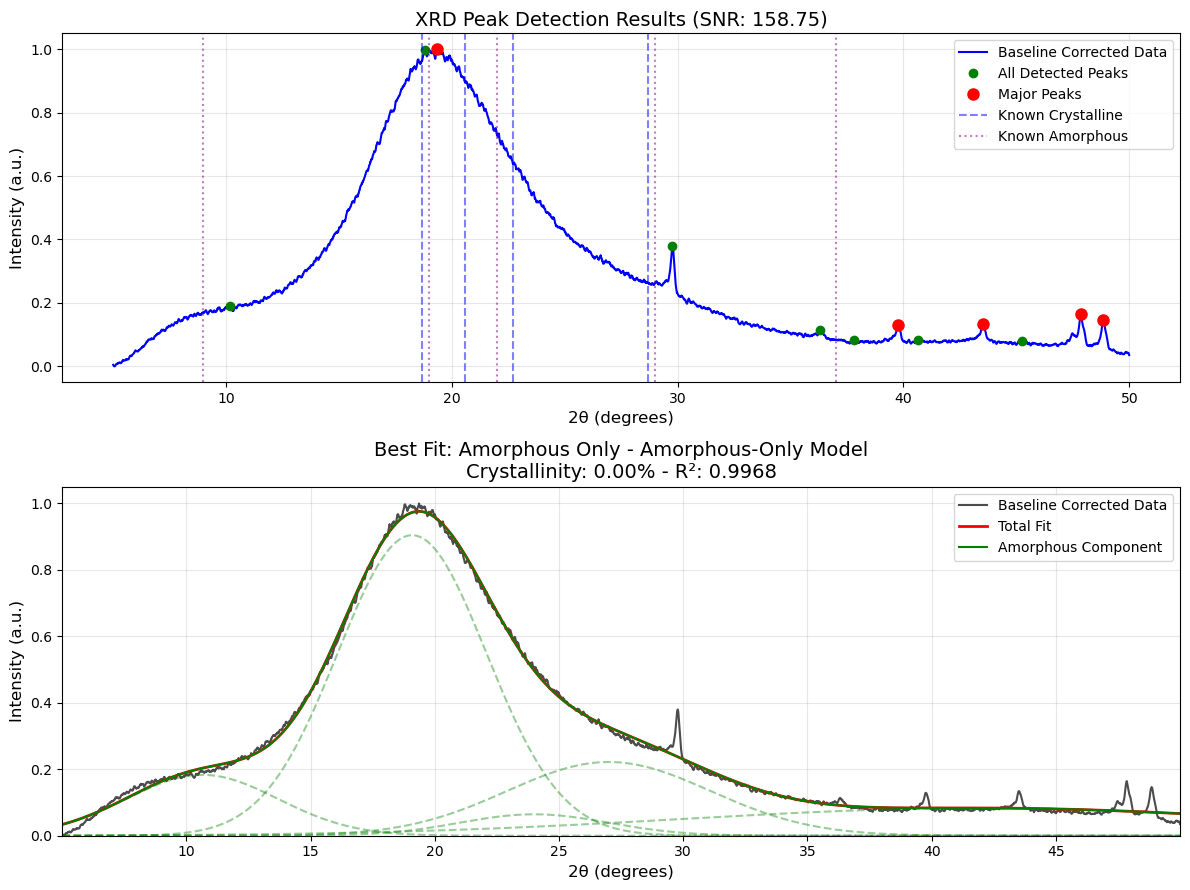

Processing file: 500907_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9977

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² change: -0.5859
  Testing peak at 20.6°...
  Peak at 20.6°: NOT DETECTED as crystalline
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² change: -1.7228
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² change: -1.5240
Phase 2: FAILED - No significant crystalline peaks identified

Phase 3: SKIPPED - No successful crystalline peaks to combine

Selected Amorphous Only model with R² = 0.9977


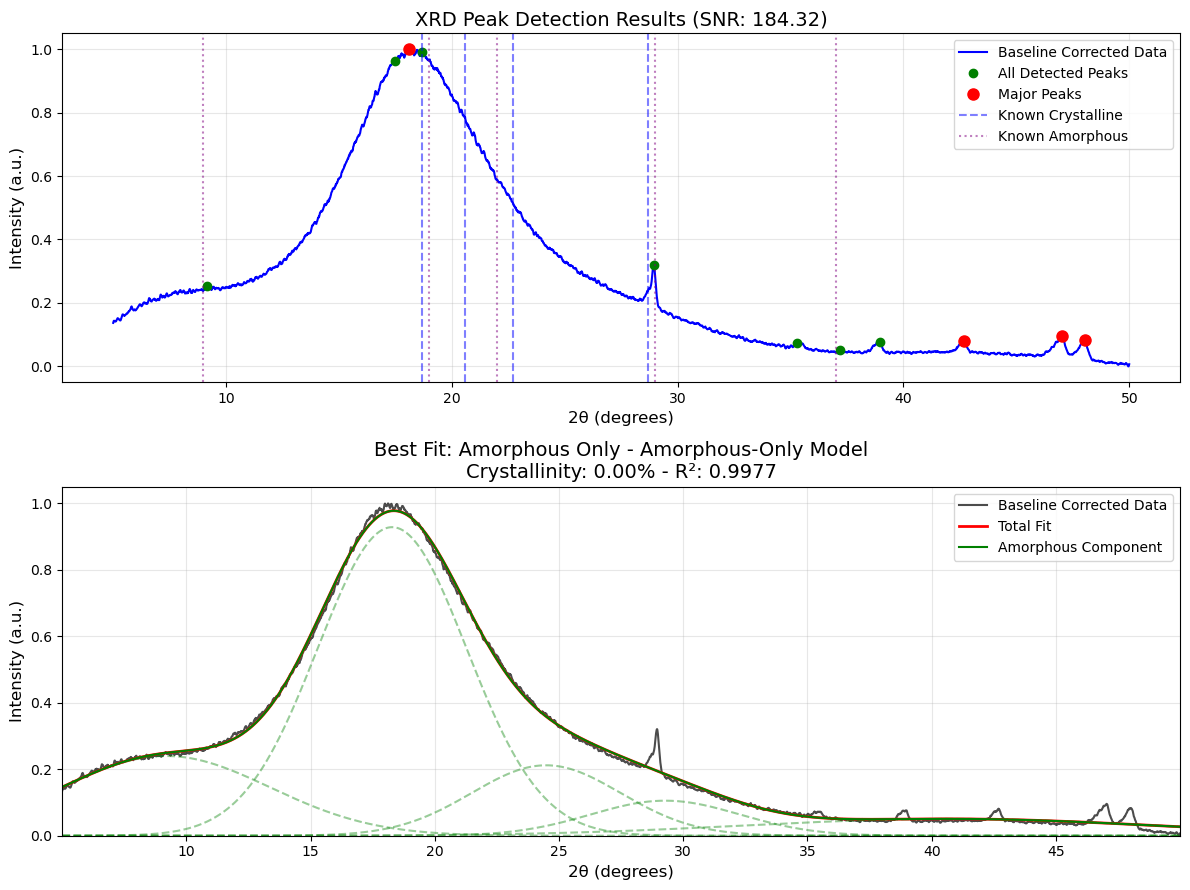

Processing file: 501023.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9418

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: NOT DETECTED as crystalline
  Testing peak at 20.6°...
  Peak at 20.6°: NOT DETECTED as crystalline
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² change: -2.4878
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: NOT DETECTED as crystalline
Phase 2: FAILED - No significant crystalline peaks identified

Phase 3: SKIPPED - No successful crystalline peaks to combine

Selected Amorphous Only model with R² = 0.9418


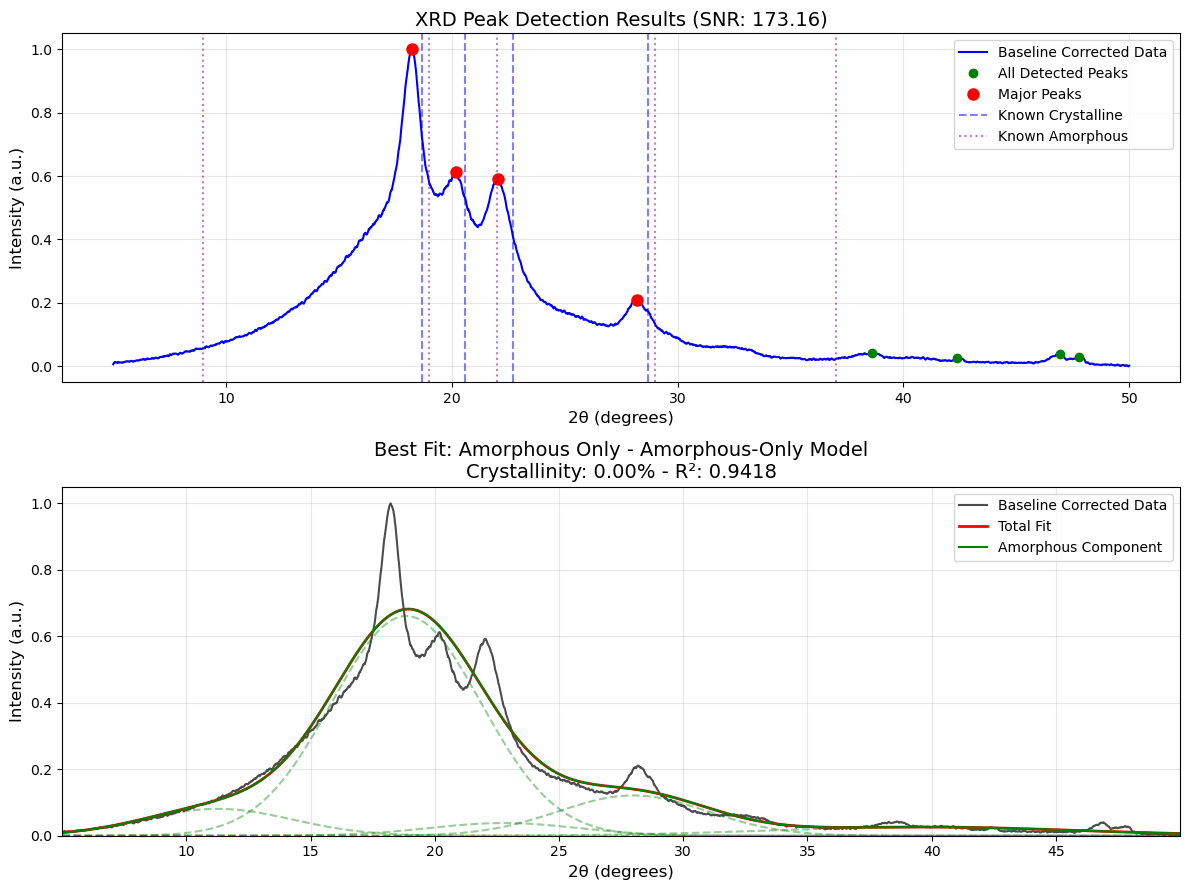

Processing file: 501023_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9288

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² change: -1.3331
  Testing peak at 20.6°...
  Peak at 20.6°: SUCCESSFUL - R² = 0.9992 (+0.0705), Crystallinity = 1.18%
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² change: -1.1312
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: NOT DETECTED as crystalline
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: SUCCESSFUL - Combined fit with R² = 0.9992, Crystallinity = 1.18%

Selected Combined (1 Peaks) model with R² = 0.

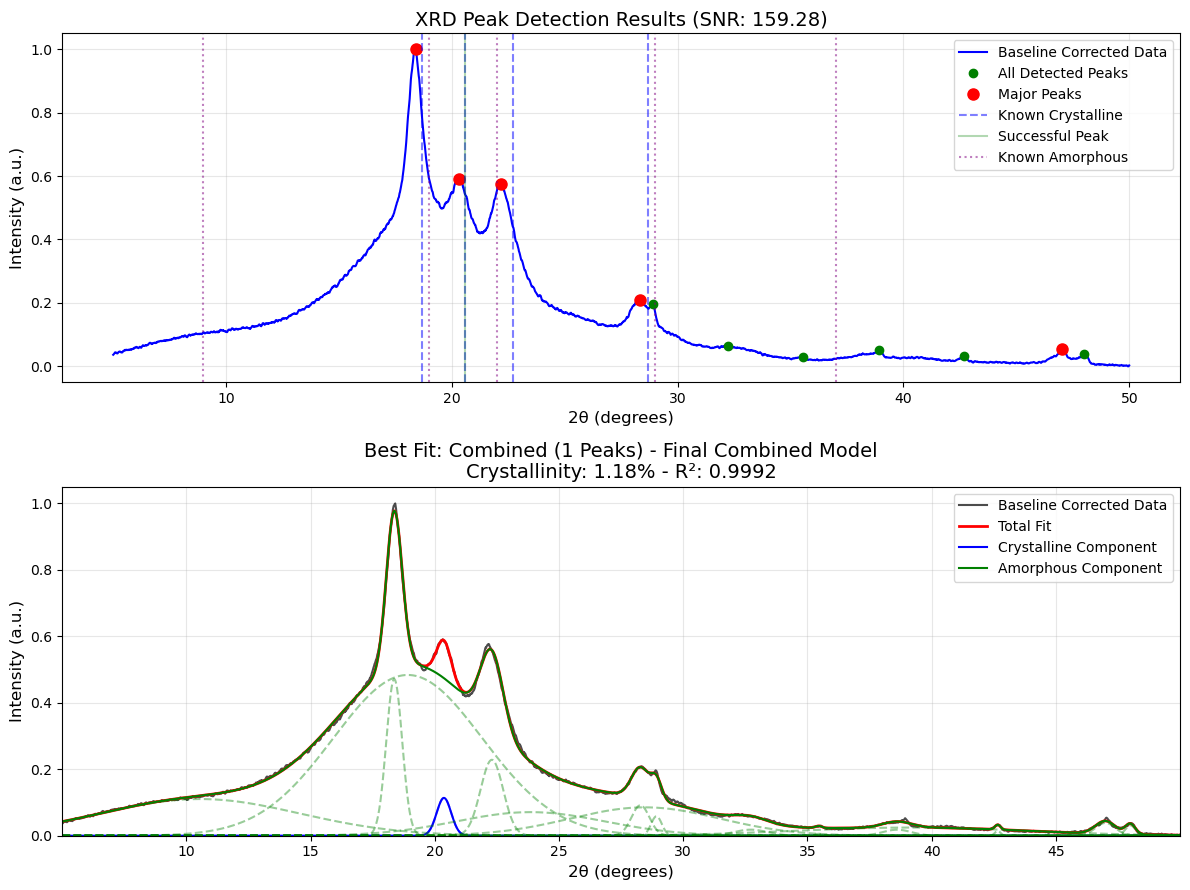

Processing file: 501024.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9159

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² change: -1.0051
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED but R² = 0.9989 < 0.9990
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² change: -1.0856
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal R² change: -1.0746

  No peaks met R² threshold, but best peak at 20.6° with R² = 0.9989 shows improvement
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: INSUFFICIENT - Combined fit with R² = 0

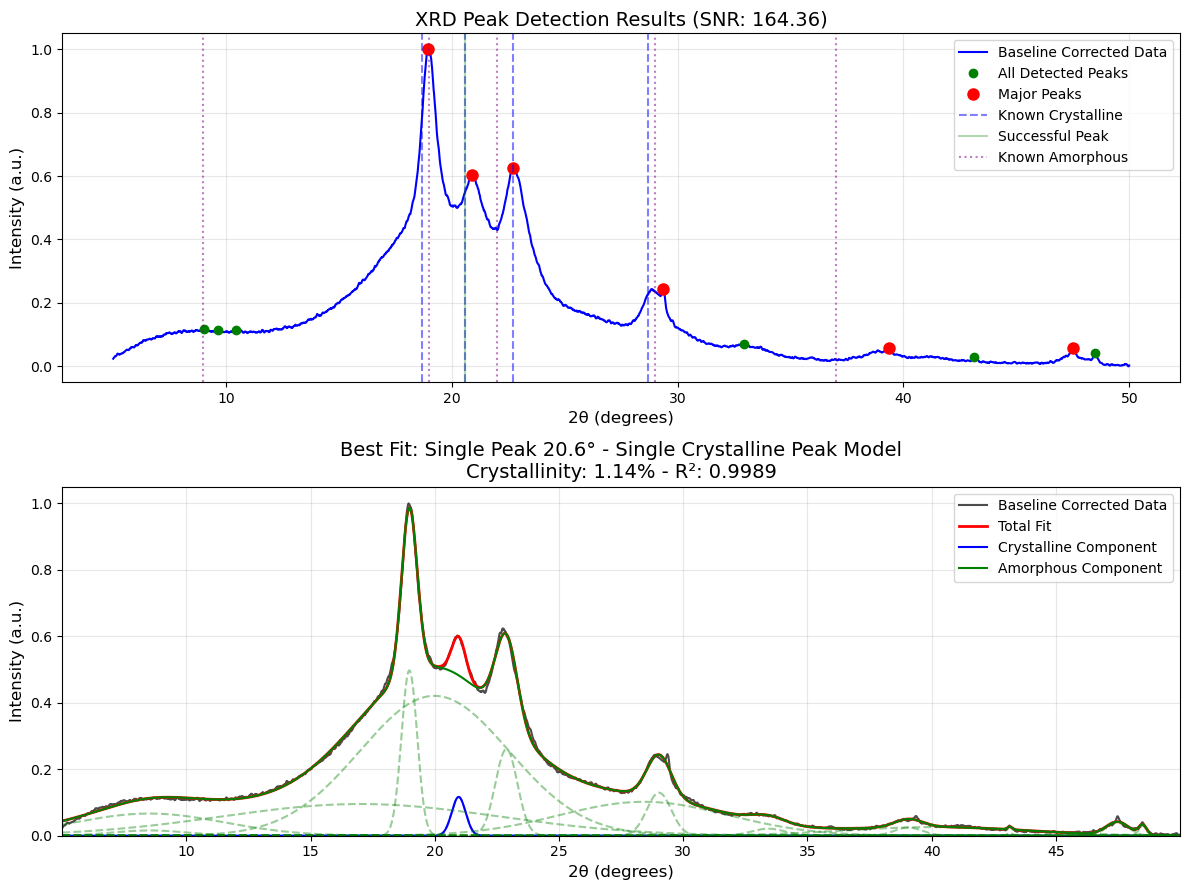

Processing file: 501024_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9107

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal R² change: -0.9321
  Testing peak at 20.6°...
  Peak at 20.6°: SUCCESSFUL - R² = 0.9991 (+0.0884), Crystallinity = 1.28%
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal R² change: -0.8029
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: NOT DETECTED as crystalline
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: SUCCESSFUL - Combined fit with R² = 0.9991, Crystallinity = 1.28%

Selected Combined (1 Peaks) model with R² = 0.

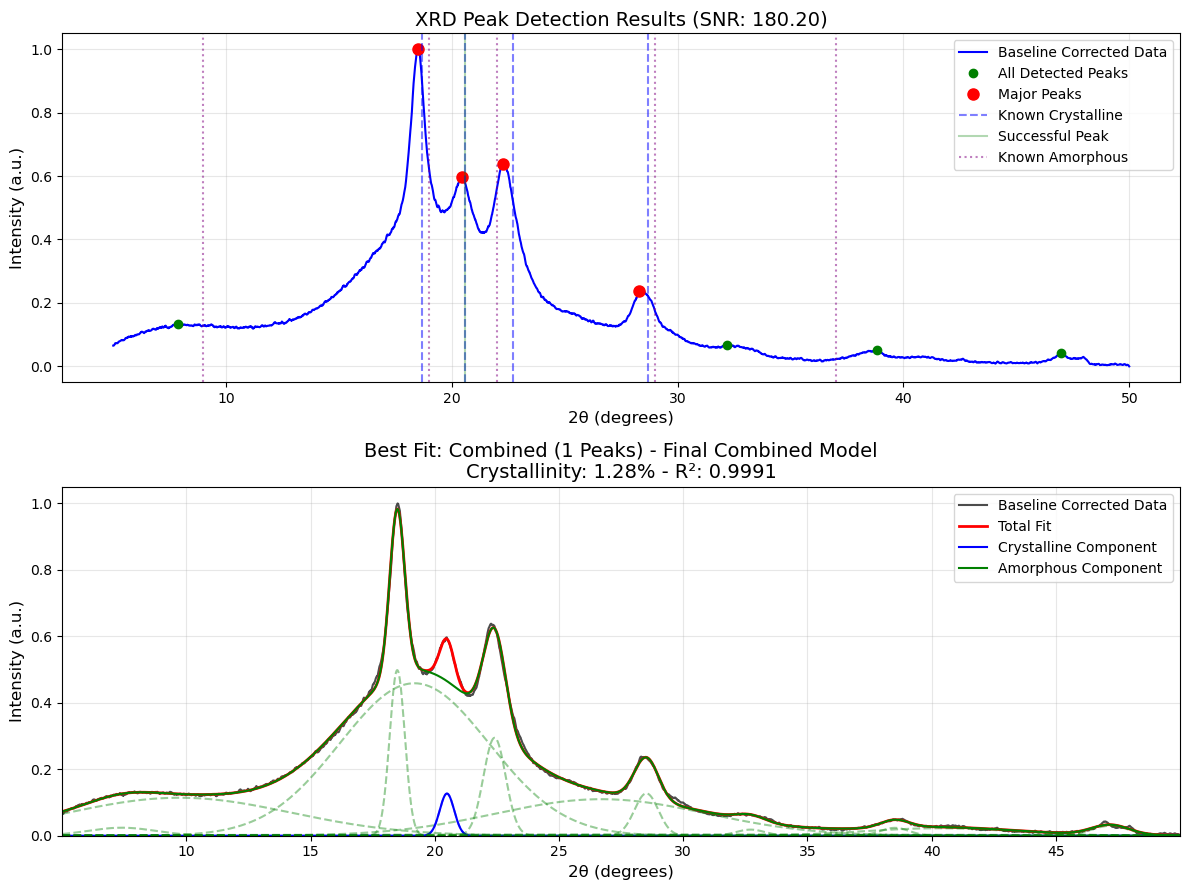

Processing file: HDPE.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.3187

Phase 2: Testing each crystalline peak individually...
  Testing peak at 21.5°...
  Peak at 21.5°: DETECTED but R² = 0.9795 < 0.9990
  Testing peak at 23.9°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 23.9°: DETECTED but minimal R² change: -0.1171
  Testing peak at 30.0°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 30.0°: NOT DETECTED as crystalline
  Testing peak at 36.2°...
  Peak at 36.2°: NOT DETECTED as crystalline

  No peaks met R² threshold, but best peak at 21.5° with R² = 0.9795 shows improvement
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: INSUFFICIENT - Combined fit with R² = 0.9795 < 0.9990

Selected Single Peak 21.5° model with R² = 0.9795


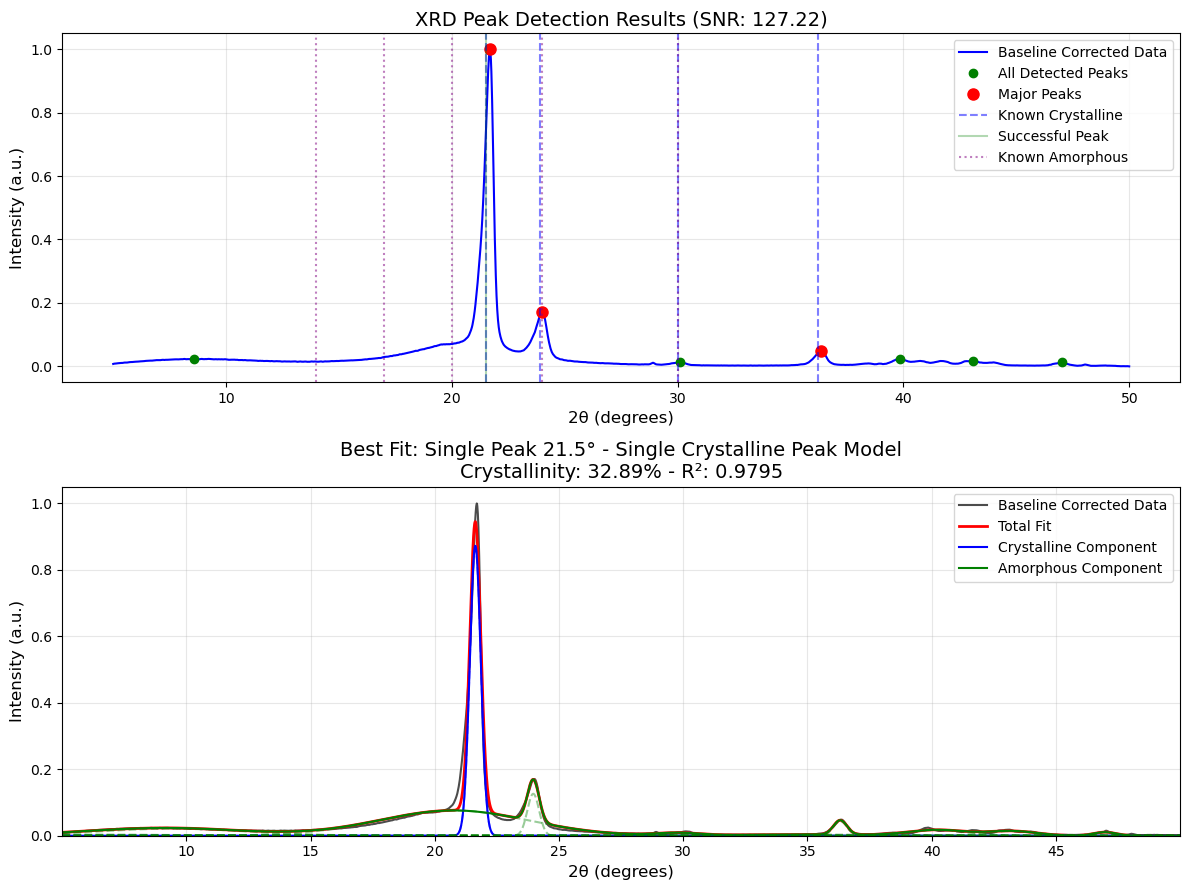

Processing file: HDPE_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.2892

Phase 2: Testing each crystalline peak individually...
  Testing peak at 21.5°...
  Peak at 21.5°: DETECTED but R² = 0.9732 < 0.9990
  Testing peak at 23.9°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 23.9°: DETECTED but minimal R² change: 0.0068
  Testing peak at 30.0°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 30.0°: NOT DETECTED as crystalline
  Testing peak at 36.2°...
  Peak at 36.2°: NOT DETECTED as crystalline

  No peaks met R² threshold, but best peak at 21.5° with R² = 0.9732 shows improvement
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: INSUFFICIENT - Combined fit with R² = 0.9732 < 0.9990

Selected Single Peak 21.5° model with R² = 0.9732


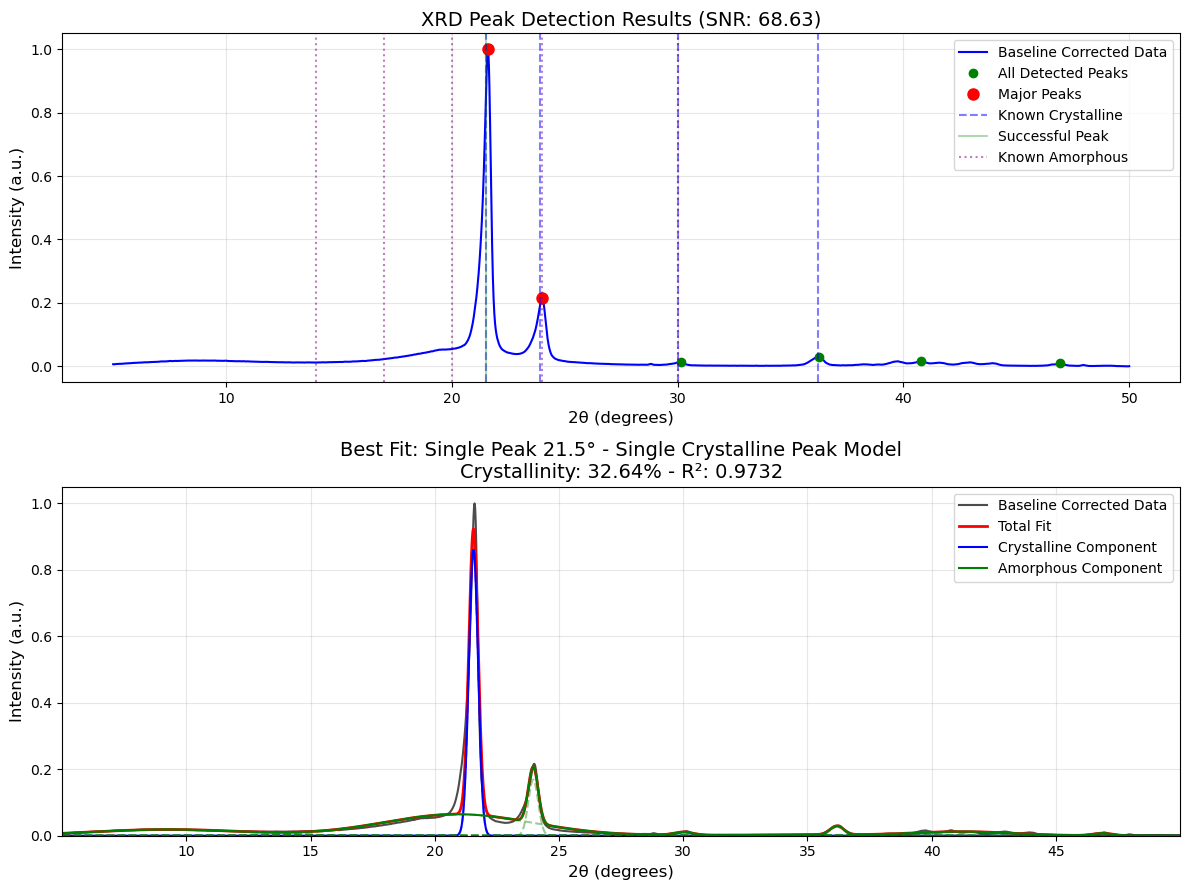

In [63]:
known_crys_peaks_dict = {
    'PEEK': [18.7, 20.6, 22.7, 28.7],   # (110), (111), (200), (211) 
    'HDPE': [21.5, 23.9, 30.0, 36.2,] # (110), (200), (210), (020)
}

known_amorp_peaks_dict = {
    'PEEK': [9, 19, 22, 29, 37],
    'HDPE': [14, 17, 20, 24, 30]
}

cryst_dict = {}
for file in all_files:
    print(f"Processing file: {file}")
    if 'HDPE' in file:
        polymer = 'HDPE'
    else:
        polymer = 'PEEK'
    data = df_dict[file]
    intensity = data['Intensity_norm'].values
    two_theta = data['2Theta'].values
    
    results = fit_xrd_spectrum(two_theta, intensity, 
                               known_crys_peaks=known_crys_peaks_dict.get(polymer, None),
                               known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
                               height_width_threshold=0.25, min_r_squared=0.999, 
                               visualise=True)
    
    cryst_dict[file] = results['crystallinity']

#### Iteration 3.2

Key Improvements

Local R² Evaluation:
- Added `calculate_local_r2()` function that calculates R² in a focused window around each peak (±2° by default)
- Compares the local fit quality between single-peak and amorphous-only models

Modified Decision Criteria:
- Now considers local R² improvement as primary metric for peak significance
- Uses a 5% local R² improvement threshold to identify meaningful peaks
- For peaks with substantial local improvement (>15%), includes them even if overall R² doesn't meet threshold

Enhanced Visualization:
- Added window regions to the visualization to show which areas were used for local R² calculation
- Displays both local and overall R² in the console output

Results Storage:
- Added `peak_local_r2_values` dictionary to store and report local fit quality
- Maintains both global and local metrics for each peak

In [64]:
def _perform_fitting(two_theta, baseline_corrected_intensity, known_crys_peaks, known_amorp_peaks,
                    min_prominence, height_width_threshold, with_crystalline=True):
    """
    Internal helper function to perform the XRD spectrum fitting process.
    This encapsulates the peak detection, fitting and classification logic.
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    baseline_corrected_intensity : array-like
        Baseline-corrected and normalized intensity values
    known_crys_peaks : list
        List of known crystalline peak positions from literature
    known_amorp_peaks : list
        List of known amorphous peak positions
    min_prominence : float
        Minimum prominence for peak detection
    height_width_threshold : float
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    with_crystalline : bool, default=True
        Whether to include crystalline components in the fit
        
    Returns:
    --------
    dict
        Dictionary containing fitting results, parameters and metrics
    """
    # --- Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=min_prominence,  
                             width=10,
                             distance=50)
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # --- Set Up Initial Guesses ---
    init_guess = []
    
    # Set tolerance for peak matching
    known_peak_tolerance = 1.0  # Tolerance in degrees
    
    # Add known crystalline peaks if in crystalline fitting mode
    if with_crystalline and known_crys_peaks:
        for known_pos in known_crys_peaks:
            # Check if a detected peak is near this position
            nearby_peak_idx = None
            for i, pos in enumerate(peak_positions):
                if abs(pos - known_pos) < known_peak_tolerance:
                    nearby_peak_idx = i
                    break
                    
            if nearby_peak_idx is not None:
                # Use the detected peak's height and estimate width
                height = peak_heights[nearby_peak_idx]
                width = peak_widths_degrees[nearby_peak_idx] if nearby_peak_idx < len(peak_widths_degrees) else 0.5
                init_guess.extend([height, known_pos, width])
            else:
                # No nearby detected peak, estimate parameters based on data at this position
                nearby_idx = np.argmin(np.abs(two_theta - known_pos))
                height_estimate = baseline_corrected_intensity[nearby_idx] * 0.8
                init_guess.extend([height_estimate, known_pos, 0.5])
    
    # Add detected peaks not near known crystalline peaks if in crystalline mode
    if with_crystalline:
        for i, pos in enumerate(peak_positions):
            # Skip if this peak is already accounted for (near a known peak)
            if known_crys_peaks and any(abs(pos - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks):
                continue
                
            # Check if this peak might be overlapping with others
            is_overlapping = False
            for j, other_pos in enumerate(peak_positions):
                if i != j and abs(pos - other_pos) < 1.0:
                    is_overlapping = True
                    break
            
            # Determine appropriate width estimate
            if i < len(peak_widths_degrees):
                width_estimate = peak_widths_degrees[i]
                # Adjust width for overlapping peaks
                if is_overlapping:
                    width_estimate = max(0.3, width_estimate * 0.7)  # Narrower for overlapping peaks
            else:
                width_estimate = 0.5  # Default if width couldn't be determined
            
            # Add parameters [amplitude, position, width]
            init_guess.extend([peak_heights[i], pos, width_estimate])
    
    # Add amorphous background peaks
    if not known_amorp_peaks:
        # Default amorphous peaks if not specified
        known_amorp_peaks = [20, 30]
        
    num_amorphous_peaks = len(known_amorp_peaks)
    mean_intensity = np.mean(baseline_corrected_intensity)
    
    for pos in known_amorp_peaks:
        init_guess.extend([mean_intensity/2, pos, 5.0])  # amplitude, position, width
    
    # If no components were added at all, add a minimal set
    if len(init_guess) == 0:
        # Add a broad amorphous component
        init_guess.extend([0.5, 25, 10.0])  # amplitude, position, width
        num_amorphous_peaks = 1
    
    # --- Set up boundary constraints ---
    bounds_low = []
    bounds_high = []
    
    # For each parameter triplet in the initial guess
    param_index = 0
    while param_index < len(init_guess):
        amp = init_guess[param_index]
        center = init_guess[param_index + 1]
        width = init_guess[param_index + 2]
        
        # Check if this is likely a crystalline peak based on its width or if it's a known crystalline position
        is_crystalline = False
        if with_crystalline:
            if width < 2.0:  # Width-based classification
                is_crystalline = True
            elif known_crys_peaks:  # Position-based classification
                is_crystalline = any(abs(center - known_pos) < known_peak_tolerance for known_pos in known_crys_peaks)
        
        if is_crystalline:
            # Crystalline peak bounds
            bounds_low.extend([0, center - 0.5, 0.1])
            bounds_high.extend([np.inf, center + 0.5, 2.0])
        else:
            # Amorphous peak bounds
            bounds_low.extend([0, center - 5, 3.0])
            bounds_high.extend([np.inf, center + 5, 15.0])
            
        param_index += 3
    
    # --- Perform Gaussian Fitting ---
    try:
        # Define Gaussian function for fitting
        def gaussian(x, A, x0, sigma):
            """Gaussian function with parameters amplitude, center, and width"""
            return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
        
        def multi_gaussian(x, *params):
            """Fit multiple Gaussian peaks simultaneously"""
            num_peaks = len(params) // 3
            y_fit = np.zeros_like(x)
            for i in range(num_peaks):
                amp = params[3*i]
                center = params[3*i+1]
                width = params[3*i+2]
                y_fit += gaussian(x, amp, center, width)
            return y_fit
        
        # Perform the fit
        popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity, 
                              p0=init_guess, bounds=(bounds_low, bounds_high),
                              maxfev=20000)  # Increase maximum function evaluations
    except Exception as e:
        print(f"Fitting error: {str(e)}")
        print("Falling back to initial guess parameters")
        popt = np.array(init_guess)
    
    # --- Separate Components Based on Height-to-Width Ratio ---
    crystalline_params = []
    amorphous_params = []
    
    # Process fitted parameters
    for i in range(0, len(popt), 3):
        if i+2 >= len(popt):  # Safety check
            break
            
        amp = popt[i]
        center = popt[i+1]
        width = popt[i+2]
        hw_ratio = amp / width if width > 0 else 0  # Height-to-width ratio
        
        # Skip peaks with near-zero amplitude
        if amp < 0.001:
            continue
        
        # Check if this matches a known crystalline peak position
        is_known_crys_pos = False
        if known_crys_peaks and with_crystalline:
            is_known_crys_pos = any(abs(center - known_pos) < known_peak_tolerance 
                                  for known_pos in known_crys_peaks)
        
        # Classify peak - consider both ratio and position
        if with_crystalline and (is_known_crys_pos or hw_ratio > height_width_threshold) and width < 2.0:
            # This is likely a crystalline peak
            crystalline_params.extend([amp, center, width])
        else:
            # This is likely an amorphous peak
            amorphous_params.extend([amp, center, width])
    
    # --- Calculate Individual Components ---
    crystalline_fit = np.zeros_like(two_theta)
    if crystalline_params:
        crystalline_fit = multi_gaussian(two_theta, *crystalline_params)
        
    amorphous_fit = np.zeros_like(two_theta)
    if amorphous_params:
        amorphous_fit = multi_gaussian(two_theta, *amorphous_params)
        
    total_fit = crystalline_fit + amorphous_fit
    
    # --- Calculate Crystallinity Index ---
    area_crystalline = np.trapz(crystalline_fit, two_theta)
    area_amorphous = np.trapz(amorphous_fit, two_theta)
    area_total = area_crystalline + area_amorphous
    
    if area_total > 0:
        crystallinity = (area_crystalline / area_total) * 100
    else:
        crystallinity = 0.0
    
    # --- Calculate Goodness of Fit ---
    residuals = baseline_corrected_intensity - total_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((baseline_corrected_intensity - np.mean(baseline_corrected_intensity))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    rmse = np.sqrt(np.mean(residuals**2))
    
    # --- Organize fitted peaks for reporting ---
    crystalline_peak_data = []
    for i in range(0, len(crystalline_params), 3):
        if i+2 >= len(crystalline_params):
            break
        crystalline_peak_data.append({
            'amplitude': crystalline_params[i],
            'position': crystalline_params[i+1], 
            'width': crystalline_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     crystalline_params[i], 
                                     crystalline_params[i+1], 
                                     crystalline_params[i+2]), 
                            two_theta)
        })
    
    amorphous_peak_data = []
    for i in range(0, len(amorphous_params), 3):
        if i+2 >= len(amorphous_params):
            break
        amorphous_peak_data.append({
            'amplitude': amorphous_params[i],
            'position': amorphous_params[i+1], 
            'width': amorphous_params[i+2],
            'area': np.trapz(gaussian(two_theta, 
                                     amorphous_params[i], 
                                     amorphous_params[i+1], 
                                     amorphous_params[i+2]), 
                            two_theta)
        })
    
    # Return fitting results
    results = {
        'major_peaks': major_peaks,
        'all_peaks': all_peaks,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'optimized_parameters': popt,
        'crystalline_params': crystalline_params,
        'amorphous_params': amorphous_params,
        'crystalline_fit': crystalline_fit,
        'amorphous_fit': amorphous_fit,
        'total_fit': total_fit,
        'crystallinity': crystallinity,
        'r_squared': r_squared,
        'rmse': rmse,
        'residuals': residuals,
        'crystalline_peak_data': crystalline_peak_data,
        'amorphous_peak_data': amorphous_peak_data
    }
    
    return results

In [65]:
def fit_xrd_spectrum(two_theta, intensity, known_crys_peaks=None, known_amorp_peaks=None, 
                     height_width_threshold=0.3, min_prominence=0.008, 
                     min_r_squared=0.85, amorphous_r_squared=0.80, visualise=True):
    """
    Efficient XRD analysis function using a build-up strategy:
    1. Start with amorphous-only fit
    2. Test individual crystalline peaks for significance in localized regions
    3. Combine successful crystalline peaks for final model
    
    Parameters:
    -----------
    two_theta : array-like
        Array of 2θ angles in degrees
    intensity : array-like
        Array of corresponding intensity values
    known_crys_peaks : list or None, optional
        List of known crystalline peak positions from literature
    known_amorp_peaks : list or None, optional
        List of known amorphous peak positions
    height_width_threshold : float, default=0.3
        Threshold for distinguishing crystalline/amorphous peaks by height-to-width ratio
    min_prominence : float, default=0.008
        Minimum prominence for peak detection
    min_r_squared : float, default=0.85
        Minimum R² value for considering a fit successful
    amorphous_r_squared : float, default=0.80
        Lower threshold for amorphous-only fit acceptability
    visualise : bool, default=True
        Whether to generate visualization plots
        
    Returns:
    --------
    dict
        Dictionary containing peak information, fitted parameters, and crystallinity
    """
    # Set default values if None is provided
    if known_crys_peaks is None:
        known_crys_peaks = []  
        
    if known_amorp_peaks is None:
        known_amorp_peaks = [20, 30]  # Default amorphous peak positions
    
    # --- Step 1: Data Preprocessing ---
    # Normalize intensity
    normalized_intensity = intensity / np.max(intensity)
    
    # Smooth the normalized data
    smoothed_intensity = savgol_filter(normalized_intensity, window_length=15, polyorder=3)
    
    # --- Step 2: Baseline Correction ---
    # Method: Find the minimum value of smoothed intensity as baseline level
    baseline_level = np.min(smoothed_intensity)
    
    # Subtract baseline level from smoothed intensity
    baseline_corrected_intensity = smoothed_intensity - baseline_level
    
    # Ensure no negative values
    baseline_corrected_intensity = np.maximum(baseline_corrected_intensity, 0)
    
    # Renormalize after baseline correction
    if np.max(baseline_corrected_intensity) > 0:
        baseline_corrected_intensity = baseline_corrected_intensity / np.max(baseline_corrected_intensity)
    
    # --- Step 3: Assess Signal Quality ---
    # Calculate signal-to-noise ratio
    signal_mean = np.mean(baseline_corrected_intensity)
    noise_estimate = np.std(baseline_corrected_intensity - 
                           savgol_filter(baseline_corrected_intensity, window_length=21, polyorder=3))
    snr = signal_mean / noise_estimate if noise_estimate > 0 else 0
    
    # Adjust peak detection parameters based on signal quality
    adjusted_min_prominence = min_prominence
    if snr < 5:  # Low SNR
        print(f"Low signal-to-noise ratio detected ({snr:.2f}). Adjusting detection parameters.")
        adjusted_min_prominence = min_prominence * 1.5  # Increase prominence threshold for noisy data
    
    # Check if data has any significant peaks at all
    max_peak_height = np.max(baseline_corrected_intensity)
    is_mostly_amorphous = max_peak_height < 0.1  # Very low peak height suggests mostly amorphous
    
    if is_mostly_amorphous:
        print("Sample appears to be predominantly amorphous.")
    
    # --- Step 4: Define Gaussian Functions ---
    def gaussian(x, A, x0, sigma):
        """Gaussian function with parameters amplitude, center, and width"""
        return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
    
    def multi_gaussian(x, *params):
        """Fit multiple Gaussian peaks simultaneously"""
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)
        for i in range(num_peaks):
            amp = params[3*i]
            center = params[3*i+1]
            width = params[3*i+2]
            y_fit += gaussian(x, amp, center, width)
        return y_fit
    
    # --- Step 5: Run Peak Detection ---
    # First pass with less strict parameters to find major peaks
    major_peaks, _ = find_peaks(baseline_corrected_intensity, 
                               prominence=adjusted_min_prominence * 5,
                               width=20,
                               distance=50)
    
    # Second pass with more sensitive settings to detect shoulders and overlaps
    all_peaks, _ = find_peaks(baseline_corrected_intensity,
                             prominence=adjusted_min_prominence,  
                             width=10,         
                             distance=50)      
    
    # Use peak properties to get a better estimate of peak widths
    _, properties = find_peaks(baseline_corrected_intensity, 
                              prominence=adjusted_min_prominence,
                              width=10,
                              distance=20,
                              rel_height=0.5)  # For width at half maximum
    
    # Extract peak information
    peak_positions = two_theta[all_peaks] if len(all_peaks) > 0 else np.array([])
    peak_heights = baseline_corrected_intensity[all_peaks] if len(all_peaks) > 0 else np.array([])
    
    # Calculate peak widths in degrees
    if len(properties["widths"]) > 0:
        peak_widths_points = properties["widths"]
        peak_distances = np.diff(two_theta)
        avg_point_distance = np.mean(peak_distances)
        peak_widths_degrees = peak_widths_points * avg_point_distance
    else:
        peak_widths_degrees = np.array([])
    
    # --- Step 6: Build-Up Fitting Strategy ---
    phase_success = {"amorphous": False, "individual_peaks": False, "combined": False}
    fitting_results = {}
    
    # PHASE 1: Start with amorphous-only fit
    print("\nPhase 1: Performing amorphous-only fit...")
    amorphous_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                       [], known_amorp_peaks,
                                       adjusted_min_prominence, height_width_threshold,
                                       with_crystalline=False)
    
    # Store amorphous-only results
    fitting_results["amorphous"] = {
        "name": "Amorphous Only",
        "model": amorphous_results
    }
    
    # Check if amorphous fit is excellent (exceeds normal threshold)
    if amorphous_results['r_squared'] >= min_r_squared:
        print(f"Phase 1: EXCELLENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
        phase_success["amorphous"] = True
        best_fit = amorphous_results
        best_fit_name = "Amorphous Only"
    else:
        # Check if amorphous fit is at least acceptable
        amorphous_acceptable = amorphous_results['r_squared'] >= amorphous_r_squared
        if amorphous_acceptable:
            print(f"Phase 1: ACCEPTABLE - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
            phase_success["amorphous"] = True
        else:
            print(f"Phase 1: INSUFFICIENT - Amorphous-only fit with R² = {amorphous_results['r_squared']:.4f}")
    
    # PHASE 2: Test individual crystalline peaks if we have any
    successful_peaks = []
    peak_r2_values = {}
    peak_local_r2_values = {}
    best_individual_r2 = 0
    best_individual_results = None
    best_individual_peak = None
    
    if known_crys_peaks:
        print("\nPhase 2: Testing each crystalline peak individually...")
        
        # Function to calculate local R² in region around peak
        def calculate_local_r2(peak_pos, data, fit, two_theta, window_width=4.0):
            """Calculate R² in a window around a specific peak position"""
            # Define window boundaries (±window_width/2 degrees around peak)
            window_min = peak_pos - window_width/2
            window_max = peak_pos + window_width/2
            
            # Get indices for the window
            window_indices = np.where((two_theta >= window_min) & (two_theta <= window_max))[0]
            
            if len(window_indices) < 5:  # Need minimum points for meaningful calculation
                return 0.0
                
            # Calculate local R² within window
            local_data = data[window_indices]
            local_fit = fit[window_indices]
            
            local_residuals = local_data - local_fit
            local_ss_res = np.sum(local_residuals**2)
            local_ss_tot = np.sum((local_data - np.mean(local_data))**2)
            
            if local_ss_tot == 0:  # Avoid division by zero
                return 0.0
                
            local_r2 = 1 - (local_ss_res / local_ss_tot)
            return local_r2
        
        for peak_pos in known_crys_peaks:
            try:
                print(f"  Testing peak at {peak_pos}°...")
                single_peak_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                                   [peak_pos], known_amorp_peaks,
                                                   adjusted_min_prominence, height_width_threshold)
                
                # Record overall R² value for this peak
                peak_r2_values[peak_pos] = single_peak_results['r_squared']
                
                # Calculate local R² in region around this peak
                local_r2_single = calculate_local_r2(
                    peak_pos, 
                    baseline_corrected_intensity, 
                    single_peak_results['total_fit'], 
                    two_theta, 
                    window_width=4.0  # 4 degrees window around peak
                )
                
                local_r2_amorphous = calculate_local_r2(
                    peak_pos, 
                    baseline_corrected_intensity, 
                    amorphous_results['total_fit'], 
                    two_theta, 
                    window_width=4.0
                )
                
                # Save local R² values for reporting
                peak_local_r2_values[peak_pos] = {
                    'single_peak_model': local_r2_single,
                    'amorphous_model': local_r2_amorphous
                }
                
                # Calculate local improvement from adding this crystalline peak
                local_r2_improvement = local_r2_single - local_r2_amorphous
                
                # Check if this peak provides any crystallinity
                has_crystallinity = single_peak_results['crystallinity'] > 0
                
                # Calculate overall improvement over amorphous-only model
                overall_r2_improvement = single_peak_results['r_squared'] - amorphous_results['r_squared']
                
                # Track best individual peak fit regardless of threshold
                if has_crystallinity and single_peak_results['r_squared'] > best_individual_r2:
                    best_individual_r2 = single_peak_results['r_squared']
                    best_individual_results = single_peak_results
                    best_individual_peak = peak_pos
                
                # Consider peak successful if:
                # 1. It contributes to crystallinity
                # 2. It improves LOCAL R² by a meaningful amount
                # 3. Overall R² still meets minimum threshold
                if has_crystallinity and local_r2_improvement > 0.05:  # 5% local improvement threshold
                    if single_peak_results['r_squared'] >= min_r_squared:
                        successful_peaks.append(peak_pos)
                        print(f"  Peak at {peak_pos}°: SUCCESSFUL - Local R² improvement: +{local_r2_improvement:.4f}, "
                              f"Overall R² = {single_peak_results['r_squared']:.4f}, "
                              f"Crystallinity = {single_peak_results['crystallinity']:.2f}%")
                    else:
                        print(f"  Peak at {peak_pos}°: DETECTED with good local fit (+{local_r2_improvement:.4f}) but "
                              f"overall R² = {single_peak_results['r_squared']:.4f} < {min_r_squared:.4f}")
                        # Consider adding peak anyway if local improvement is substantial
                        if local_r2_improvement > 0.15:  # 15% is substantial local improvement
                            successful_peaks.append(peak_pos)
                            print(f"    - Adding anyway due to substantial local improvement")
                elif has_crystallinity:
                    print(f"  Peak at {peak_pos}°: DETECTED but minimal local R² improvement: +{local_r2_improvement:.4f}")
                else:
                    print(f"  Peak at {peak_pos}°: NOT DETECTED as crystalline")
                    
            except Exception as e:
                print(f"  Peak at {peak_pos}°: ERROR - {str(e)}")
        
        # Store best individual peak result if we found one
        if best_individual_results is not None:
            fitting_results["individual_peak"] = {
                "name": f"Single Peak {best_individual_peak}°",
                "model": best_individual_results,
                "peak_position": best_individual_peak,
                "local_r2_values": peak_local_r2_values.get(best_individual_peak, {})
            }
            
            # If no peaks met our threshold but we have a best peak, consider it
            if not successful_peaks and best_individual_peak is not None:
                local_improvement = peak_local_r2_values.get(best_individual_peak, {}).get('single_peak_model', 0) - \
                                   peak_local_r2_values.get(best_individual_peak, {}).get('amorphous_model', 0)
                if local_improvement > 0.05:  # Modest local improvement
                    print(f"\n  No peaks met overall R² threshold, but best peak at {best_individual_peak}° "
                          f"with local R² improvement of +{local_improvement:.4f} will be included")
                    successful_peaks.append(best_individual_peak)
        
        # Update phase success
        phase_success["individual_peaks"] = len(successful_peaks) > 0
        if phase_success["individual_peaks"]:
            print(f"Phase 2: SUCCESSFUL - {len(successful_peaks)} crystalline peaks identified")
        else:
            print("Phase 2: FAILED - No significant crystalline peaks identified")
    else:
        print("\nPhase 2: SKIPPED - No known crystalline peaks provided")
    
    # PHASE 3: Final combined fit if we found any successful peaks
    if successful_peaks:
        print(f"\nPhase 3: Performing final combined fit with {len(successful_peaks)} crystalline peaks...")
        try:
            combined_results = _perform_fitting(two_theta, baseline_corrected_intensity,
                                             successful_peaks, known_amorp_peaks,
                                             adjusted_min_prominence, height_width_threshold)
            
            # Store combined results
            fitting_results["combined"] = {
                "name": f"Combined ({len(successful_peaks)} Peaks)",
                "model": combined_results,
                "used_peaks": successful_peaks
            }
            
            # Check if combined fit is successful
            if combined_results['r_squared'] >= min_r_squared:
                print(f"Phase 3: SUCCESSFUL - Combined fit with R² = {combined_results['r_squared']:.4f}, "
                      f"Crystallinity = {combined_results['crystallinity']:.2f}%")
                phase_success["combined"] = True
                best_fit = combined_results
                best_fit_name = f"Combined ({len(successful_peaks)} Peaks)"
            else:
                print(f"Phase 3: INSUFFICIENT - Combined fit with R² = {combined_results['r_squared']:.4f} < {min_r_squared:.4f}")
        except Exception as e:
            print(f"Phase 3: ERROR - {str(e)}")
    else:
        print("\nPhase 3: SKIPPED - No successful crystalline peaks to combine")
    
    # --- Step 7: Select Best Model ---
    # If we haven't already selected a best fit, find the one with highest R²
    if 'best_fit' not in locals():
        best_r2 = 0
        best_fit = None
        best_fit_name = None
        
        for phase, results in fitting_results.items():
            if results["model"]["r_squared"] > best_r2:
                best_r2 = results["model"]["r_squared"]
                best_fit = results["model"]
                best_fit_name = results["name"]
    
    if best_fit is None:
        # Fallback to amorphous-only if nothing else was successful
        best_fit = amorphous_results
        best_fit_name = "Amorphous Only (Default)"
        
    print(f"\nSelected {best_fit_name} model with R² = {best_fit['r_squared']:.4f}")
    
    # --- Step 8: Visualization ---
    if visualise:
        # Create a 2-panel figure: Peak Detection + Best Fit
        plt.figure(figsize=(12, 9))
        
        # Panel 1: Peak Detection Results
        plt.subplot(2, 1, 1)
        plt.plot(two_theta, baseline_corrected_intensity, 'b-', label='Baseline Corrected Data')
        plt.plot(two_theta[all_peaks], baseline_corrected_intensity[all_peaks], 'go', 
                label='All Detected Peaks', markersize=6)
        plt.plot(two_theta[major_peaks], baseline_corrected_intensity[major_peaks], 'ro', 
                label='Major Peaks', markersize=8)
        
        # Mark known crystalline peaks
        if known_crys_peaks:
            for pos in known_crys_peaks:
                plt.axvline(x=pos, color='blue', linestyle='--', alpha=0.5, 
                           label='Known Crystalline' if pos==known_crys_peaks[0] else "")
                
                # Highlight successful peaks
                if pos in successful_peaks:
                    plt.axvline(x=pos, color='green', linestyle='-', alpha=0.3,
                               label='Successful Peak' if pos==successful_peaks[0] else "")
                    
                    # Show local evaluation window for successful peaks
                    plt.axvspan(pos-2, pos+2, color='lightgreen', alpha=0.1)
        
        # Mark known amorphous peaks
        for pos in known_amorp_peaks:
            plt.axvline(x=pos, color='purple', linestyle=':', alpha=0.5,
                       label='Known Amorphous' if pos==known_amorp_peaks[0] else "")
                
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.title(f'XRD Peak Detection Results (SNR: {snr:.2f})', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Panel 2: Best Fit Model
        plt.subplot(2, 1, 2)
        
        # Plot raw data and overall fit
        plt.plot(two_theta, baseline_corrected_intensity, 'k-', alpha=0.7, 
                 label='Baseline Corrected Data')
        plt.plot(two_theta, best_fit['total_fit'], 'r-', 
                 label='Total Fit', linewidth=2)
        
        # Plot components
        if best_fit['crystalline_fit'].any():
            plt.plot(two_theta, best_fit['crystalline_fit'], 'b-', 
                     label='Crystalline Component', linewidth=1.5)
        
        plt.plot(two_theta, best_fit['amorphous_fit'], 'g-', 
                 label='Amorphous Component', linewidth=1.5)

        # Plot individual peaks
        crystalline_params = best_fit['crystalline_params']
        amorphous_params = best_fit['amorphous_params']
        
        for j in range(0, len(crystalline_params), 3):
            amp = crystalline_params[j]
            center = crystalline_params[j+1]
            width = crystalline_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'b--', alpha=0.4)

        for j in range(0, len(amorphous_params), 3):
            amp = amorphous_params[j]
            center = amorphous_params[j+1]
            width = amorphous_params[j+2]
            peak = gaussian(two_theta, amp, center, width)
            plt.plot(two_theta, peak, 'g--', alpha=0.4)

        # Add best fit phase information
        phase_info = ""
        if best_fit_name == "Combined (All Peaks)" or "Combined" in best_fit_name:
            phase_info = "Final Combined Model"
        elif best_fit_name == "Amorphous Only" or "Amorphous Only" in best_fit_name:
            phase_info = "Amorphous-Only Model"
        elif "Single Peak" in best_fit_name:
            phase_info = "Single Crystalline Peak Model"
            
        plt.xlabel('2θ (degrees)', fontsize=12)
        plt.ylabel('Intensity (a.u.)', fontsize=12)
        plt.ylim(bottom=0)
        plt.xlim(left=min(two_theta), right=max(two_theta))
        
        # Display model metrics
        cryst = best_fit['crystallinity']
        r2 = best_fit['r_squared']
        plt.title(f'Best Fit: {best_fit_name} - {phase_info}\n'
                  f'Crystallinity: {cryst:.2f}% - R²: {r2:.4f}', 
                  fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # --- Step 9: Return Results ---
    # Add additional information to the best fit results
    best_fit.update({
        'normalized_intensity': normalized_intensity,
        'smoothed_intensity': smoothed_intensity,
        'baseline_level': baseline_level,
        'baseline_corrected_intensity': baseline_corrected_intensity,
        'signal_to_noise': snr,
        'is_mostly_amorphous': is_mostly_amorphous,
        'phase_success': phase_success,
        'all_models': fitting_results,
        'selected_model': best_fit_name,
        'peak_positions': peak_positions,
        'peak_heights': peak_heights,
        'peak_widths': peak_widths_degrees,
        'all_peaks': all_peaks,
        'major_peaks': major_peaks,
        'successful_peaks': successful_peaks,
        'peak_r2_values': peak_r2_values,
        'peak_local_r2_values': peak_local_r2_values,
        'gaussian_function': gaussian,
        'multi_gaussian_function': multi_gaussian
    })
    
    return best_fit

Processing file: 500907.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9968

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal local R² improvement: +-45.7882
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED but minimal local R² improvement: +0.0097
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal local R² improvement: +-4.2430
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal local R² improvement: +-21.1642
Phase 2: FAILED - No significant crystalline peaks identified

Phase 3: SKIPPED - No successful crystalline peaks to combine

Selected Single Peak 20.6° model with R² = 0.9993


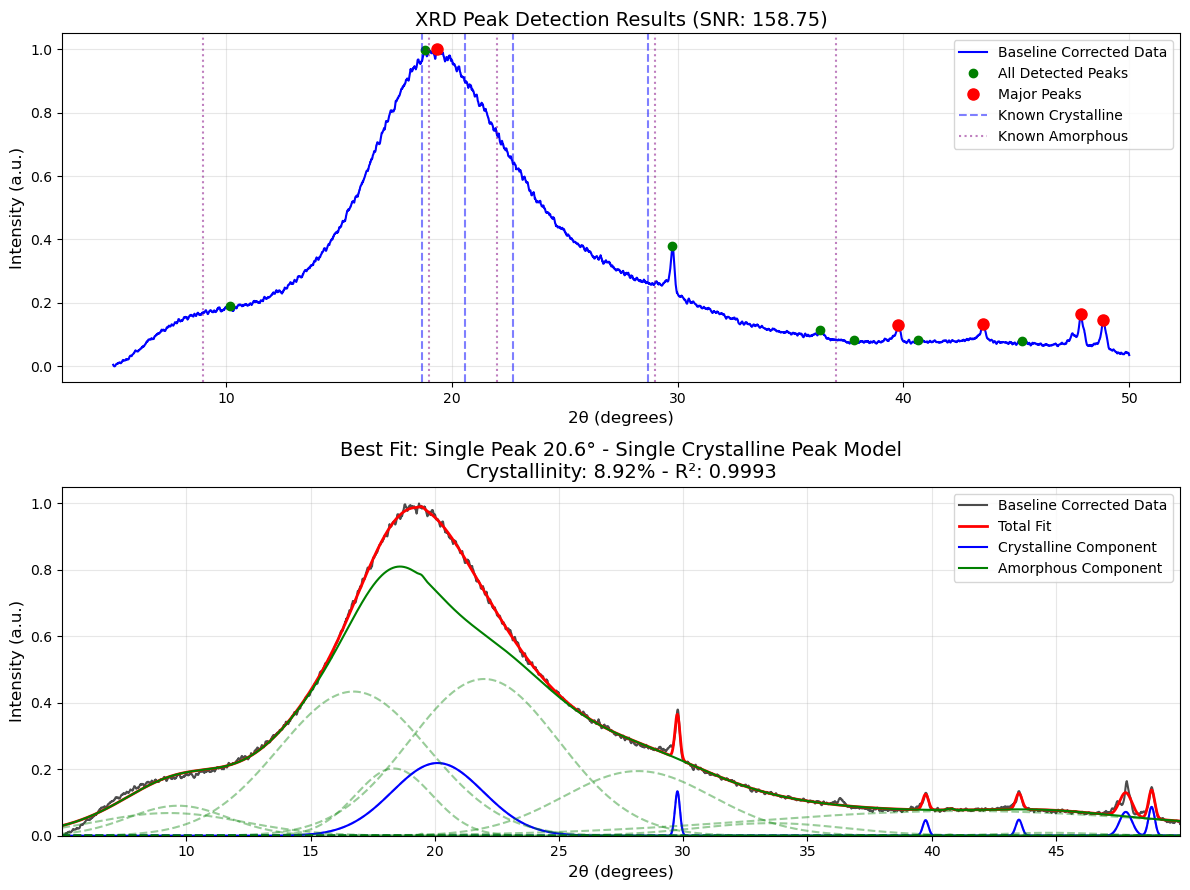

Processing file: 500907_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9977

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal local R² improvement: +-55.6744
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED but minimal local R² improvement: +0.0041
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal local R² improvement: +-28.9936
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal local R² improvement: +-31.9995
Phase 2: FAILED - No significant crystalline peaks identified

Phase 3: SKIPPED - No successful crystalline peaks to combine

Selected Single Peak 20.6° model with R² = 0.9998


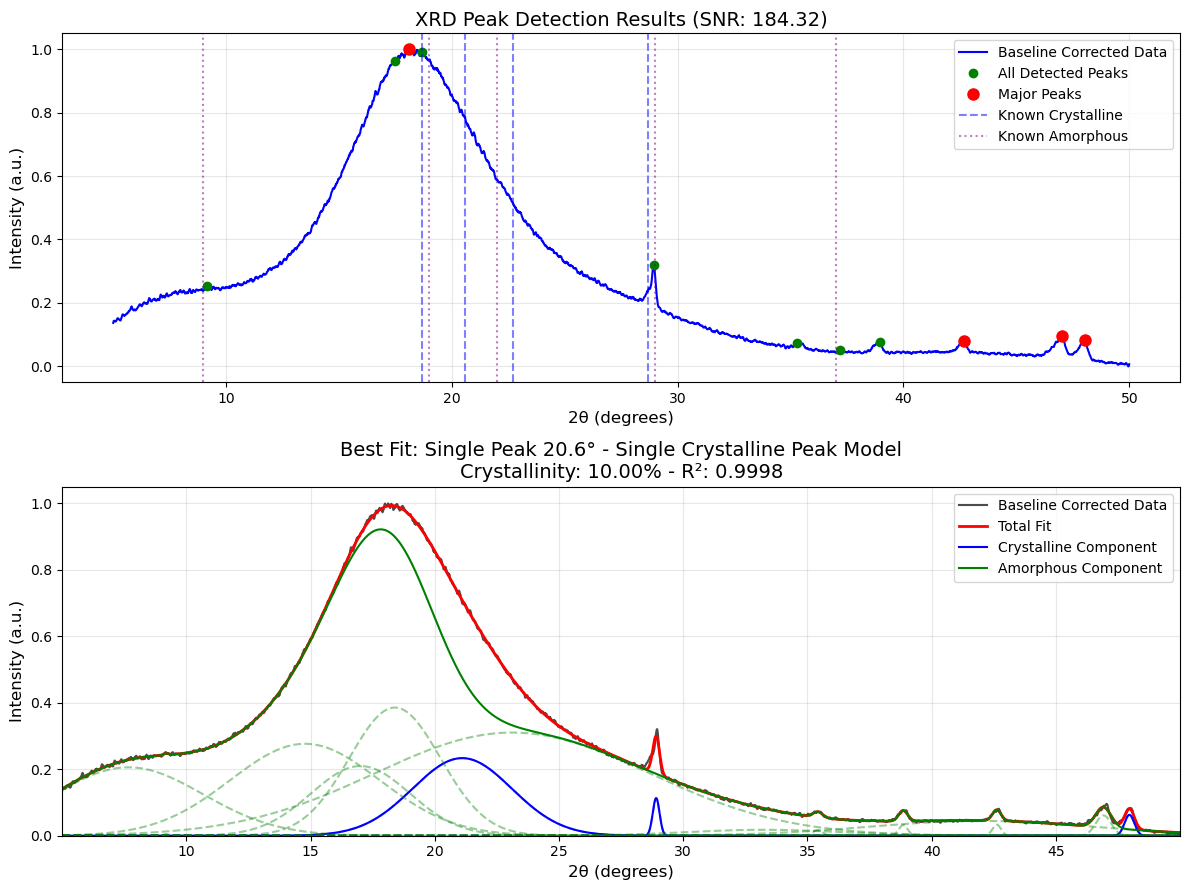

Processing file: 501023.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9418

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal local R² improvement: +-23.2074
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED with good local fit (+1.5356) but overall R² = 0.9567 < 0.9990
    - Adding anyway due to substantial local improvement
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal local R² improvement: +-19.8874
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal local R² improvement: +-14.2238
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Ph

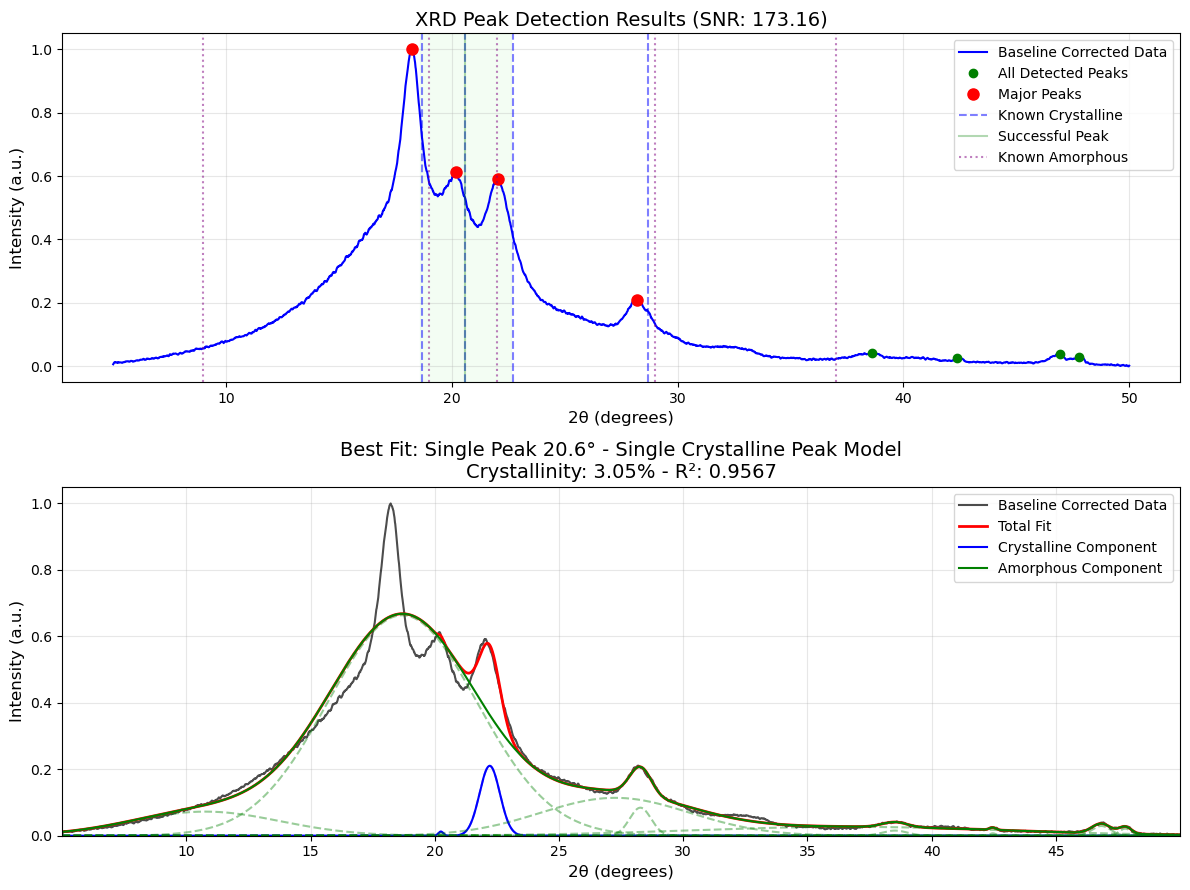

Processing file: 501023_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9288

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal local R² improvement: +-14.4609
  Testing peak at 20.6°...
  Peak at 20.6°: SUCCESSFUL - Local R² improvement: +1.5087, Overall R² = 0.9992, Crystallinity = 11.85%
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal local R² improvement: +-3.9458
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal local R² improvement: +-11.8449
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: SUCCESSFUL - Combined fit with R²

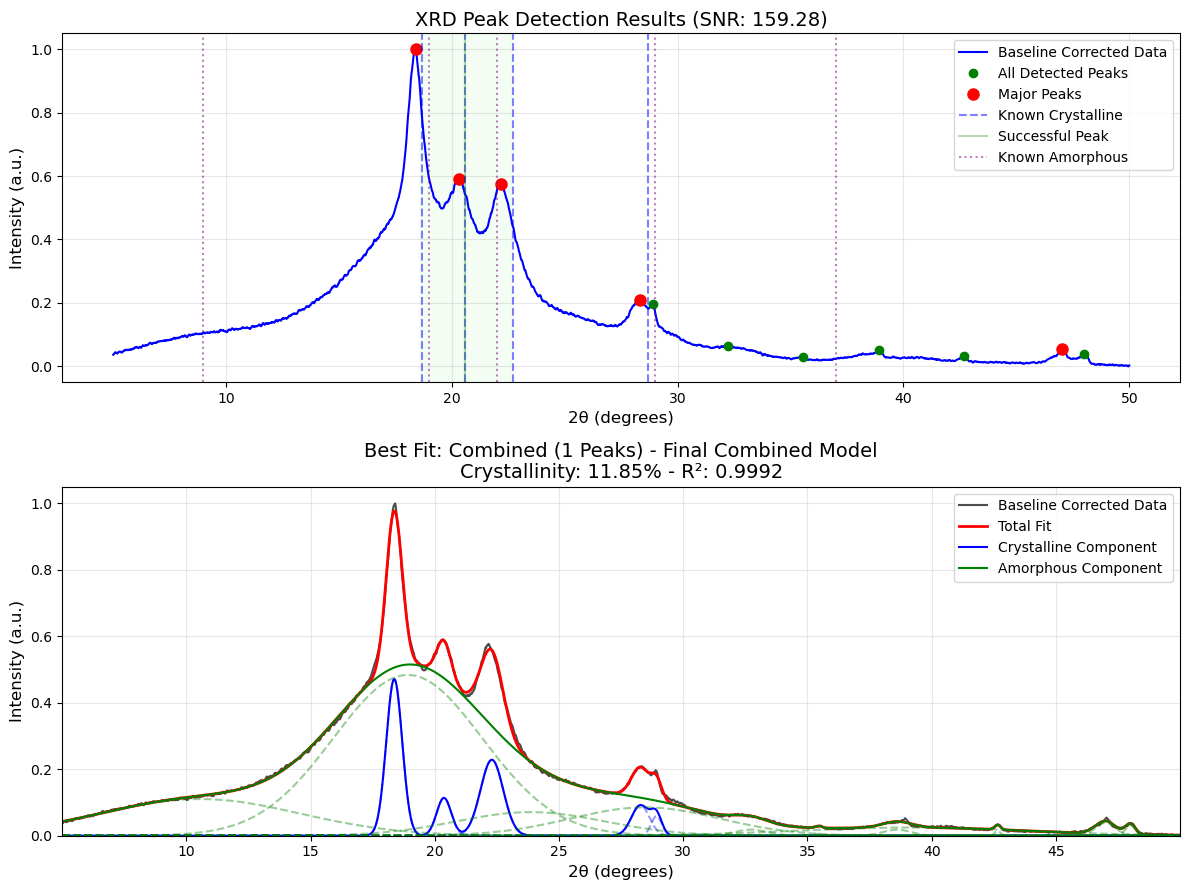

Processing file: 501024.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9159

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal local R² improvement: +-7.0860
  Testing peak at 20.6°...
  Peak at 20.6°: DETECTED with good local fit (+0.9279) but overall R² = 0.9989 < 0.9990
    - Adding anyway due to substantial local improvement
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal local R² improvement: +-8.7769
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal local R² improvement: +-1.2551
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase

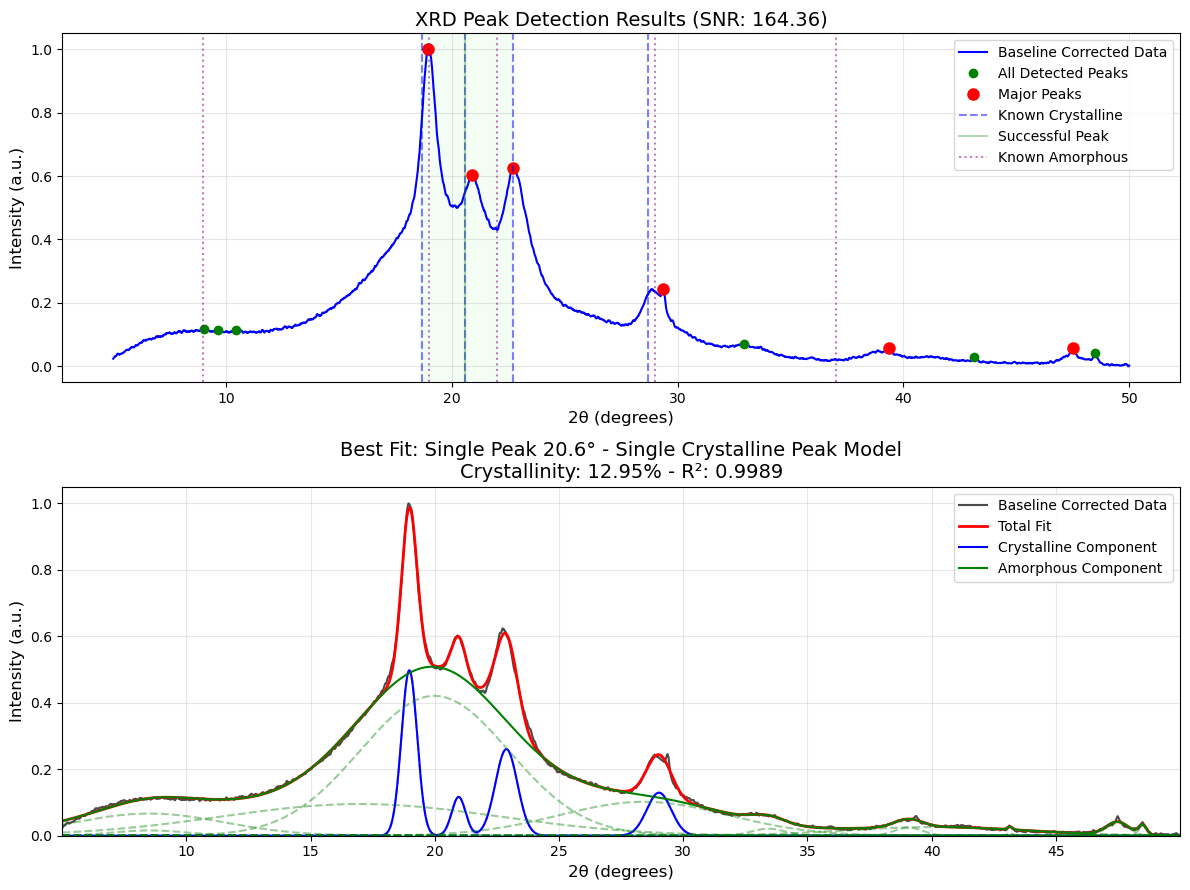

Processing file: 501024_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9107

Phase 2: Testing each crystalline peak individually...
  Testing peak at 18.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 18.7°: DETECTED but minimal local R² improvement: +-8.6451
  Testing peak at 20.6°...
  Peak at 20.6°: SUCCESSFUL - Local R² improvement: +1.4333, Overall R² = 0.9991, Crystallinity = 13.32%
  Testing peak at 22.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 22.7°: DETECTED but minimal local R² improvement: +-2.2821
  Testing peak at 28.7°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 28.7°: DETECTED but minimal local R² improvement: +-8.3619
Phase 2: SUCCESSFUL - 1 crystalline peaks identified

Phase 3: Performing final combined fit with 1 crystalline peaks...
Phase 3: SUCCESSFUL - Combined fit with R² =

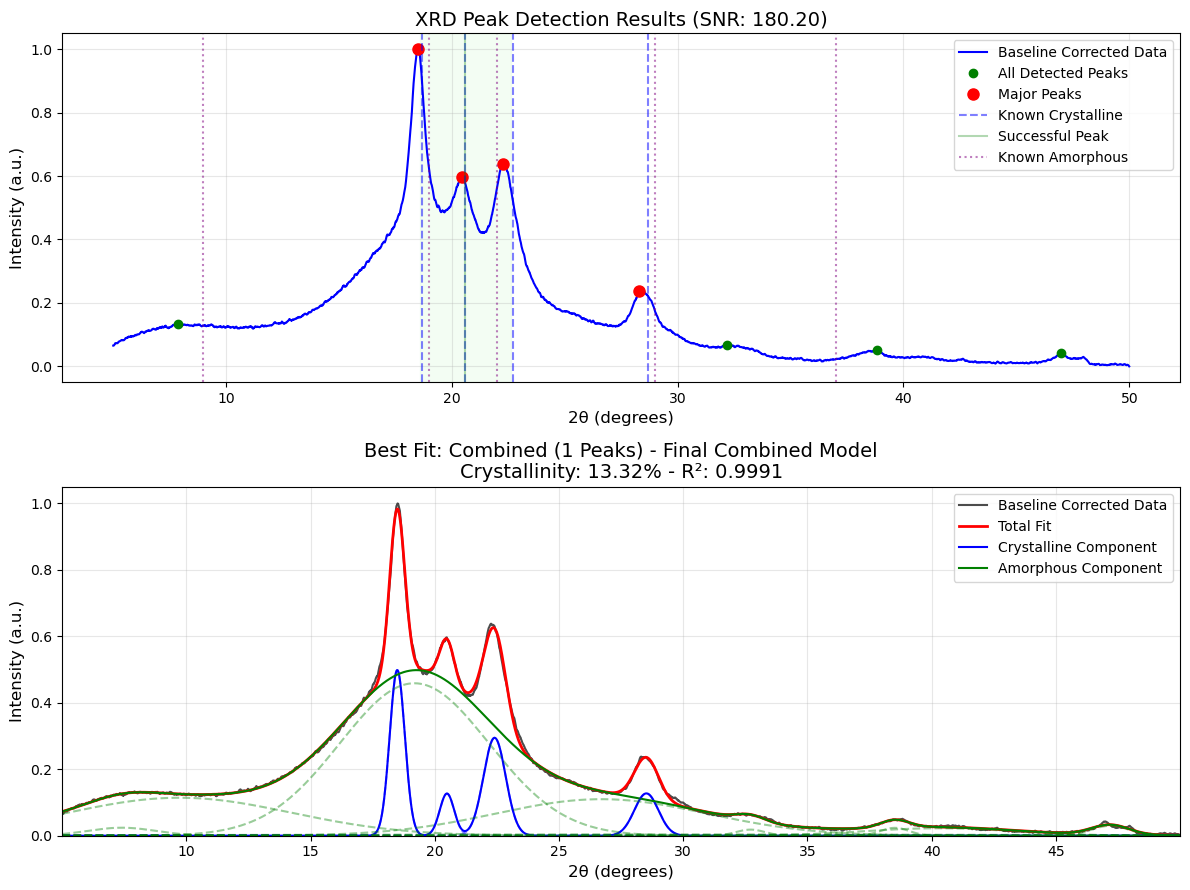

Processing file: HDPE.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.3187

Phase 2: Testing each crystalline peak individually...
  Testing peak at 21.5°...
  Peak at 21.5°: DETECTED with good local fit (+0.9390) but overall R² = 0.9795 < 0.9990
    - Adding anyway due to substantial local improvement
  Testing peak at 23.9°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 23.9°: DETECTED but minimal local R² improvement: +-12.5595
  Testing peak at 30.0°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 30.0°: DETECTED but minimal local R² improvement: +-72.6429
  Testing peak at 36.2°...
  Peak at 36.2°: DETECTED with good local fit (+1.0014) but overall R² = 0.9795 < 0.9990
    - Adding anyway due to substantial local improvement
Phase 2: SUCCESSFUL - 2 crystalline peaks identified

Phase 3: Performing final combined fit with 2 crystalline peaks...
Ph

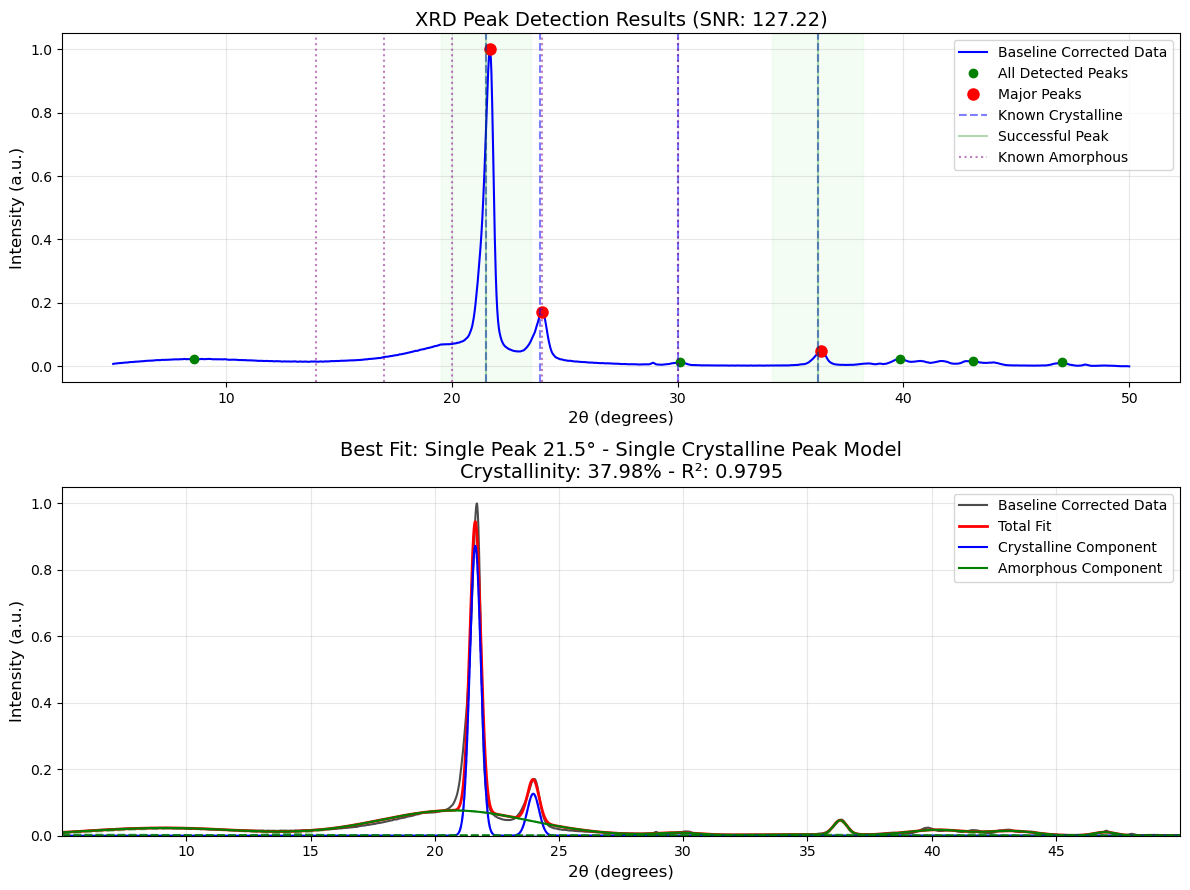

Processing file: HDPE_2.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.2892

Phase 2: Testing each crystalline peak individually...
  Testing peak at 21.5°...
  Peak at 21.5°: DETECTED with good local fit (+0.9330) but overall R² = 0.9732 < 0.9990
    - Adding anyway due to substantial local improvement
  Testing peak at 23.9°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 23.9°: DETECTED but minimal local R² improvement: +-7.1597
  Testing peak at 30.0°...
Fitting error: `x0` is infeasible.
Falling back to initial guess parameters
  Peak at 30.0°: DETECTED but minimal local R² improvement: +-50.4068
  Testing peak at 36.2°...
  Peak at 36.2°: DETECTED with good local fit (+0.9856) but overall R² = 0.9732 < 0.9990
    - Adding anyway due to substantial local improvement
Phase 2: SUCCESSFUL - 2 crystalline peaks identified

Phase 3: Performing final combined fit with 2 crystalline peaks...
P

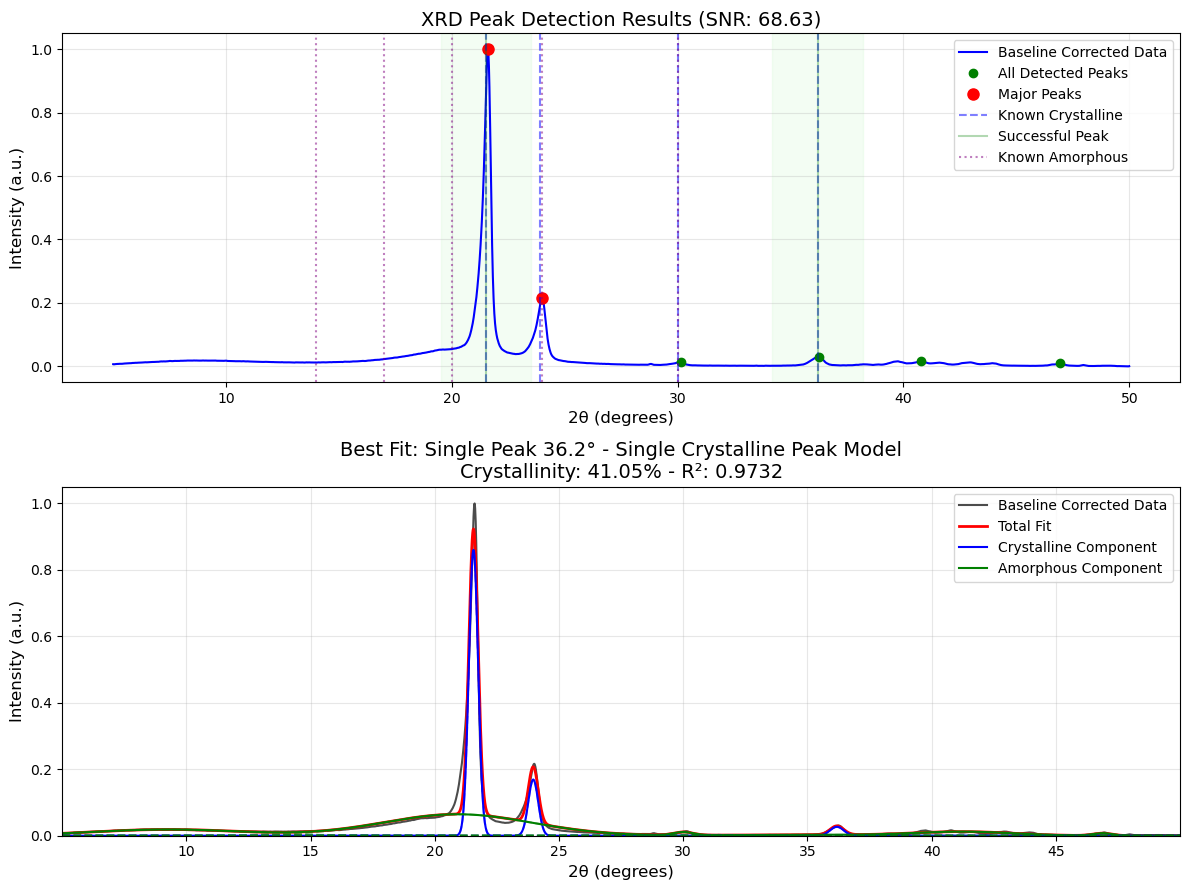

In [66]:
known_crys_peaks_dict = {
    'PEEK': [18.7, 20.6, 22.7, 28.7],   # (110), (111), (200), (211) 
    'HDPE': [21.5, 23.9, 30.0, 36.2,] # (110), (200), (210), (020)
}

known_amorp_peaks_dict = {
    'PEEK': [9, 19, 22, 29, 37],
    'HDPE': [14, 17, 20, 24, 30]
}

cryst_dict = {}
for file in all_files:
    print(f"Processing file: {file}")
    if 'HDPE' in file:
        polymer = 'HDPE'
    else:
        polymer = 'PEEK'
    data = df_dict[file]
    intensity = data['Intensity_norm'].values
    two_theta = data['2Theta'].values
    
    results = fit_xrd_spectrum(two_theta, intensity, 
                               known_crys_peaks=known_crys_peaks_dict.get(polymer, None),
                               known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
                               height_width_threshold=0.25, min_r_squared=0.999, 
                               visualise=True)
    
    cryst_dict[file] = results['crystallinity']

In [68]:
cryst_dict

{'500907.csv': 8.915941707207969,
 '500907_2.csv': 10.00432668806679,
 '501023.csv': 3.050208301463247,
 '501023_2.csv': 11.84901977499125,
 '501024.csv': 12.946482990531013,
 '501024_2.csv': 13.319740891816739,
 'HDPE.csv': 37.98251671449306,
 'HDPE_2.csv': 41.05370662838499}

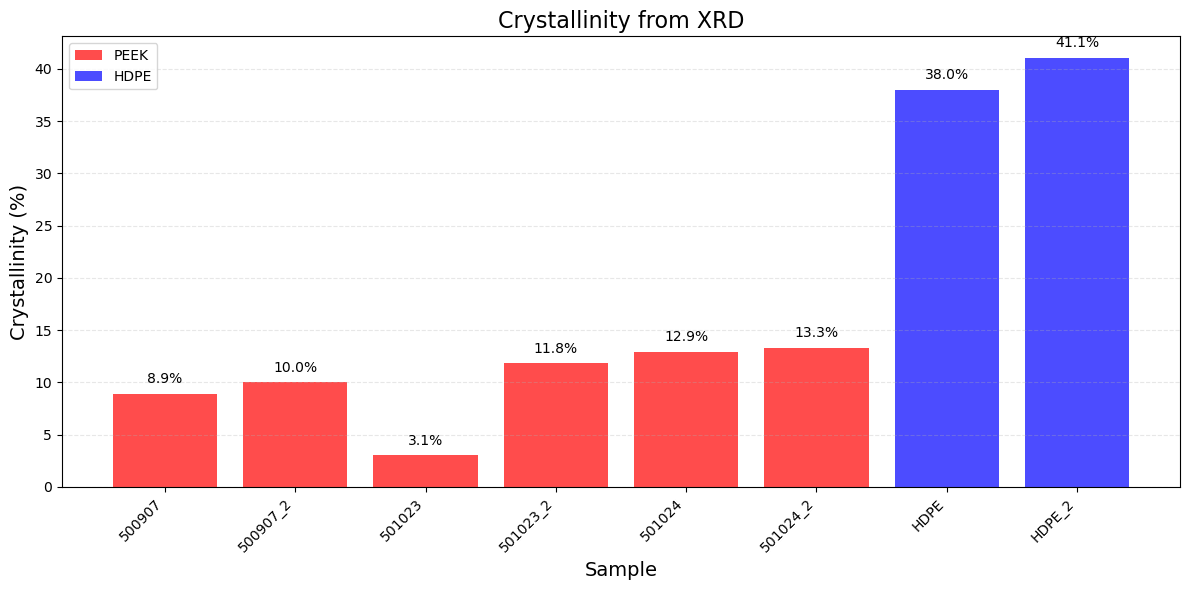

In [77]:
import numpy as np

# Plot crystallinity vs. sample
import matplotlib.pyplot as plt

# Extract sample names and crystallinity values
samples = list(cryst_dict.keys())
crystallinity_values = list(cryst_dict.values())

# Create groups for PEEK and HDPE
peek_samples = [sample for sample in samples if 'HDPE' not in sample]
hdpe_samples = [sample for sample in samples if 'HDPE' in sample]

peek_crystallinity = [cryst_dict[sample] for sample in peek_samples]
hdpe_crystallinity = [cryst_dict[sample] for sample in hdpe_samples]

# Create the figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data in groups - PEEK first, then HDPE
peek_x = np.arange(len(peek_samples))
hdpe_x = np.arange(len(peek_samples), len(peek_samples) + len(hdpe_samples))

# Plot bars for each polymer type
peek_bars = ax.bar(peek_x, peek_crystallinity, width=0.8, alpha=0.7, color='red', label='PEEK')
hdpe_bars = ax.bar(hdpe_x, hdpe_crystallinity, width=0.8, alpha=0.7, color='blue', label='HDPE')

# Add labels and formatting
ax.set_xlabel('Sample', fontsize=14)
ax.set_ylabel('Crystallinity (%)', fontsize=14)
ax.set_title('Crystallinity from XRD', fontsize=16)

# Set x-ticks and labels
all_x = np.concatenate([peek_x, hdpe_x])
all_samples = peek_samples + hdpe_samples
ax.set_xticks(all_x)
sample_labels = [sample.split('.')[0] for sample in all_samples]  # Remove file extension for cleaner labels
ax.set_xticklabels(sample_labels, rotation=45, ha='right', fontsize=10)

# Add crystallinity values above each bar
for i, v in enumerate(peek_crystallinity):
    ax.text(peek_x[i], v + 1, f"{v:.1f}%", ha='center', fontsize=10)
    
for i, v in enumerate(hdpe_crystallinity):
    ax.text(hdpe_x[i], v + 1, f"{v:.1f}%", ha='center', fontsize=10)

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add legend
ax.legend()

# Add grid for easier reading
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()